In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install optuna
!pip install lightgbm

In [6]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
import lightgbm as lgb
import optuna
from sklearn.preprocessing import FunctionTransformer
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
import keras
from tensorflow.keras.regularizers import l2
import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.regularizers import l1, l2, l1_l2
import joblib


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Introduction
Below variables are described;







**Entity**: Country or region name

**Code**: Country ISO code

**Year**: Year

**Annual CO₂ emissions - target**: Annual carbon dioxide (CO₂) emissions (unit: metric tons).

**Annual greenhouse gas emissions in CO₂ equivalents**: Annual greenhouse gas emissions expressed in CO₂ equivalents (unit: metric tons CO₂ equivalent).

**Change in global mean surface temperature caused by greenhouse gas emissions**: Change in global mean surface temperature caused by greenhouse gas emissions (unit: degrees Celsius).

**Annual CO₂ emissions per GDP**: Annual CO₂ emissions per GDP (unit: kilograms/international-$).

**Population**: Population

**GDP**: Gross domestic product (unit: international dollars).

**Cumulative cement CO₂**: Cumulative CO₂ emissions from cement production (unit: metric tons).

**Cumulative CO₂**: Cumulative CO₂ emissions (unit: metric tons).

**Cumulative CO₂ including LUC**: Cumulative CO₂ emissions including land-use change (unit: metric tons).

**Cumulative coal CO₂**: Cumulative CO₂ emissions from coal (unit: metric tons).

**Cumulative flaring CO₂**: Cumulative CO₂ emissions from gas flaring (unit: metric tons).

**Cumulative gas CO₂**: Cumulative CO₂ emissions from natural gas (unit: metric tons).

**Cumulative LUC CO₂**: Cumulative CO₂ emissions from land-use change (unit: metric tons).

**Cumulative oil CO₂**: Cumulative CO₂ emissions from oil (unit: metric tons).


In [7]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Koç Üniversitesi - Msc In Data Science Project/carbon_emmision_info.csv"

def load_original_data(path):
  dataframe = pd.read_csv(file_path, index_col=0)
  dataframe.rename(columns={"Annual CO₂ emissions": "target"}, inplace=True)
  dataframe.drop("co2", axis=1, inplace=True)
  country_year_df = dataframe.groupby("Entity").agg({"Year":"count"}).reset_index()
  target_countries = country_year_df[country_year_df["Year"] >= 73]["Entity"].values
  dataframe = dataframe[dataframe["Entity"].isin(target_countries)]

  numerical_cols = dataframe.iloc[:, 3:].columns
  categorical_cols = dataframe.iloc[:, :3].columns
  return dataframe, numerical_cols, categorical_cols


df, num_cols, cat_cols = load_original_data(file_path)
df.shape


(10439, 17)

In [8]:
df.head()

Entity Code  Year    target  \
0  Afghanistan  AFG  1950   84272.0   
1  Afghanistan  AFG  1951   91600.0   
2  Afghanistan  AFG  1952   91600.0   
3  Afghanistan  AFG  1953  106256.0   
4  Afghanistan  AFG  1954  106256.0   

   Annual greenhouse gas emissions in CO₂ equivalents  \
0                                         18975016.0    
1                                         19921294.0    
2                                         20694344.0    
3                                         21577796.0    
4                                         22238252.0    

   Change in global mean surface temperature caused by greenhouse gas emissions  \
0                                           0.000501                              
1                                           0.000512                              
2                                           0.000523                              
3                                           0.000534                              
4                                           0.000546                              

   Annual CO₂ emissions per GDP (kg per international-$)  population  \
0                                           0.008945       7480464.0   
1                                           0.009451       7571542.0   
2                                           0.009144       7667534.0   
3                                           0.009995       7764549.0   
4                                           0.009778       7864289.0   

            gdp  cumulative_cement_co2  cumulative_co2  \
0  9.421400e+09                    0.0           0.099   
1  9.692280e+09                    0.0           0.191   
2  1.001733e+10                    0.0           0.282   
3  1.063052e+10                    0.0           0.388   
4  1.086636e+10                    0.0           0.495   

   cumulative_co2_including_luc  cumulative_coal_co2  cumulative_flaring_co2  \
0                        13.638                0.036                     0.0   
1                        21.870                0.061                     0.0   
2                        31.053                0.093                     0.0   
3                        41.309                0.131                     0.0   
4                        52.405                0.174                     0.0   

   cumulative_gas_co2  cumulative_luc_co2  cumulative_oil_co2  
0                 0.0             524.616               0.063  
1                 0.0             532.756               0.129  
2                 0.0             541.847               0.189  
3                 0.0             551.997               0.257  
4                 0.0             562.987               0.321

In [9]:
print(num_cols)
print(cat_cols)

Index(['target', 'Annual greenhouse gas emissions in CO₂ equivalents',
       'Change in global mean surface temperature caused by greenhouse gas emissions',
       'Annual CO₂ emissions per GDP (kg per international-$)', 'population',
       'gdp', 'cumulative_cement_co2', 'cumulative_co2',
       'cumulative_co2_including_luc', 'cumulative_coal_co2',
       'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2',
       'cumulative_oil_co2'],
      dtype='object')
Index(['Entity', 'Code', 'Year'], dtype='object')


<Axes: >

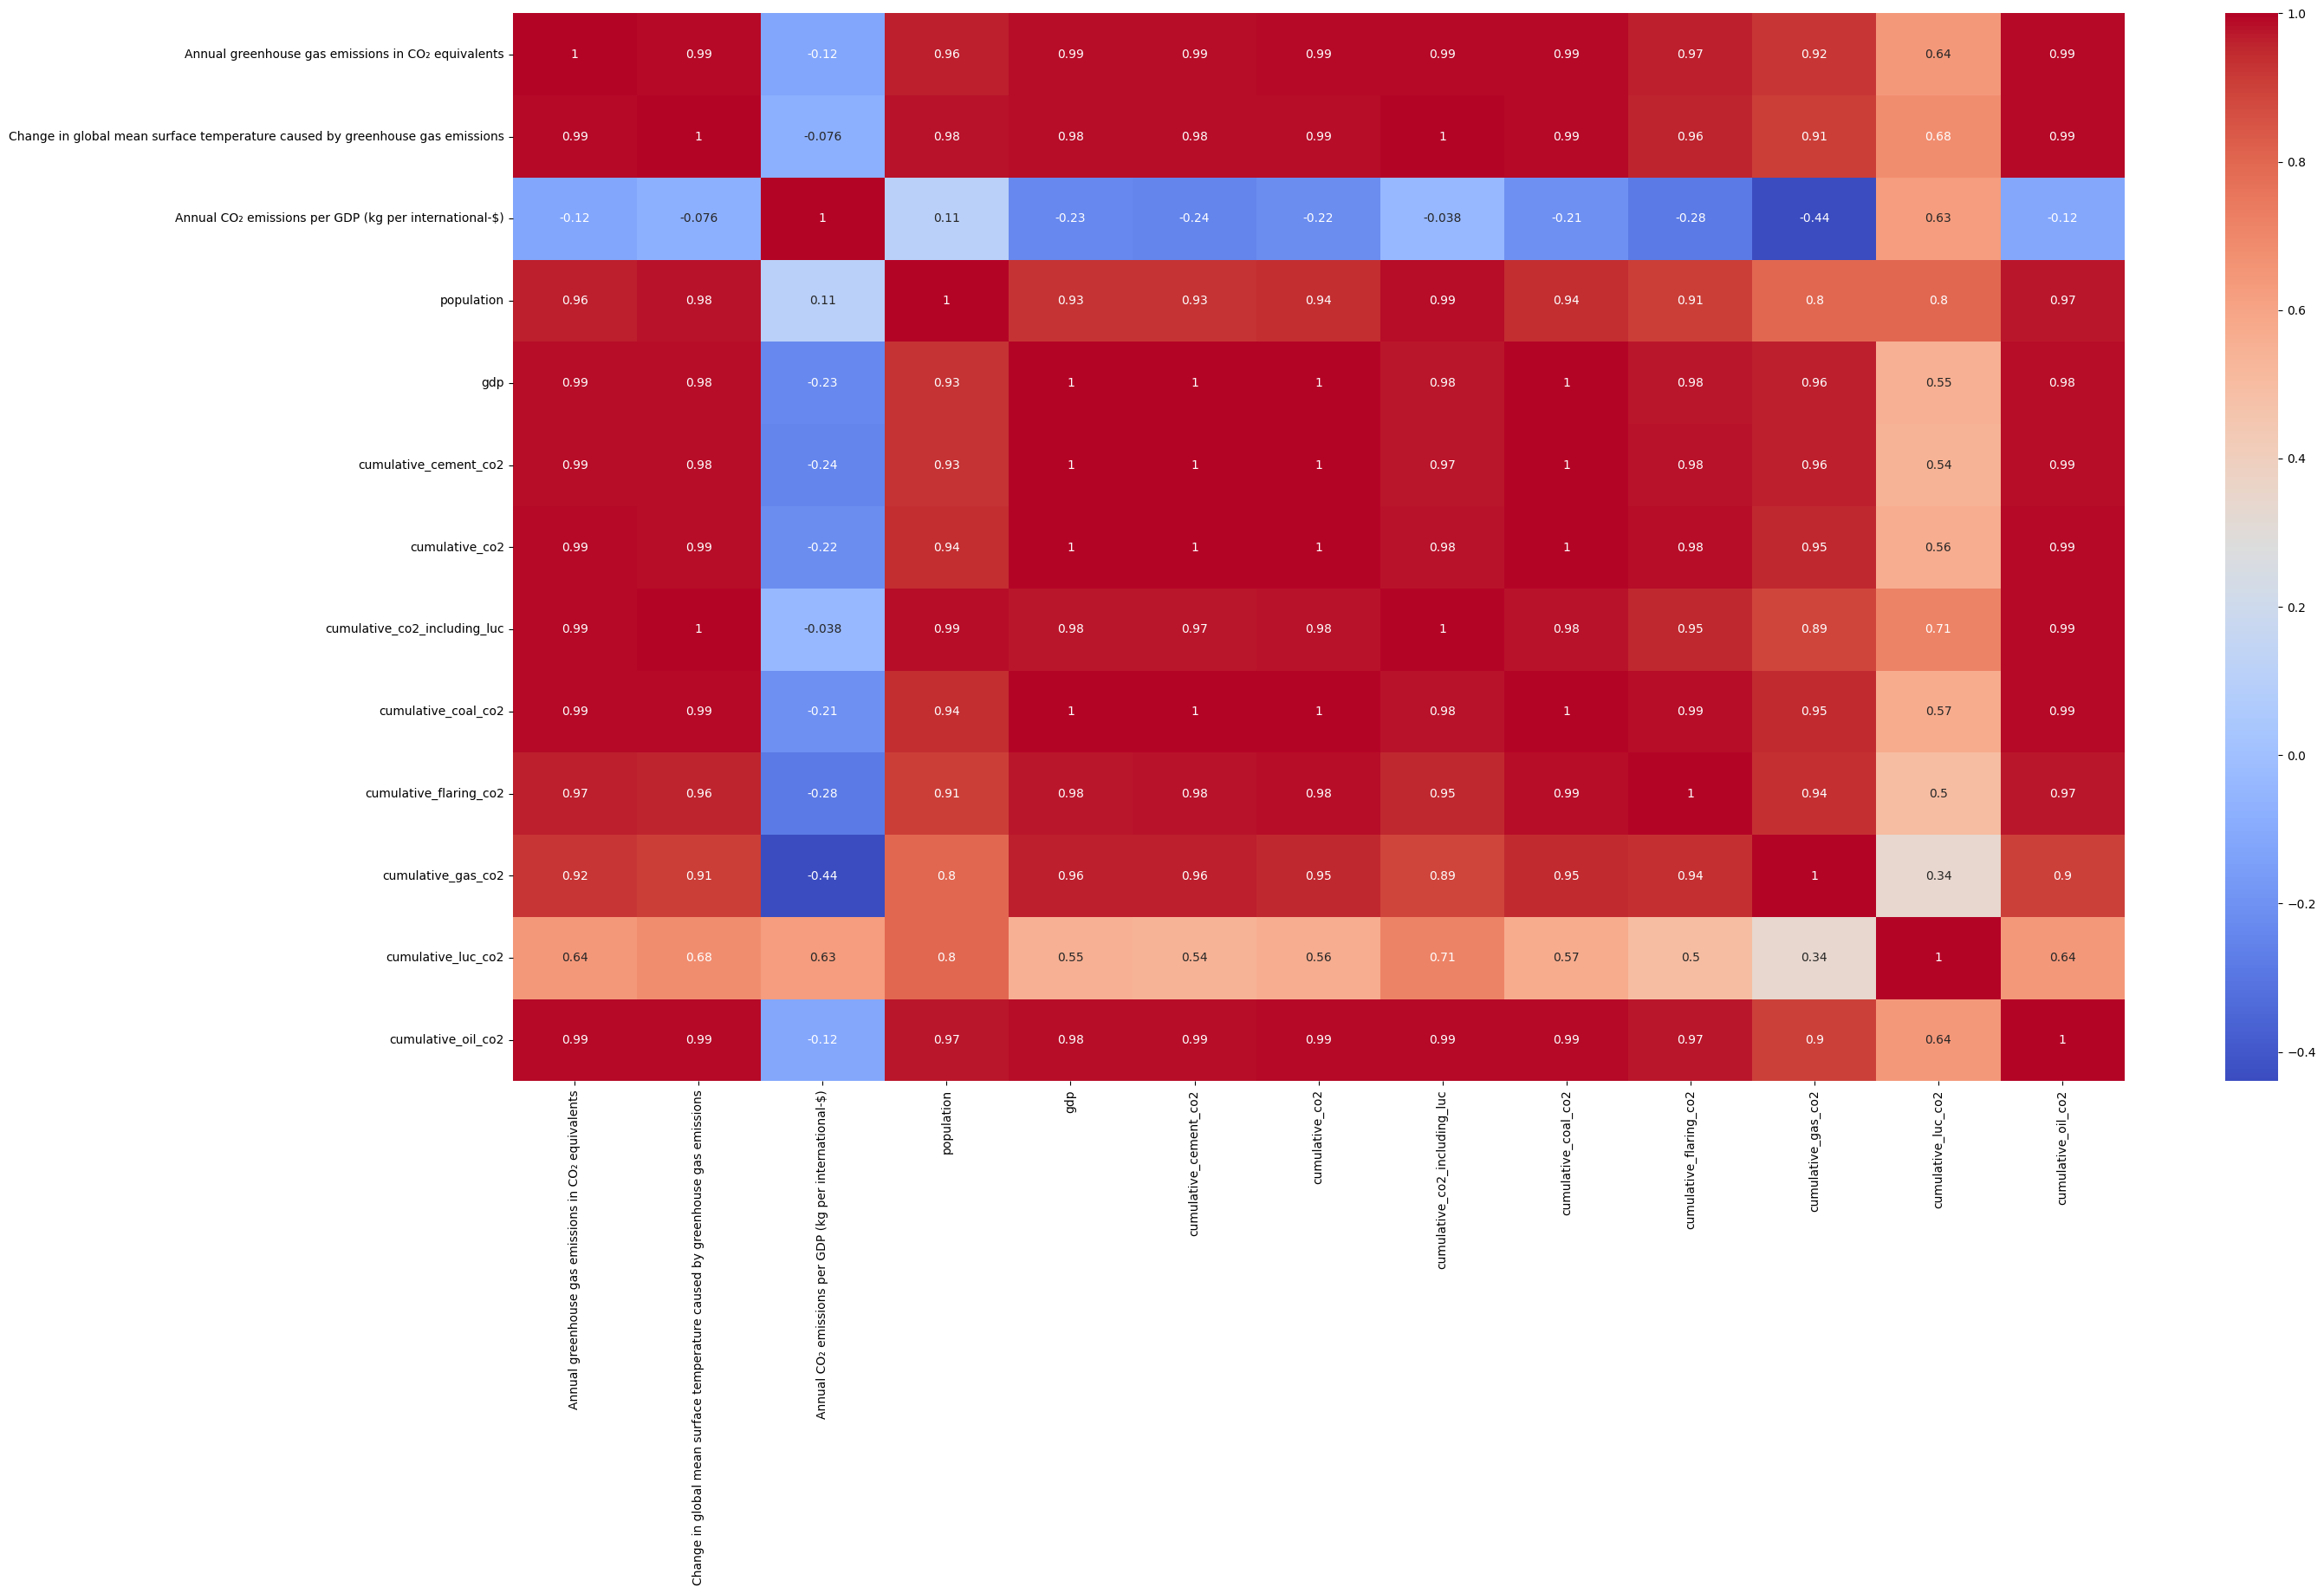

In [251]:
plt.figure(figsize=(30, 16))
plt.xticks(rotation = 45, ticks=np.arange(0, 100, 10), )
sns.heatmap(df.loc[df.Entity == "Turkey", num_cols].corr(), annot=True, cmap="coolwarm")

In [11]:
df.loc[df.Entity == "Turkey", "target"].describe()

# Annual CO₂ emissions = target

count    7.300000e+01
mean     1.590744e+08
std      1.376460e+08
min      9.488155e+06
25%      3.626549e+07
50%      1.156179e+08
75%      2.447686e+08
max      4.527028e+08
Name: target, dtype: float64

# Exploratory Data Analysis (EDA)


# New Section

## Missing Values

### Since ML and DL algorithms can affect by missing values, the lackness of these values must be handled by deleting or imputing them. The number of observations is not high enough, missing values will be imputed in this project.

In [12]:
df[df.isnull().any(axis=1)]


Entity Code  Year        target  \
75                            Africa  NaN  1950  9.486800e+07   
76                            Africa  NaN  1951  1.011253e+08   
77                            Africa  NaN  1952  1.103252e+08   
78                            Africa  NaN  1953  1.120070e+08   
79                            Africa  NaN  1954  1.175361e+08   
80                            Africa  NaN  1955  1.294025e+08   
81                            Africa  NaN  1956  1.351062e+08   
82                            Africa  NaN  1957  1.415931e+08   
83                            Africa  NaN  1958  1.486709e+08   
84                            Africa  NaN  1959  1.478412e+08   
85                            Africa  NaN  1960  1.565672e+08   
86                            Africa  NaN  1961  1.619943e+08   
87                            Africa  NaN  1962  1.663349e+08   
88                            Africa  NaN  1963  1.763348e+08   
89                            Africa  NaN  1964  1.936393e+08   
90                            Africa  NaN  1965  2.136344e+08   
91                            Africa  NaN  1966  2.210821e+08   
92                            Africa  NaN  1967  2.370452e+08   
93                            Africa  NaN  1968  2.573840e+08   
94                            Africa  NaN  1969  2.779160e+08   
95                            Africa  NaN  1970  3.026239e+08   
96                            Africa  NaN  1971  3.318614e+08   
97                            Africa  NaN  1972  3.518711e+08   
98                            Africa  NaN  1973  3.780034e+08   
99                            Africa  NaN  1974  3.883896e+08   
100                           Africa  NaN  1975  3.872651e+08   
101                           Africa  NaN  1976  4.201411e+08   
102                           Africa  NaN  1977  4.331151e+08   
103                           Africa  NaN  1978  4.624871e+08   
104                           Africa  NaN  1979  4.990607e+08   
105                           Africa  NaN  1980  5.356784e+08   
106                           Africa  NaN  1981  5.485707e+08   
107                           Africa  NaN  1982  5.717272e+08   
108                           Africa  NaN  1983  5.945610e+08   
109                           Africa  NaN  1984  6.493251e+08   
110                           Africa  NaN  1985  6.656864e+08   
111                           Africa  NaN  1986  6.896980e+08   
112                           Africa  NaN  1987  6.897033e+08   
113                           Africa  NaN  1988  7.246968e+08   
114                           Africa  NaN  1989  6.977969e+08   
115                           Africa  NaN  1990  6.582814e+08   
116                           Africa  NaN  1991  6.878291e+08   
117                           Africa  NaN  1992  6.669015e+08   
118                           Africa  NaN  1993  7.066615e+08   
119                           Africa  NaN  1994  7.902814e+08   
120                           Africa  NaN  1995  8.445566e+08   
121                           Africa  NaN  1996  8.723208e+08   
122                           Africa  NaN  1997  8.939892e+08   
123                           Africa  NaN  1998  9.124421e+08   
124                           Africa  NaN  1999  8.996774e+08   
125                           Africa  NaN  2000  9.300426e+08   
126                           Africa  NaN  2001  9.195428e+08   
127                           Africa  NaN  2002  8.992742e+08   
128                           Africa  NaN  2003  9.885654e+08   
129                           Africa  NaN  2004  1.044867e+09   
130                           Africa  NaN  2005  1.063180e+09   
131                           Africa  NaN  2006  1.092166e+09   
132                           Africa  NaN  2007  1.122721e+09   
133                           Africa  NaN  2008  1.175620e+09   
134                           Africa  NaN  2009  1.173163e+09   
135                           Africa  NaN  2010  1.215374e+09   


### All variables having NaN values could be affected from DL algorithms, except the "Code" variable.

In [13]:
df.isnull().sum()

Entity                                                                             0
Code                                                                            1168
Year                                                                               0
target                                                                             0
Annual greenhouse gas emissions in CO₂ equivalents                                 0
Change in global mean surface temperature caused by greenhouse gas emissions       0
Annual CO₂ emissions per GDP (kg per international-$)                              0
population                                                                       365
gdp                                                                             1168
cumulative_cement_co2                                                            136
cumulative_co2                                                                     0
cumulative_co2_including_luc                                                     146
cumulative_coal_co2                                                                9
cumulative_flaring_co2                                                             9
cumulative_gas_co2                                                                 9
cumulative_luc_co2                                                               146
cumulative_oil_co2                                                                 9
dtype: int64

In [14]:
null_cols = list(df.isnull().sum()[df.isnull().sum() > 0].index)
null_cols.remove("Code") # Code Variable is just another naming of the country or region.
print(null_cols)

['population', 'gdp', 'cumulative_cement_co2', 'cumulative_co2_including_luc', 'cumulative_coal_co2', 'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2', 'cumulative_oil_co2']


In [15]:
countries = df.Entity.unique()
print(f"Contry number: {len(countries)}\nCountries:\n{countries}")

Contry number: 143
Countries:
['Afghanistan' 'Africa' 'Albania' 'Algeria' 'Angola' 'Argentina' 'Asia'
 'Asia (excl. China and India)' 'Australia' 'Austria' 'Bahrain'
 'Bangladesh' 'Barbados' 'Belgium' 'Benin' 'Bolivia' 'Brazil' 'Bulgaria'
 'Burkina Faso' 'Burundi' 'Cameroon' 'Canada' 'Cape Verde'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Congo'
 'Costa Rica' "Cote d'Ivoire" 'Cuba' 'Cyprus'
 'Democratic Republic of Congo' 'Denmark' 'Djibouti' 'Dominican Republic'
 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea' 'Ethiopia' 'Europe'
 'Europe (excl. EU-27)' 'Europe (excl. EU-28)' 'European Union (27)'
 'European Union (28)' 'Finland' 'France' 'Gabon' 'Gambia' 'Germany'
 'Ghana' 'Greece' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Haiti'
 'High-income countries' 'Honduras' 'Hong Kong' 'Hungary' 'Iceland'
 'India' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Jamaica'
 'Japan' 'Jordan' 'Kenya' 'Kuwait' 'Lebanon' 'Liberia' 'Libya'
 'Low-income countries' 'Lower-midd

## Outliers

### In this project, It can be easily observed that Entity, Code and Year variables are categorical variable while other variables are numerical.

In [16]:
def outlier_thresholds(dataframe, variable, country, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe.loc[dataframe.Entity == country, variable].quantile(low_quantile)
    quantile_three = dataframe.loc[dataframe.Entity == country, variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name, country):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, country)
    if pd.Series((dataframe.loc[dataframe.Entity == country, col_name] > up_limit) | (dataframe.loc[dataframe.Entity ==country, col_name] < low_limit)).any(axis=None):
        return country


In [17]:
## With this code block below, I try to detect which country has which outlier variable.
def display_outliers(dataframe, num_col):
  detections = {}
  for col in num_cols:
    if col != "target": #target variable
      for country in countries:
        country_outlier = check_outlier(dataframe, col, country)
        if country_outlier is not None:
          if country_outlier in detections:
            detections[country_outlier].append(col)
          else:
            detections[country_outlier] = [col]

  print(detections)
  return detections


outliers = display_outliers(df, num_cols)

{'Guatemala': ['Annual greenhouse gas emissions in CO₂ equivalents', 'cumulative_flaring_co2'], 'Kuwait': ['Annual greenhouse gas emissions in CO₂ equivalents', 'Annual CO₂ emissions per GDP (kg per international-$)'], 'Cape Verde': ['Annual CO₂ emissions per GDP (kg per international-$)', 'cumulative_coal_co2'], 'Equatorial Guinea': ['Annual CO₂ emissions per GDP (kg per international-$)'], 'Iran': ['Annual CO₂ emissions per GDP (kg per international-$)'], 'Mauritania': ['Annual CO₂ emissions per GDP (kg per international-$)'], 'Sierra Leone': ['Annual CO₂ emissions per GDP (kg per international-$)', 'cumulative_coal_co2'], 'Yemen': ['Annual CO₂ emissions per GDP (kg per international-$)'], 'Burkina Faso': ['cumulative_cement_co2', 'cumulative_coal_co2'], 'Burundi': ['cumulative_cement_co2'], 'Djibouti': ['cumulative_cement_co2'], 'Myanmar': ['cumulative_cement_co2'], 'Nepal': ['cumulative_cement_co2'], 'Benin': ['cumulative_coal_co2', 'cumulative_gas_co2'], 'Bolivia': ['cumulative_co

In [18]:
for k,v in outliers.items():
  print(f"{k} has {v}")


Guatemala has ['Annual greenhouse gas emissions in CO₂ equivalents', 'cumulative_flaring_co2']
Kuwait has ['Annual greenhouse gas emissions in CO₂ equivalents', 'Annual CO₂ emissions per GDP (kg per international-$)']
Cape Verde has ['Annual CO₂ emissions per GDP (kg per international-$)', 'cumulative_coal_co2']
Equatorial Guinea has ['Annual CO₂ emissions per GDP (kg per international-$)']
Iran has ['Annual CO₂ emissions per GDP (kg per international-$)']
Mauritania has ['Annual CO₂ emissions per GDP (kg per international-$)']
Sierra Leone has ['Annual CO₂ emissions per GDP (kg per international-$)', 'cumulative_coal_co2']
Yemen has ['Annual CO₂ emissions per GDP (kg per international-$)']
Burkina Faso has ['cumulative_cement_co2', 'cumulative_coal_co2']
Burundi has ['cumulative_cement_co2']
Djibouti has ['cumulative_cement_co2']
Myanmar has ['cumulative_cement_co2']
Nepal has ['cumulative_cement_co2']
Benin has ['cumulative_coal_co2', 'cumulative_gas_co2']
Bolivia has ['cumulative_co

count    7.300000e+01
mean     5.310868e+07
std      1.714846e+07
min      3.143129e+07
5%       3.432566e+07
10%      3.608696e+07
20%      3.897205e+07
30%      4.400390e+07
40%      4.714135e+07
50%      5.086195e+07
60%      5.316997e+07
70%      5.547483e+07
80%      6.353899e+07
90%      7.004947e+07
95%      8.318279e+07
99%      1.144729e+08
max      1.216545e+08
Name: Annual greenhouse gas emissions in CO₂ equivalents, dtype: float64


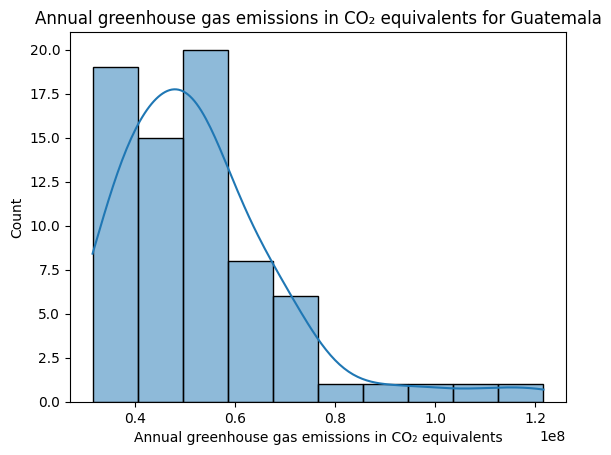

##########################################################################
count    73.000000
mean      0.062603
std       0.193236
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       0.139400
95%       0.550400
99%       0.855440
max       0.926000
Name: cumulative_flaring_co2, dtype: float64


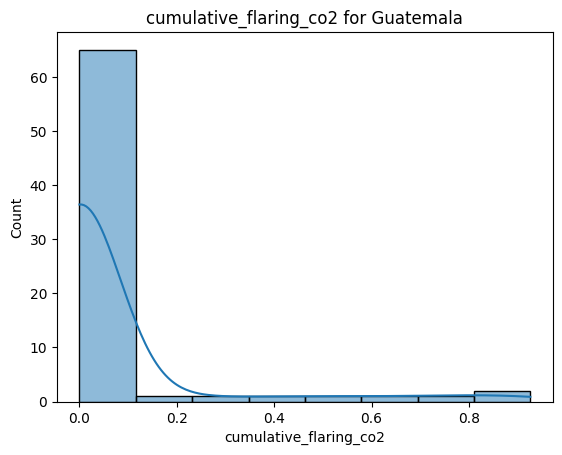

##########################################################################
count    7.300000e+01
mean     7.801362e+07
std      6.422081e+07
min      3.558186e+06
5%       8.922496e+06
10%      2.290932e+07
20%      4.207143e+07
30%      4.746730e+07
40%      5.538698e+07
50%      6.197221e+07
60%      8.050962e+07
70%      8.816508e+07
80%      1.164019e+08
90%      1.391541e+08
95%      1.462895e+08
99%      2.491368e+08
max      4.995292e+08
Name: Annual greenhouse gas emissions in CO₂ equivalents, dtype: float64


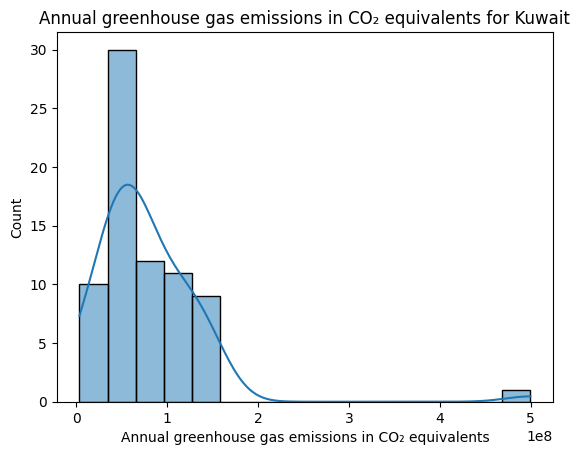

##########################################################################
count    73.000000
mean      1.879600
std       9.586946
min       0.000000
5%        0.083692
10%       0.226381
20%       0.448695
30%       0.487215
40%       0.529453
50%       0.637226
60%       0.773673
70%       0.993939
80%       1.211067
90%       1.446917
95%       1.688078
99%      24.547953
max      82.575790
Name: Annual CO₂ emissions per GDP (kg per international-$), dtype: float64


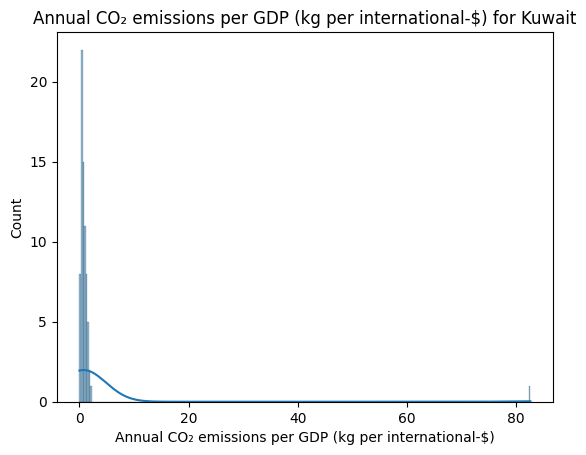

##########################################################################
count    73.000000
mean      0.178219
std       0.118487
min       0.054487
5%        0.073811
10%       0.082710
20%       0.099141
30%       0.124094
40%       0.137909
50%       0.152796
60%       0.176452
70%       0.202945
80%       0.210662
90%       0.239527
95%       0.381306
99%       0.666178
max       0.698494
Name: Annual CO₂ emissions per GDP (kg per international-$), dtype: float64


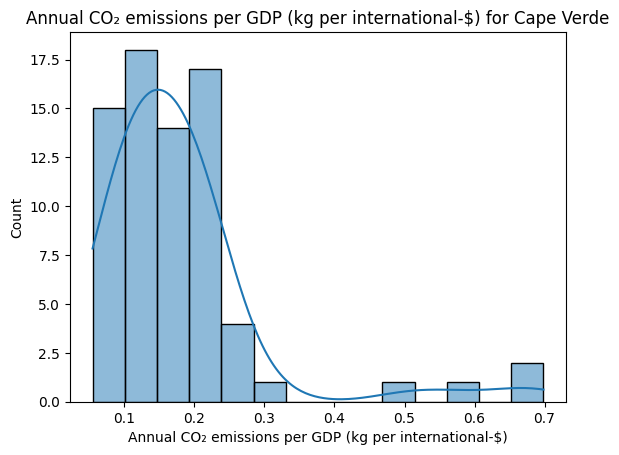

##########################################################################
count    73.000000
mean      0.239041
std       0.020808
min       0.096000
5%        0.213600
10%       0.244000
20%       0.244000
30%       0.244000
40%       0.244000
50%       0.244000
60%       0.244000
70%       0.244000
80%       0.244000
90%       0.244000
95%       0.244000
99%       0.244000
max       0.244000
Name: cumulative_coal_co2, dtype: float64


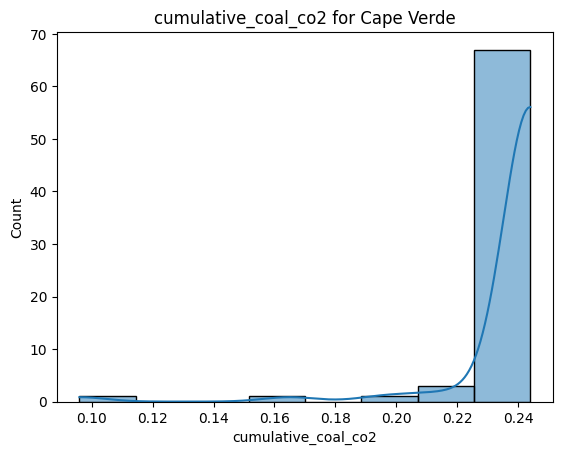

##########################################################################
count    73.000000
mean      0.193936
std       0.172892
min       0.047933
5%        0.055786
10%       0.060387
20%       0.069490
30%       0.082698
40%       0.098219
50%       0.131015
60%       0.196987
70%       0.227417
80%       0.278078
90%       0.334172
95%       0.513915
99%       0.869452
max       0.903825
Name: Annual CO₂ emissions per GDP (kg per international-$), dtype: float64


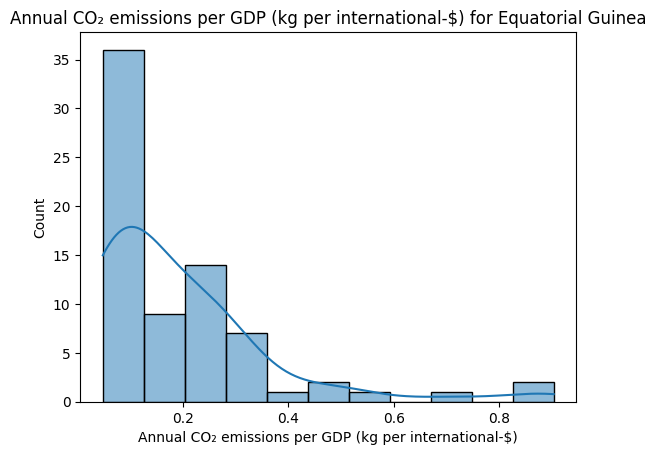

##########################################################################
count    73.000000
mean      0.470874
std       0.118473
min       0.023259
5%        0.190110
10%       0.394243
20%       0.444175
30%       0.456002
40%       0.466653
50%       0.476423
60%       0.488036
70%       0.508903
80%       0.536278
90%       0.603206
95%       0.628479
99%       0.659341
max       0.659681
Name: Annual CO₂ emissions per GDP (kg per international-$), dtype: float64


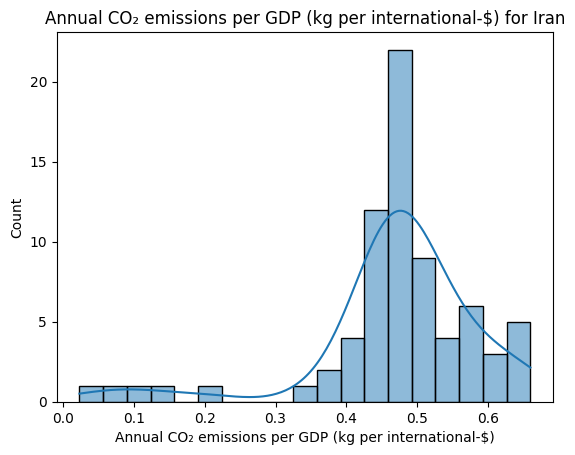

##########################################################################
count    73.000000
mean      0.223846
std       0.204145
min       0.000000
5%        0.000000
10%       0.000000
20%       0.089174
30%       0.189970
40%       0.213122
50%       0.223229
60%       0.232892
70%       0.246183
80%       0.261945
90%       0.292657
95%       0.358916
99%       1.133092
max       1.158270
Name: Annual CO₂ emissions per GDP (kg per international-$), dtype: float64


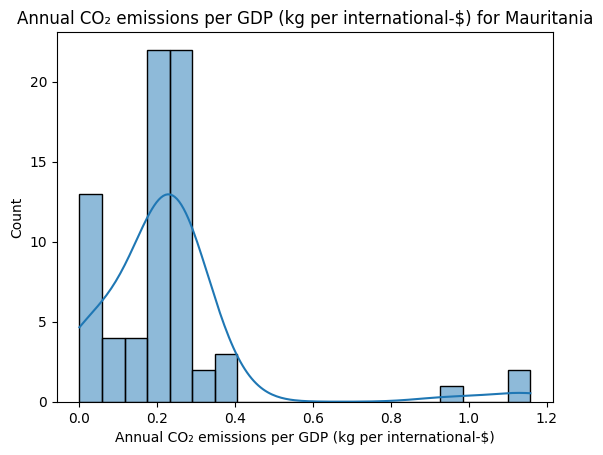

##########################################################################
count    73.000000
mean      0.098595
std       0.039624
min       0.041638
5%        0.048549
10%       0.057253
20%       0.072494
30%       0.079106
40%       0.087138
50%       0.094866
60%       0.098456
70%       0.106744
80%       0.113678
90%       0.130667
95%       0.166640
99%       0.255086
max       0.258986
Name: Annual CO₂ emissions per GDP (kg per international-$), dtype: float64


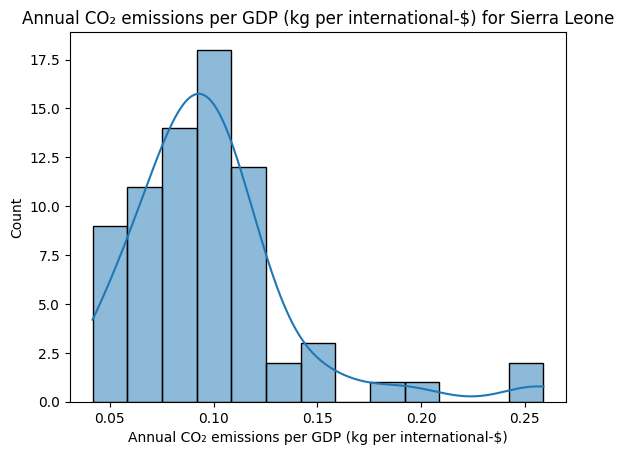

##########################################################################
count    73.000000
mean      0.792301
std       0.167845
min       0.106000
5%        0.366200
10%       0.612400
20%       0.843400
30%       0.850000
40%       0.850000
50%       0.850000
60%       0.850000
70%       0.850000
80%       0.864000
90%       0.864000
95%       0.864000
99%       0.864000
max       0.864000
Name: cumulative_coal_co2, dtype: float64


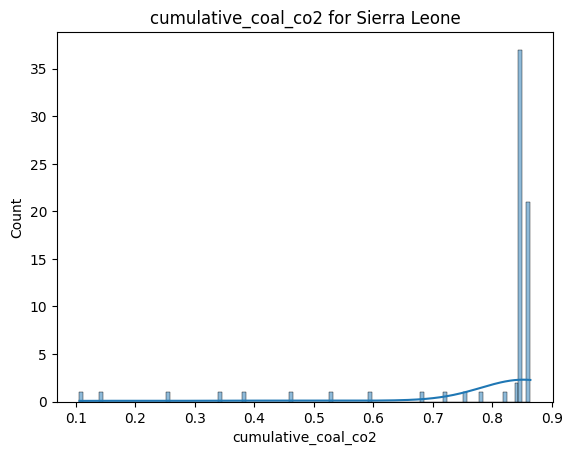

##########################################################################
count    73.000000
mean      0.220179
std       0.138134
min       0.005658
5%        0.054528
10%       0.098380
20%       0.141317
30%       0.179355
40%       0.192986
50%       0.204578
60%       0.219952
70%       0.237852
80%       0.270968
90%       0.348926
95%       0.403035
99%       0.706299
max       1.035071
Name: Annual CO₂ emissions per GDP (kg per international-$), dtype: float64


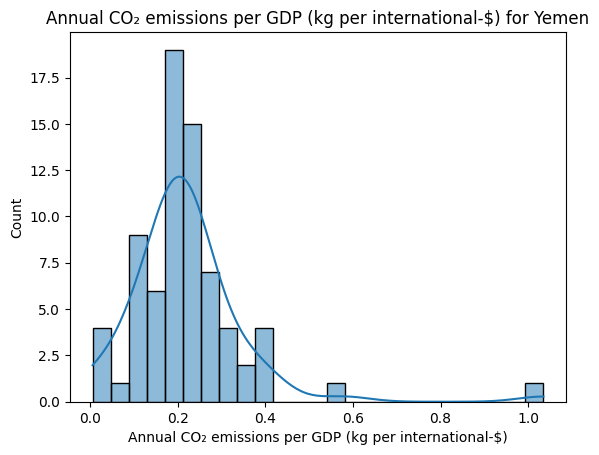

##########################################################################
count    61.000000
mean      0.837787
std       1.901641
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.057000
70%       0.226000
80%       0.885000
90%       2.907000
95%       5.501000
99%       7.999200
max       8.706000
Name: cumulative_cement_co2, dtype: float64


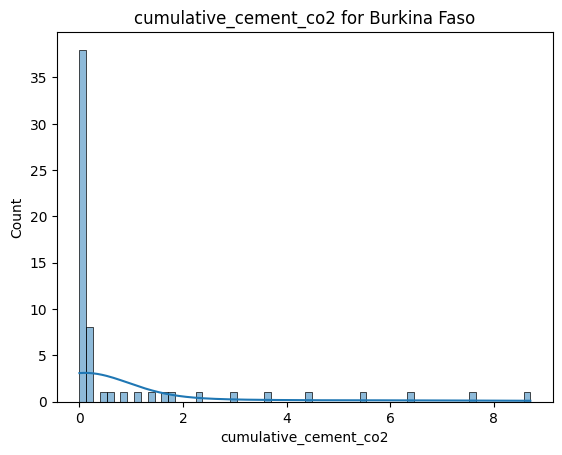

##########################################################################
count    73.000000
mean      0.004849
std       0.000638
min       0.001000
5%        0.004000
10%       0.005000
20%       0.005000
30%       0.005000
40%       0.005000
50%       0.005000
60%       0.005000
70%       0.005000
80%       0.005000
90%       0.005000
95%       0.005000
99%       0.005000
max       0.005000
Name: cumulative_coal_co2, dtype: float64


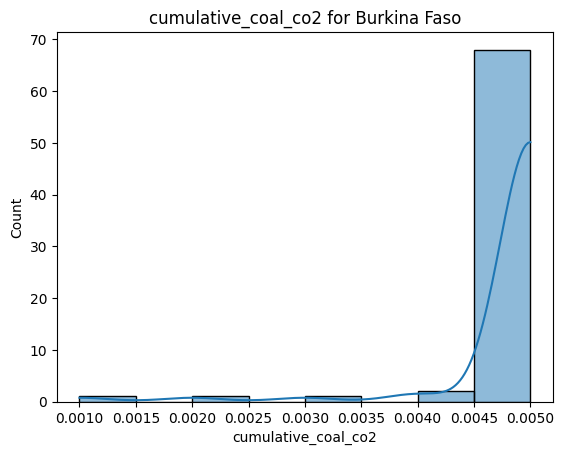

##########################################################################
count    58.000000
mean      0.000293
std       0.001351
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       0.000000
95%       0.000450
99%       0.006860
max       0.008000
Name: cumulative_cement_co2, dtype: float64


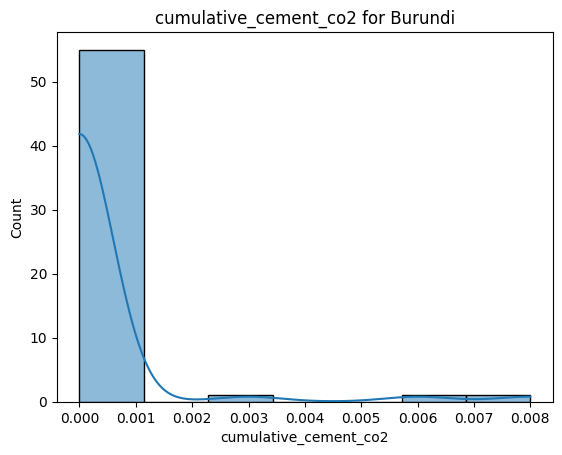

##########################################################################
count    54.000000
mean      0.071407
std       0.185358
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       0.272400
95%       0.507550
99%       0.772800
max       0.847000
Name: cumulative_cement_co2, dtype: float64


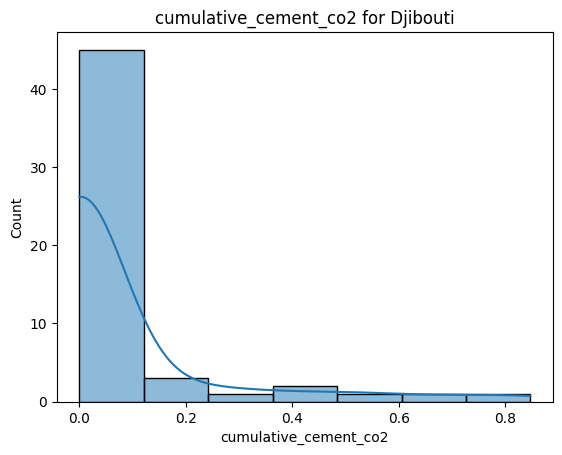

##########################################################################
count    73.000000
mean      4.405342
std       4.999777
min       0.000000
5%        0.068400
10%       0.148800
20%       0.400400
30%       0.992800
40%       1.816400
50%       3.020000
60%       4.236200
70%       5.513800
80%       7.051800
90%       9.398600
95%      15.023400
99%      21.752960
max      23.594000
Name: cumulative_cement_co2, dtype: float64


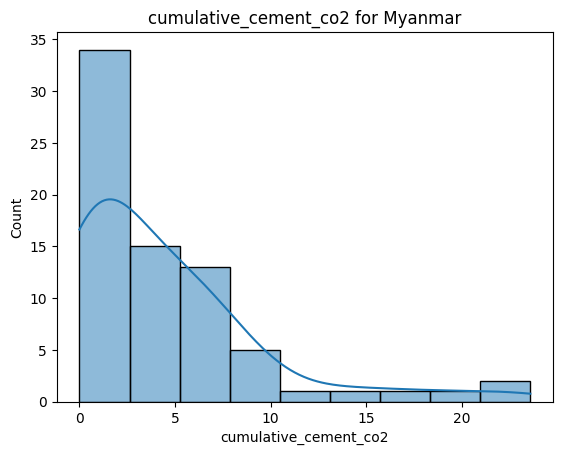

##########################################################################
count    73.000000
mean      3.007205
std       6.631631
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.083000
50%       0.213000
60%       0.791600
70%       1.639600
80%       2.466800
90%       8.828600
95%      19.333200
99%      29.135520
max      31.608000
Name: cumulative_cement_co2, dtype: float64


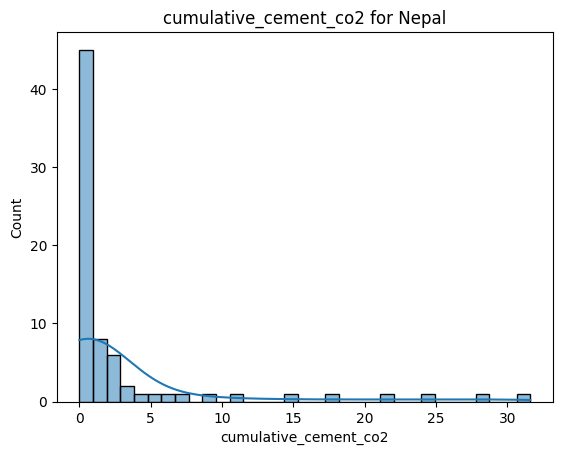

##########################################################################
count    73.000000
mean      0.270329
std       0.355731
min       0.026000
5%        0.140200
10%       0.164000
20%       0.164000
30%       0.164000
40%       0.164000
50%       0.164000
60%       0.164000
70%       0.164000
80%       0.164000
90%       0.439000
95%       0.983400
99%       1.814040
max       2.025000
Name: cumulative_coal_co2, dtype: float64


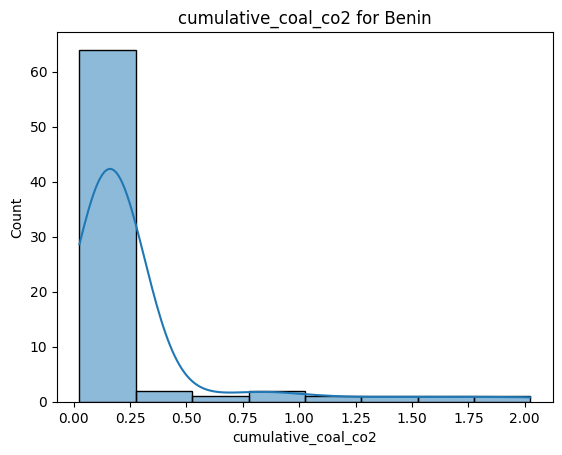

##########################################################################
count    73.000000
mean      0.057685
std       0.213892
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       0.124200
95%       0.291400
99%       1.101280
max       1.336000
Name: cumulative_gas_co2, dtype: float64


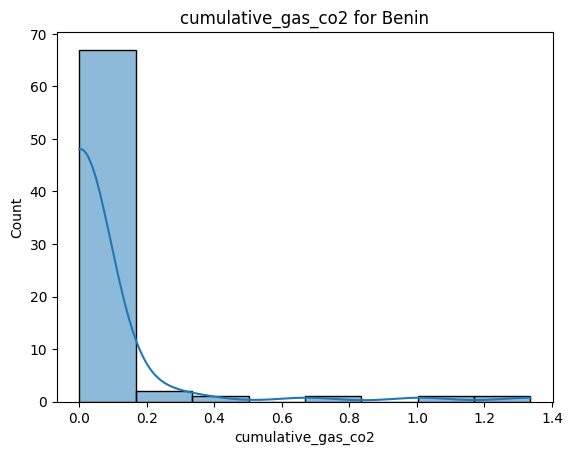

##########################################################################
count    73.000000
mean      0.220808
std       0.067946
min       0.004000
5%        0.099600
10%       0.161800
20%       0.191600
30%       0.212000
40%       0.219200
50%       0.234000
60%       0.234000
70%       0.234000
80%       0.234000
90%       0.268000
95%       0.343400
99%       0.417280
max       0.436000
Name: cumulative_coal_co2, dtype: float64


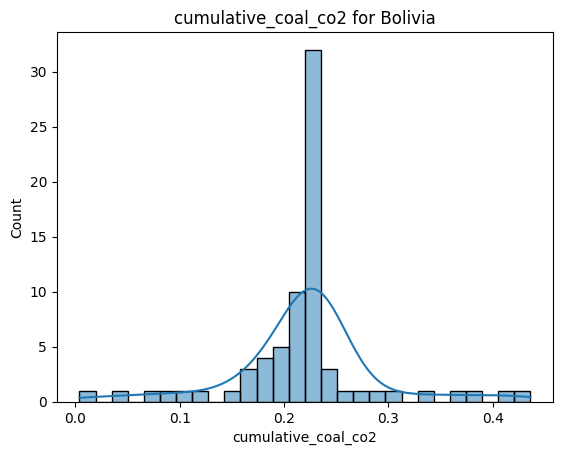

##########################################################################
count    73.000000
mean      0.018493
std       0.002268
min       0.005000
5%        0.016600
10%       0.019000
20%       0.019000
30%       0.019000
40%       0.019000
50%       0.019000
60%       0.019000
70%       0.019000
80%       0.019000
90%       0.019000
95%       0.019000
99%       0.019000
max       0.019000
Name: cumulative_coal_co2, dtype: float64


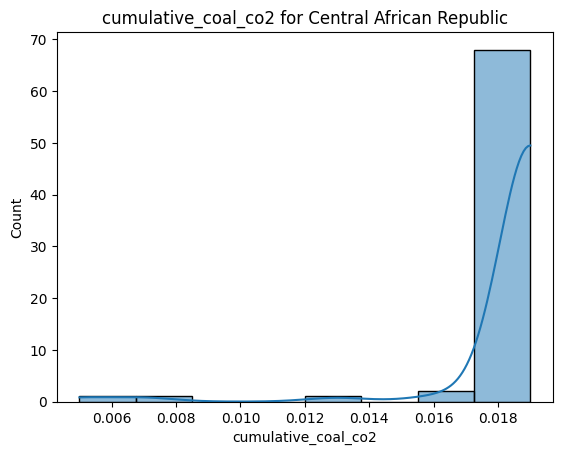

##########################################################################
count    73.000000
mean      0.011671
std       0.001482
min       0.003000
5%        0.010600
10%       0.012000
20%       0.012000
30%       0.012000
40%       0.012000
50%       0.012000
60%       0.012000
70%       0.012000
80%       0.012000
90%       0.012000
95%       0.012000
99%       0.012000
max       0.012000
Name: cumulative_coal_co2, dtype: float64


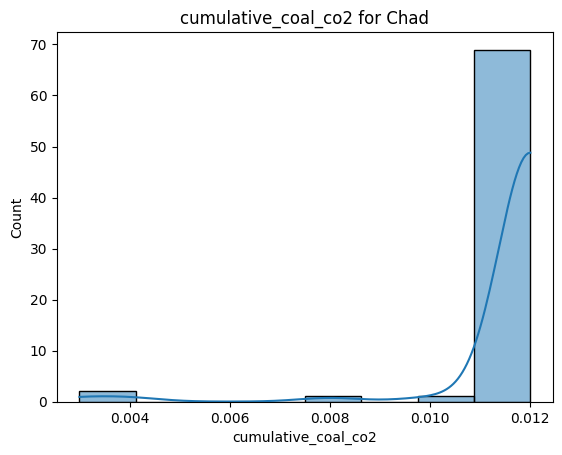

##########################################################################
count    73.000000
mean      0.035041
std       0.004335
min       0.009000
5%        0.031600
10%       0.036000
20%       0.036000
30%       0.036000
40%       0.036000
50%       0.036000
60%       0.036000
70%       0.036000
80%       0.036000
90%       0.036000
95%       0.036000
99%       0.036000
max       0.036000
Name: cumulative_coal_co2, dtype: float64


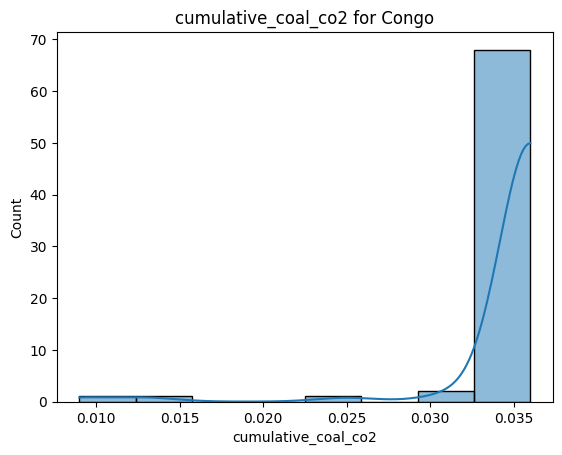

##########################################################################
count    73.000000
mean      1.411795
std       3.031784
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.323000
40%       0.503400
50%       0.530000
60%       0.541000
70%       0.541000
80%       0.767200
90%       3.662800
95%       8.264000
99%      14.090040
max      15.507000
Name: cumulative_gas_co2, dtype: float64


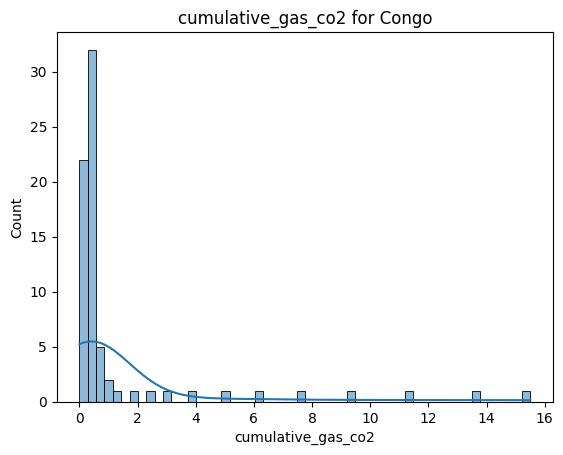

##########################################################################
count    73.000000
mean      0.637356
std       0.081434
min       0.104000
5%        0.560000
10%       0.656000
20%       0.656000
30%       0.656000
40%       0.656000
50%       0.656000
60%       0.656000
70%       0.656000
80%       0.656000
90%       0.656000
95%       0.656000
99%       0.656000
max       0.656000
Name: cumulative_coal_co2, dtype: float64


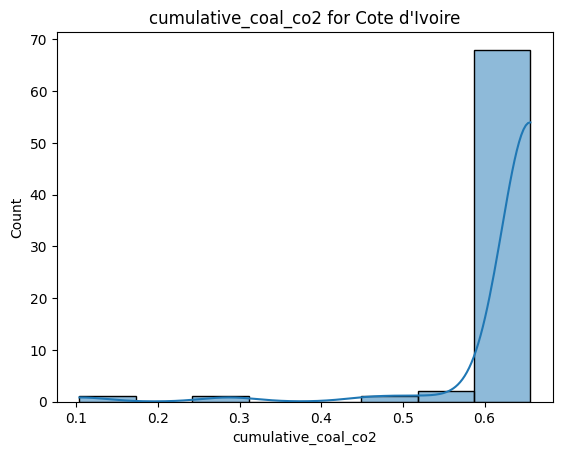

##########################################################################
count    73.000000
mean      1.492192
std       3.281018
min       0.021000
5%        0.076200
10%       0.155000
20%       0.303000
30%       0.388000
40%       0.388000
50%       0.388000
60%       0.388000
70%       0.388000
80%       0.412000
90%       4.434600
95%       9.191000
99%      14.811440
max      16.538000
Name: cumulative_coal_co2, dtype: float64


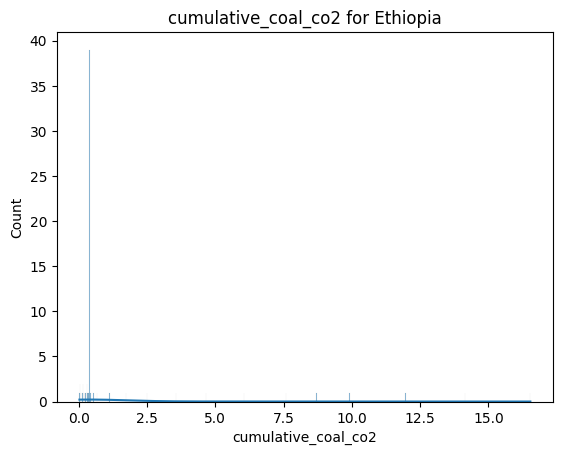

##########################################################################
count    73.000000
mean      0.000795
std       0.002809
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       0.000000
95%       0.011000
99%       0.011000
max       0.011000
Name: cumulative_flaring_co2, dtype: float64


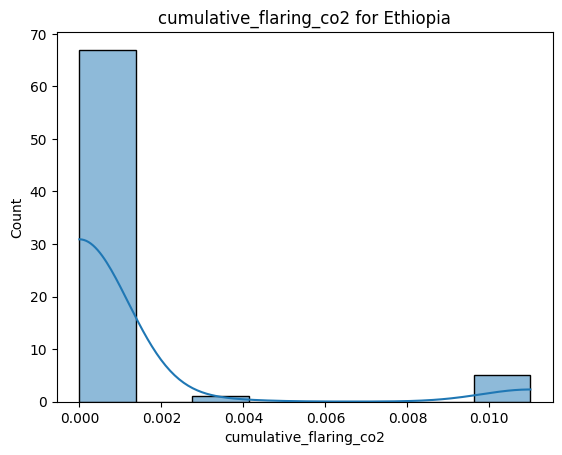

##########################################################################
count    73.000000
mean      0.007781
std       0.000975
min       0.002000
5%        0.007000
10%       0.008000
20%       0.008000
30%       0.008000
40%       0.008000
50%       0.008000
60%       0.008000
70%       0.008000
80%       0.008000
90%       0.008000
95%       0.008000
99%       0.008000
max       0.008000
Name: cumulative_coal_co2, dtype: float64


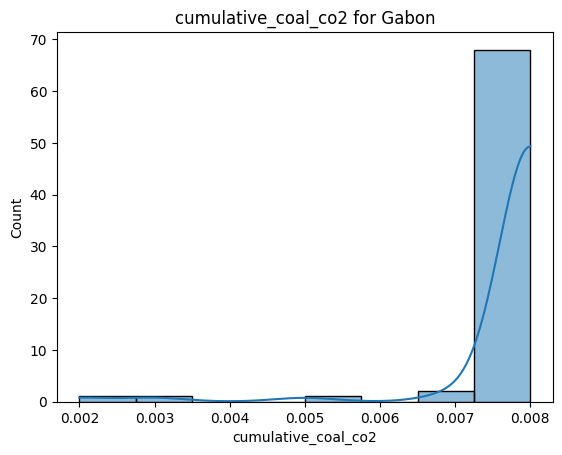

##########################################################################
count    73.000000
mean      0.210849
std       0.026891
min       0.035000
5%        0.185200
10%       0.217000
20%       0.217000
30%       0.217000
40%       0.217000
50%       0.217000
60%       0.217000
70%       0.217000
80%       0.217000
90%       0.217000
95%       0.217000
99%       0.217000
max       0.217000
Name: cumulative_coal_co2, dtype: float64


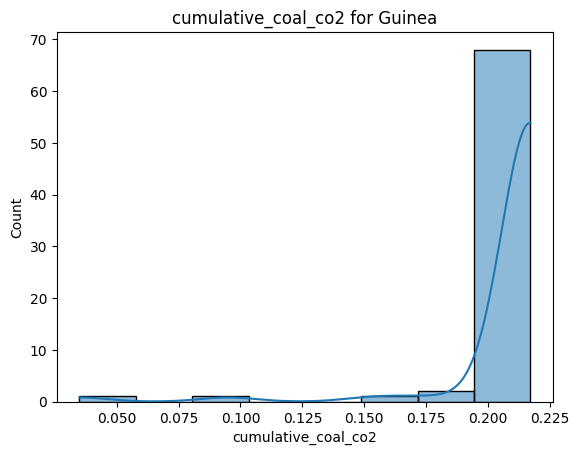

##########################################################################
count    73.000000
mean      0.686000
std       1.998157
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       2.675000
95%       5.523600
99%       8.745880
max       9.859000
Name: cumulative_coal_co2, dtype: float64


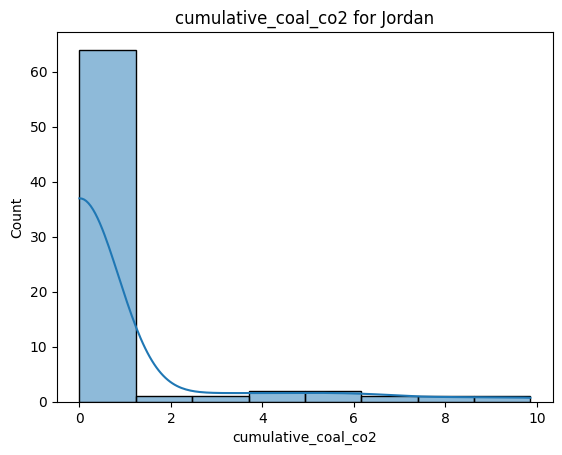

##########################################################################
count    73.000000
mean      2.680822
std       3.413826
min       0.169000
5%        0.399400
10%       0.471000
20%       0.694000
30%       1.059000
40%       1.389200
50%       1.767000
60%       2.026400
70%       2.227400
80%       2.449800
90%       6.696800
95%      11.194000
99%      15.307840
max      16.462000
Name: cumulative_coal_co2, dtype: float64


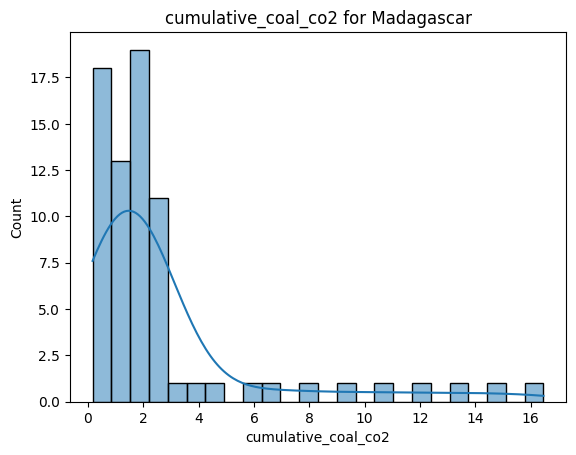

##########################################################################
count    73.000000
mean      1.956247
std       3.655458
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.042200
40%       0.099000
50%       0.172000
60%       0.878600
70%       2.042600
80%       2.265000
90%       6.341400
95%       9.126800
99%      16.702520
max      18.239000
Name: cumulative_coal_co2, dtype: float64


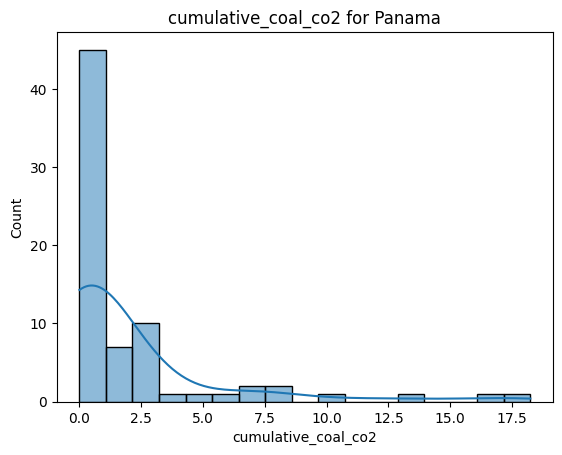

##########################################################################
count    73.000000
mean      0.394397
std       0.912461
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.099000
60%       0.407000
70%       0.407000
80%       0.407000
90%       0.407000
95%       1.531200
99%       4.519400
max       5.675000
Name: cumulative_gas_co2, dtype: float64


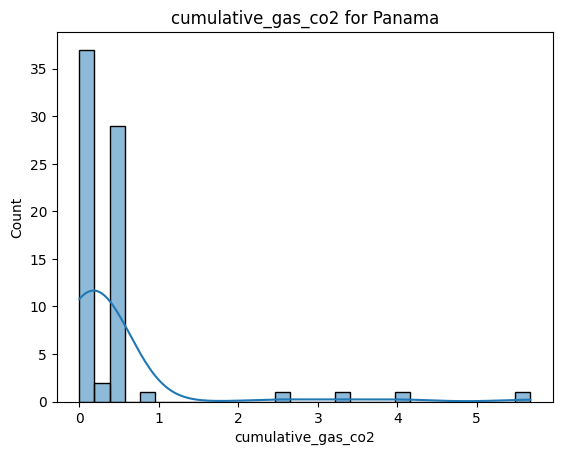

##########################################################################
count    73.000000
mean      0.004260
std       0.011863
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       0.015800
95%       0.038200
99%       0.048840
max       0.051000
Name: cumulative_coal_co2, dtype: float64


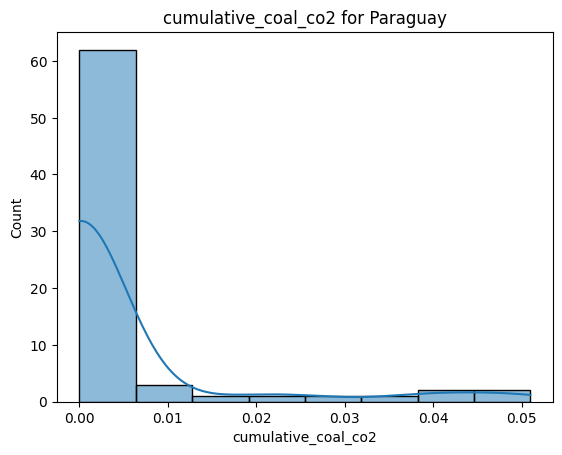

##########################################################################
count    73.000000
mean      0.015041
std       0.016017
min       0.002000
5%        0.004000
10%       0.004000
20%       0.012000
30%       0.012000
40%       0.012000
50%       0.012000
60%       0.012000
70%       0.012000
80%       0.012000
90%       0.012000
95%       0.048200
99%       0.085640
max       0.095000
Name: cumulative_coal_co2, dtype: float64


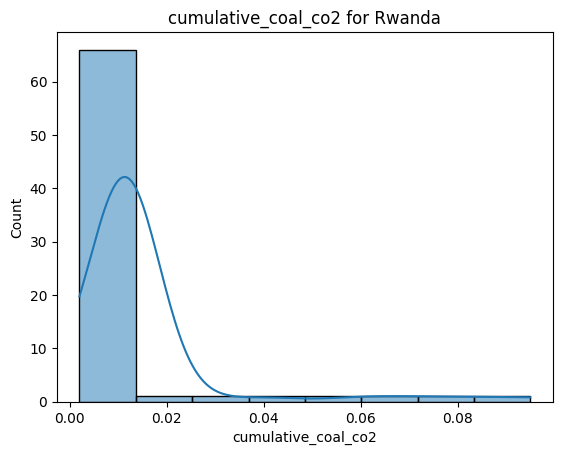

##########################################################################
count    73.000000
mean      0.055356
std       0.144347
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.003200
50%       0.018000
60%       0.018000
70%       0.026000
80%       0.026000
90%       0.082400
95%       0.391800
99%       0.675800
max       0.755000
Name: cumulative_gas_co2, dtype: float64


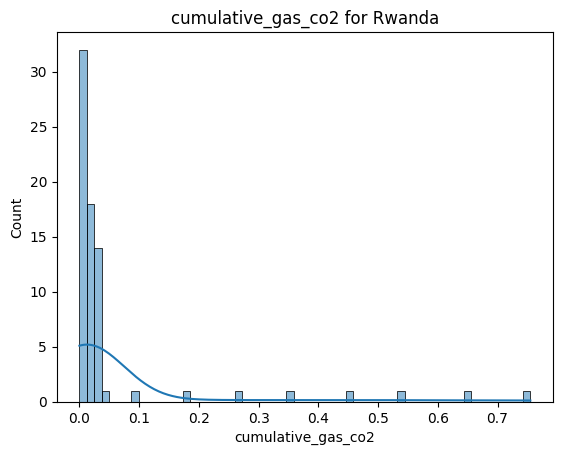

##########################################################################
count    73.000000
mean      0.177192
std       0.621666
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       0.000000
95%       1.605200
99%       2.898240
max       3.210000
Name: cumulative_coal_co2, dtype: float64


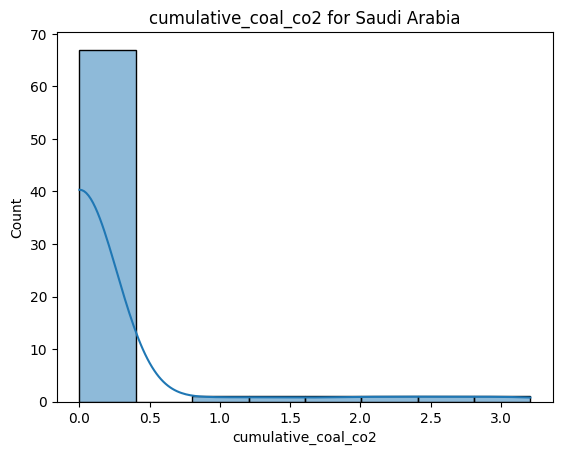

##########################################################################
count    73.000000
mean      6.684740
std       4.767219
min       0.758000
5%        3.415400
10%       4.749200
20%       4.922400
30%       5.012600
40%       5.097200
50%       5.237000
60%       5.646600
70%       5.757000
80%       5.974800
90%      10.426800
95%      19.318400
99%      24.753200
max      26.096000
Name: cumulative_coal_co2, dtype: float64


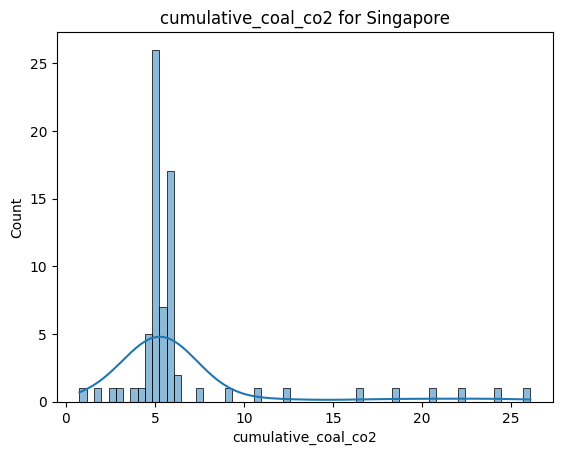

##########################################################################
count    73.000000
mean     14.107000
std      13.035631
min       0.995000
5%        4.133400
10%       6.191400
20%       9.484000
30%      10.433800
40%      10.537200
50%      10.729000
60%      10.751600
70%      10.784600
80%      12.004000
90%      25.666400
95%      45.846200
99%      65.276400
max      69.654000
Name: cumulative_coal_co2, dtype: float64


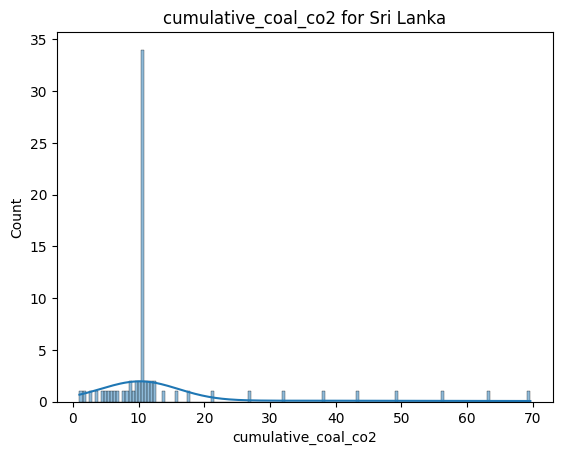

##########################################################################
count    73.000000
mean      2.526342
std       3.274548
min       0.154000
5%        0.725800
10%       0.823800
20%       0.864600
30%       0.932800
40%       0.994200
50%       1.046000
60%       1.396000
70%       2.463000
80%       3.339000
90%       5.204600
95%       9.992400
99%      15.490640
max      17.030000
Name: cumulative_coal_co2, dtype: float64


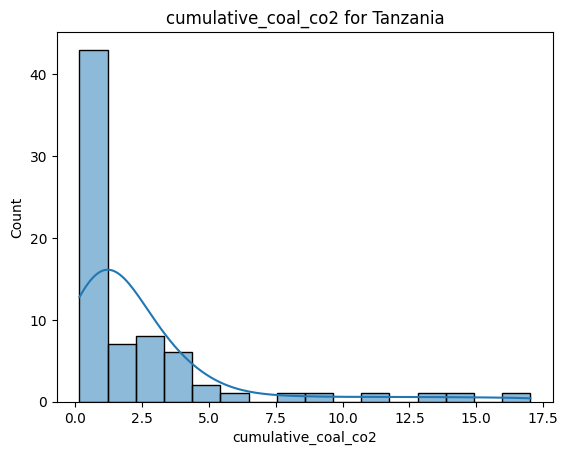

##########################################################################
count    73.000000
mean      0.221589
std       0.028484
min       0.051000
5%        0.189600
10%       0.205000
20%       0.225200
30%       0.231000
40%       0.231000
50%       0.231000
60%       0.231000
70%       0.231000
80%       0.231000
90%       0.231000
95%       0.231000
99%       0.231000
max       0.231000
Name: cumulative_coal_co2, dtype: float64


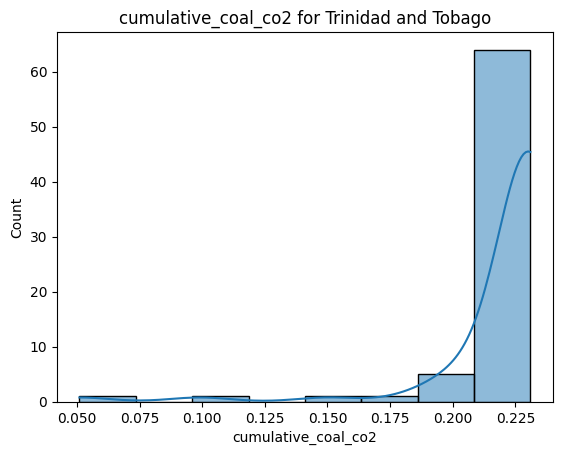

##########################################################################
count    73.000000
mean      0.013096
std       0.038612
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       0.040000
95%       0.133600
99%       0.140480
max       0.152000
Name: cumulative_flaring_co2, dtype: float64


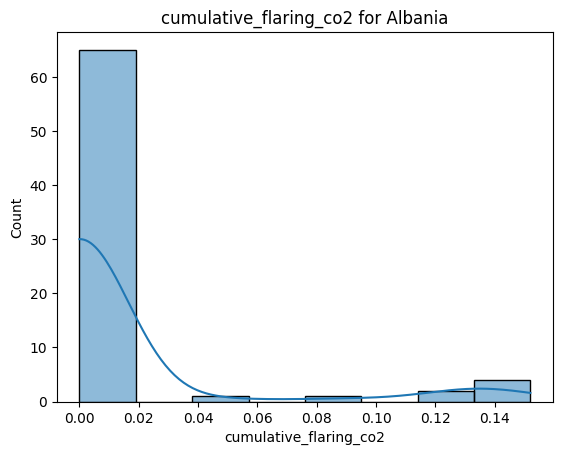

##########################################################################
count    73.000000
mean      0.148863
std       0.449870
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       0.401600
95%       1.126000
99%       2.067280
max       2.194000
Name: cumulative_flaring_co2, dtype: float64


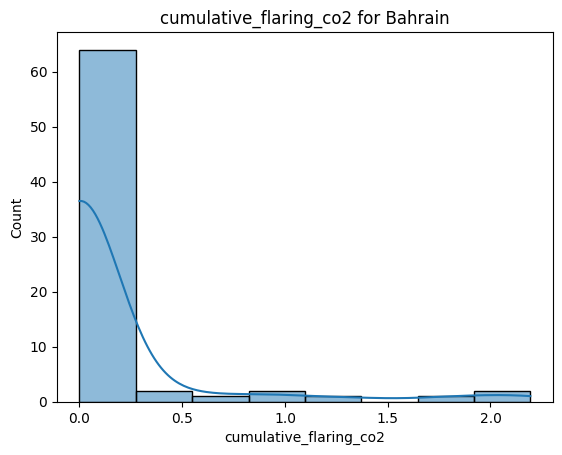

##########################################################################
count    73.000000
mean      0.024178
std       0.068369
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       0.110400
95%       0.189800
99%       0.292920
max       0.321000
Name: cumulative_flaring_co2, dtype: float64


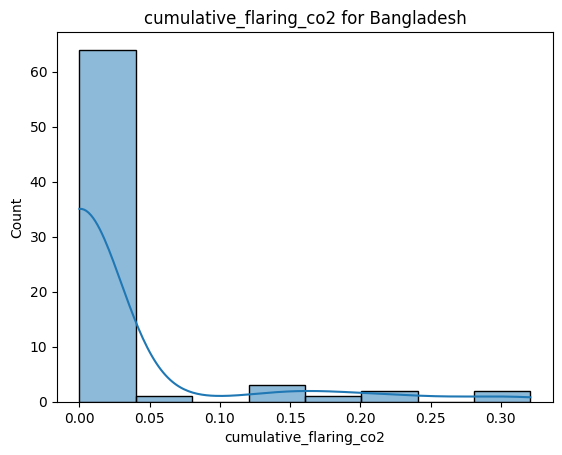

##########################################################################
count    73.000000
mean      0.356014
std       0.957126
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.279600
90%       1.121000
95%       2.326400
99%       4.533960
max       5.205000
Name: cumulative_flaring_co2, dtype: float64


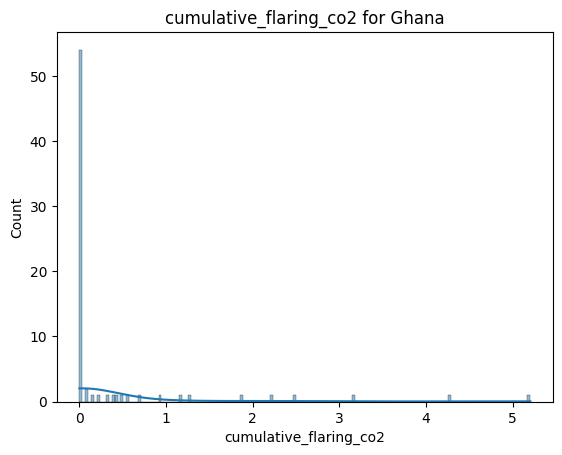

##########################################################################
count    73.000000
mean      2.343014
std       7.017264
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       7.038000
95%      16.332000
99%      33.318480
max      37.884000
Name: cumulative_gas_co2, dtype: float64


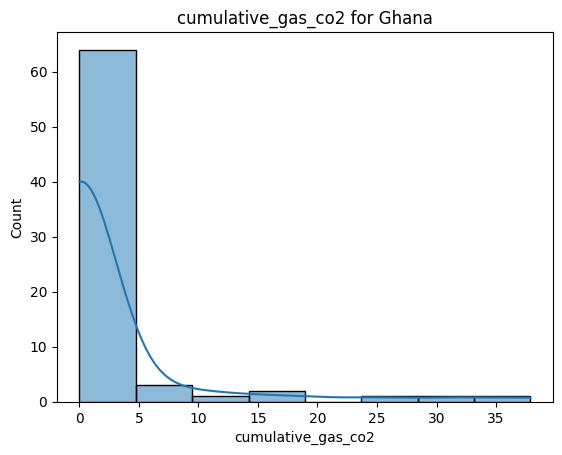

##########################################################################
count    73.000000
mean      0.000932
std       0.003501
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       0.001800
95%       0.007000
99%       0.013040
max       0.026000
Name: cumulative_flaring_co2, dtype: float64


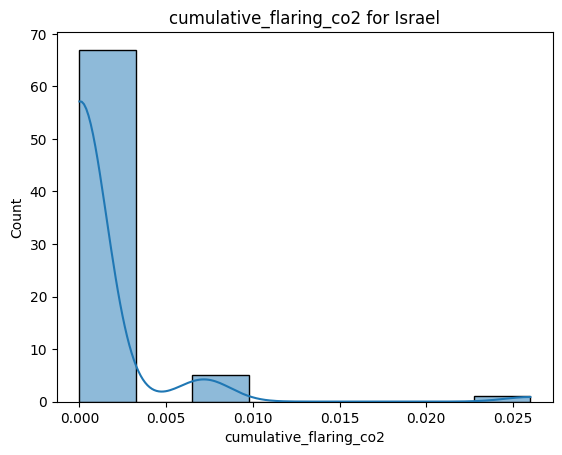

##########################################################################
count    73.000000
mean      0.030192
std       0.120790
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       0.108200
95%       0.150800
99%       0.384280
max       0.979000
Name: cumulative_flaring_co2, dtype: float64


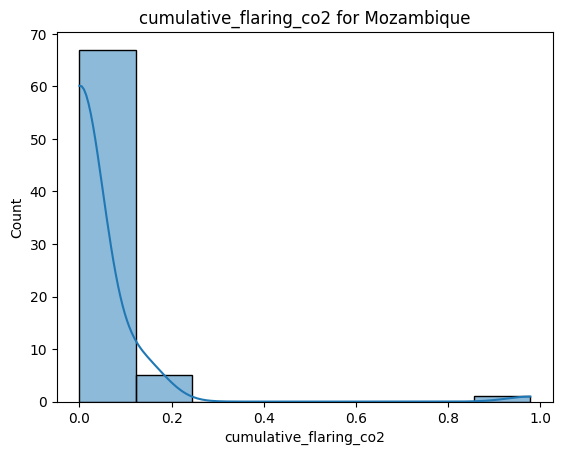

##########################################################################
count    73.000000
mean      1.270438
std       3.520917
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.001600
80%       0.458800
90%       4.240600
95%      10.045000
99%      15.398000
max      16.892000
Name: cumulative_gas_co2, dtype: float64


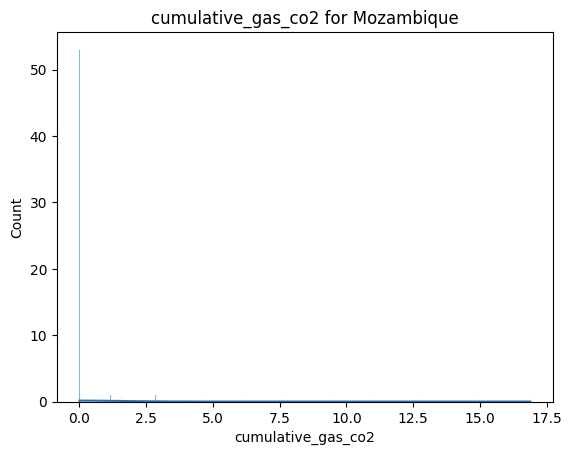

##########################################################################
count    73.000000
mean      0.000904
std       0.003042
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       0.000000
95%       0.011000
99%       0.011000
max       0.011000
Name: cumulative_flaring_co2, dtype: float64


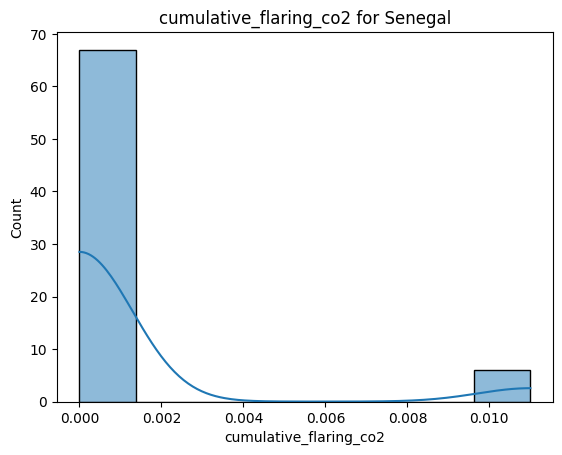

##########################################################################
count    73.000000
mean      0.000247
std       0.001562
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       0.000000
95%       0.000000
99%       0.007680
max       0.012000
Name: cumulative_flaring_co2, dtype: float64


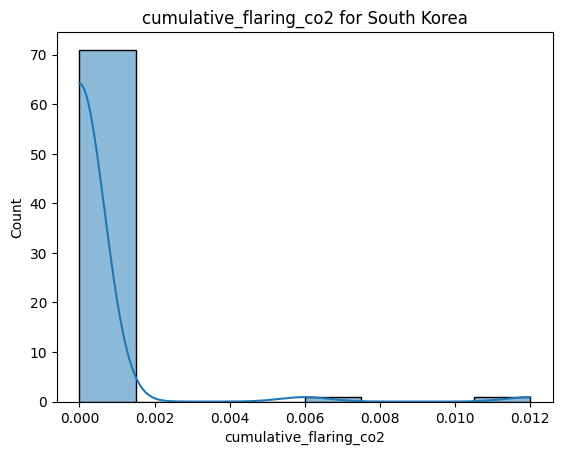

##########################################################################
count    73.000000
mean      1.456384
std       3.529256
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       1.111600
90%       5.703600
95%      10.013800
99%      14.865000
max      16.089000
Name: cumulative_gas_co2, dtype: float64


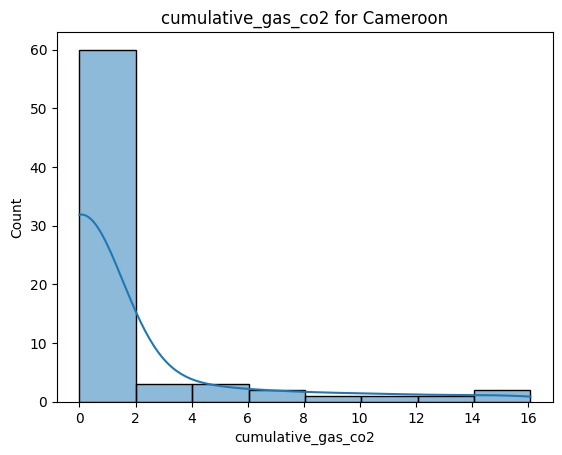

##########################################################################
count    73.000000
mean      0.001151
std       0.002277
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000200
70%       0.001400
80%       0.002000
90%       0.002000
95%       0.005200
99%       0.010560
max       0.012000
Name: cumulative_gas_co2, dtype: float64


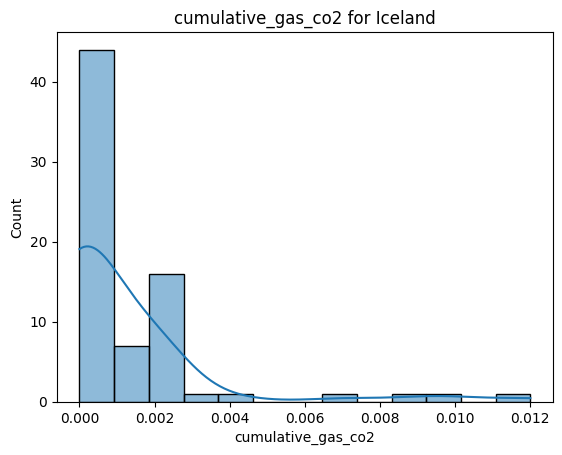

##########################################################################
count    73.000000
mean      0.173411
std       0.788123
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       0.000000
95%       0.596200
99%       4.165480
max       5.203000
Name: cumulative_gas_co2, dtype: float64


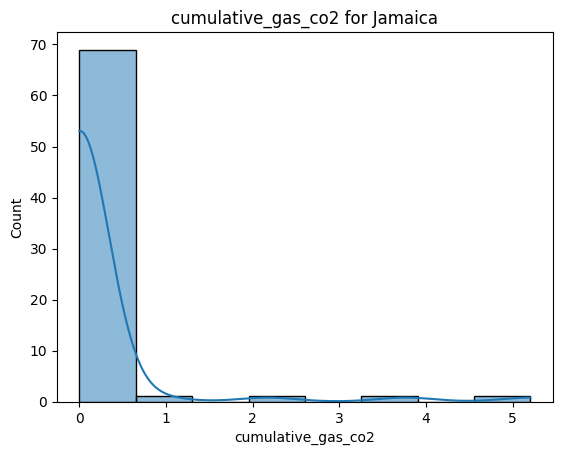

##########################################################################
count    73.000000
mean      0.191973
std       0.737141
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.001000
80%       0.001000
90%       0.001000
95%       1.517600
99%       3.626720
max       4.166000
Name: cumulative_gas_co2, dtype: float64


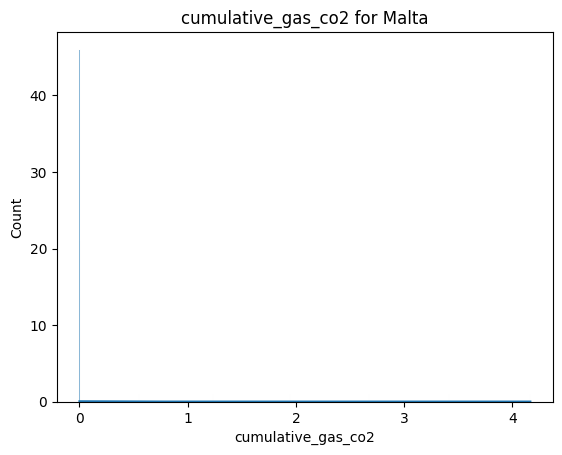

##########################################################################
count    73.000000
mean      0.010164
std       0.046946
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       0.000000
95%       0.029200
99%       0.245000
max       0.299000
Name: cumulative_gas_co2, dtype: float64


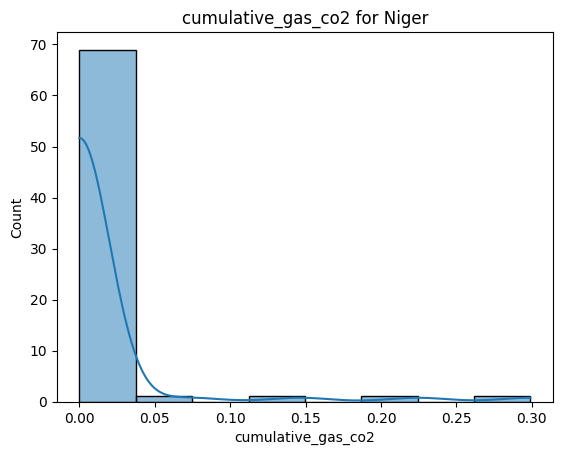

##########################################################################
count    73.000000
mean      0.068575
std       0.213671
min       0.000000
5%        0.000000
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.000000
80%       0.000000
90%       0.219400
95%       0.480200
99%       1.018360
max       1.153000
Name: cumulative_gas_co2, dtype: float64


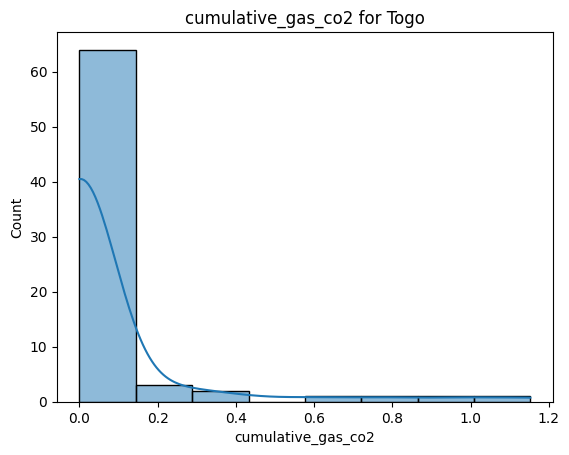

##########################################################################


In [19]:
def skewness_summary(dataframe, numerical_col, country, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe.loc[df["Entity"] == country, numerical_col].describe(quantiles).T)

    if plot:
        sns.histplot(dataframe.loc[df["Entity"] == country], x=numerical_col, kde=True)
        plt.xlabel(numerical_col)
        plt.title(f"{numerical_col} for {country}")
        plt.show()
        # dataframe.loc[df["Entity"] == country, numerical_col].hist(bins=50)
        # plt.xlabel(numerical_col)
        # plt.title(f"{numerical_col} for {country}")
        # plt.show()

    print("##########################################################################")


for country, columns in outliers.items():
  for col in columns:
    skewness_summary(df, col, country, plot = True)


### When outputs of the skewness_summary function is investigated, all num_cols variables have skewed distribution. To overcome this skewness, Outlier values might be suppressed by using interquartile method.

In [20]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean().apply(lambda x: f"{x / 1e6:.2f}e+07")}), end="\n\n\n")

target_summary_with_cat(df, "target", "Entity")

                                TARGET_MEAN
Entity                                     
Afghanistan                        3.16e+07
Africa                           676.29e+07
Albania                            4.00e+07
Algeria                           69.45e+07
Angola                             9.30e+07
Argentina                        113.54e+07
Asia                            7760.09e+07
Asia (excl. China and India)    3428.17e+07
Australia                        243.96e+07
Austria                           54.49e+07
Bahrain                           13.22e+07
Bangladesh                        24.24e+07
Barbados                           0.96e+07
Belgium                          111.08e+07
Benin                              1.77e+07
Bolivia                            7.95e+07
Brazil                           232.07e+07
Bulgaria                          52.12e+07
Burkina Faso                       1.11e+07
Burundi                            0.20e+07
Cameroon                        

# Preprocessing

### Aim of this part is to prepare dataframe for DL and ML algorithms. DL algorithms can easily be affected by non-scaled and outlier variables, because tey Since every numerical variable above basing on the country contains outlier values, these outliers must be suppressed.

In [21]:
                      ## This code block is used to fill NaN Values. ####
def fill_with_arima(data_frame):
  dataframe = data_frame.copy()
  for country in countries:
     for col in null_cols:
         missing_model = ARIMA(dataframe.loc[dataframe.Entity == country, col], order=(1,1,1)) # p, d,q = 1
         fitted = missing_model.fit()
         dataframe.loc[dataframe.Entity == country, col] = dataframe.loc[dataframe.Entity == country, col].fillna(pd.Series(fitted.fittedvalues))
  dataframe.to_csv("filled_with_arima.csv")
  return dataframe





In [22]:
pipeline_arima = Pipeline([
    ("fill_with_arima", FunctionTransformer(lambda x: fill_with_arima(x), validate=False))
])
pipeline_arima.fit(df)

Pipeline(steps=[('fill_with_arima',
                 FunctionTransformer(func=<function <lambda> at 0x7ccbee633560>))])

In [23]:
arima_filled_df = pipeline_arima.transform(df)
arima_filled_df.head()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be gene

Entity Code  Year    target  \
0  Afghanistan  AFG  1950   84272.0   
1  Afghanistan  AFG  1951   91600.0   
2  Afghanistan  AFG  1952   91600.0   
3  Afghanistan  AFG  1953  106256.0   
4  Afghanistan  AFG  1954  106256.0   

   Annual greenhouse gas emissions in CO₂ equivalents  \
0                                         18975016.0    
1                                         19921294.0    
2                                         20694344.0    
3                                         21577796.0    
4                                         22238252.0    

   Change in global mean surface temperature caused by greenhouse gas emissions  \
0                                           0.000501                              
1                                           0.000512                              
2                                           0.000523                              
3                                           0.000534                              
4                                           0.000546                              

   Annual CO₂ emissions per GDP (kg per international-$)  population  \
0                                           0.008945       7480464.0   
1                                           0.009451       7571542.0   
2                                           0.009144       7667534.0   
3                                           0.009995       7764549.0   
4                                           0.009778       7864289.0   

            gdp  cumulative_cement_co2  cumulative_co2  \
0  9.421400e+09                    0.0           0.099   
1  9.692280e+09                    0.0           0.191   
2  1.001733e+10                    0.0           0.282   
3  1.063052e+10                    0.0           0.388   
4  1.086636e+10                    0.0           0.495   

   cumulative_co2_including_luc  cumulative_coal_co2  cumulative_flaring_co2  \
0                        13.638                0.036                     0.0   
1                        21.870                0.061                     0.0   
2                        31.053                0.093                     0.0   
3                        41.309                0.131                     0.0   
4                        52.405                0.174                     0.0   

   cumulative_gas_co2  cumulative_luc_co2  cumulative_oil_co2  
0                 0.0             524.616               0.063  
1                 0.0             532.756               0.129  
2                 0.0             541.847               0.189  
3                 0.0             551.997               0.257  
4                 0.0             562.987               0.321

In [24]:
print(arima_filled_df.isnull().sum())

Entity                                                                             0
Code                                                                            1168
Year                                                                               0
target                                                                             0
Annual greenhouse gas emissions in CO₂ equivalents                                 0
Change in global mean surface temperature caused by greenhouse gas emissions       0
Annual CO₂ emissions per GDP (kg per international-$)                              0
population                                                                         0
gdp                                                                                0
cumulative_cement_co2                                                              0
cumulative_co2                                                                     0
cumulative_co2_including_luc                                     

In [25]:
def display_outliers(dataframe, num_col):
  detections = {}
  for col in num_cols:
    if col != "target": #target variable
      for country in countries:
        country_outlier = check_outlier(dataframe, col, country)
        if country_outlier is not None:
          if country_outlier in detections:
            detections[country_outlier].append(col)
          else:
            detections[country_outlier] = [col]

  print(detections)
  return detections


outliers_arima = display_outliers(arima_filled_df, num_cols)


{'Guatemala': ['Annual greenhouse gas emissions in CO₂ equivalents', 'cumulative_flaring_co2'], 'Kuwait': ['Annual greenhouse gas emissions in CO₂ equivalents', 'Annual CO₂ emissions per GDP (kg per international-$)'], 'Cape Verde': ['Annual CO₂ emissions per GDP (kg per international-$)', 'cumulative_coal_co2'], 'Equatorial Guinea': ['Annual CO₂ emissions per GDP (kg per international-$)'], 'Iran': ['Annual CO₂ emissions per GDP (kg per international-$)'], 'Mauritania': ['Annual CO₂ emissions per GDP (kg per international-$)'], 'Sierra Leone': ['Annual CO₂ emissions per GDP (kg per international-$)', 'cumulative_coal_co2'], 'Yemen': ['Annual CO₂ emissions per GDP (kg per international-$)'], 'Burkina Faso': ['cumulative_cement_co2', 'cumulative_coal_co2'], 'Burundi': ['cumulative_cement_co2'], 'Chad': ['cumulative_cement_co2', 'cumulative_coal_co2'], 'Congo': ['cumulative_cement_co2', 'cumulative_coal_co2', 'cumulative_gas_co2'], 'Djibouti': ['cumulative_cement_co2'], 'Myanmar': ['cumu

In [26]:
def replace_with_thresholds(dataframe, country, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, country)
    dataframe.loc[((dataframe.Entity == country) & (dataframe[variable] < low_limit)), variable] = low_limit
    dataframe.loc[((dataframe.Entity == country) & (dataframe[variable] > up_limit)), variable] = up_limit
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    # dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for country, columns in outliers_arima.items():
  for column in columns:
    replace_with_thresholds(arima_filled_df, country, column)





In [27]:
outliers_arima = display_outliers(arima_filled_df, num_cols)


{}


In [28]:
arima_filled_df.head()

Entity Code  Year    target  \
0  Afghanistan  AFG  1950   84272.0   
1  Afghanistan  AFG  1951   91600.0   
2  Afghanistan  AFG  1952   91600.0   
3  Afghanistan  AFG  1953  106256.0   
4  Afghanistan  AFG  1954  106256.0   

   Annual greenhouse gas emissions in CO₂ equivalents  \
0                                         18975016.0    
1                                         19921294.0    
2                                         20694344.0    
3                                         21577796.0    
4                                         22238252.0    

   Change in global mean surface temperature caused by greenhouse gas emissions  \
0                                           0.000501                              
1                                           0.000512                              
2                                           0.000523                              
3                                           0.000534                              
4                                           0.000546                              

   Annual CO₂ emissions per GDP (kg per international-$)  population  \
0                                           0.008945       7480464.0   
1                                           0.009451       7571542.0   
2                                           0.009144       7667534.0   
3                                           0.009995       7764549.0   
4                                           0.009778       7864289.0   

            gdp  cumulative_cement_co2  cumulative_co2  \
0  9.421400e+09                    0.0           0.099   
1  9.692280e+09                    0.0           0.191   
2  1.001733e+10                    0.0           0.282   
3  1.063052e+10                    0.0           0.388   
4  1.086636e+10                    0.0           0.495   

   cumulative_co2_including_luc  cumulative_coal_co2  cumulative_flaring_co2  \
0                        13.638                0.036                     0.0   
1                        21.870                0.061                     0.0   
2                        31.053                0.093                     0.0   
3                        41.309                0.131                     0.0   
4                        52.405                0.174                     0.0   

   cumulative_gas_co2  cumulative_luc_co2  cumulative_oil_co2  
0                 0.0             524.616               0.063  
1                 0.0             532.756               0.129  
2                 0.0             541.847               0.189  
3                 0.0             551.997               0.257  
4                 0.0             562.987               0.321

In [29]:
arima_filled_df[num_cols].describe().T

count          mean  \
target                                              10439.0  5.344202e+08   
Annual greenhouse gas emissions in CO₂ equivalents  10439.0  8.941713e+08   
Change in global mean surface temperature cause...  10439.0  2.392938e-02   
Annual CO₂ emissions per GDP (kg per internatio...  10439.0  3.609405e-01   
population                                          10439.0  1.067198e+08   
gdp                                                 10439.0  3.267990e+11   
cumulative_cement_co2                               10439.0  3.860742e+02   
cumulative_co2                                      10439.0  2.152839e+04   
cumulative_co2_including_luc                        10439.0  3.900555e+04   
cumulative_coal_co2                                 10439.0  1.211581e+04   
cumulative_flaring_co2                              10439.0  1.967561e+02   
cumulative_gas_co2                                  10439.0  2.320955e+03   
cumulative_luc_co2                                  10439.0  2.075254e+04   
cumulative_oil_co2                                  10439.0  6.439422e+03   

                                                             std  \
target                                              1.791972e+09   
Annual greenhouse gas emissions in CO₂ equivalents  2.615534e+09   
Change in global mean surface temperature cause...  6.847209e-02   
Annual CO₂ emissions per GDP (kg per internatio...  3.698279e-01   
population                                          3.852035e+08   
gdp                                                 1.300937e+12   
cumulative_cement_co2                               1.589357e+03   
cumulative_co2                                      7.749479e+04   
cumulative_co2_including_luc                        1.160873e+05   
cumulative_coal_co2                                 4.280106e+04   
cumulative_flaring_co2                              6.993549e+02   
cumulative_gas_co2                                  1.011523e+04   
cumulative_luc_co2                                  5.520299e+04   
cumulative_oil_co2                                  2.477558e+04   

                                                             min  \
target                                              0.000000e+00   
Annual greenhouse gas emissions in CO₂ equivalents -1.746612e+06   
Change in global mean surface temperature cause... -4.917105e-04   
Annual CO₂ emissions per GDP (kg per internatio...  0.000000e+00   
population                                          0.000000e+00   
gdp                                                 0.000000e+00   
cumulative_cement_co2                               0.000000e+00   
cumulative_co2                                      0.000000e+00   
cumulative_co2_including_luc                       -5.610000e-01   
cumulative_coal_co2                                 0.000000e+00   
cumulative_flaring_co2                              0.000000e+00   
cumulative_gas_co2                                  0.000000e+00   
cumulative_luc_co2                                 -4.409774e+03   
cumulative_oil_co2                                  0.000000e+00   

                                                             25%  \
target                                              2.192056e+06   
Annual greenhouse gas emissions in CO₂ equivalents  2.280079e+07   
Change in global mean surface temperature cause...  5.922184e-04   
Annual CO₂ emissions per GDP (kg per internatio...  1.389571e-01   
population                                          3.089422e+06   
gdp                                                 5.121399e+09   
cumulative_cement_co2                               7.915000e-01   
cumulative_co2                                      3.679950e+01   
cumulative_co2_including_luc                        4.156665e+02   
cumulative_coal_co2                                 2.240000e-01   
cumulative_flaring_co2                              0.000000e+00   
cumulative_gas_co2                      

In [30]:
arima_filled_df.to_csv("arima_filled_df.csv")


In [31]:
arima_filled_df = pd.read_csv("arima_filled_df.csv", index_col=0)

In [32]:
country = "Turkey"
arima_filled_df.loc[arima_filled_df.Entity == country, "target"].describe()


count    7.300000e+01
mean     1.590744e+08
std      1.376460e+08
min      9.488155e+06
25%      3.626549e+07
50%      1.156179e+08
75%      2.447686e+08
max      4.527028e+08
Name: target, dtype: float64

## Scaling

### After filling missing values, logarithmic transformation of target variable and suppression of outliers all numerical data must be scaled before modelling precces. In this project, I scale the data country-based approach.

In [33]:
num_cols = num_cols[1:]
num_cols

Index(['Annual greenhouse gas emissions in CO₂ equivalents',
       'Change in global mean surface temperature caused by greenhouse gas emissions',
       'Annual CO₂ emissions per GDP (kg per international-$)', 'population',
       'gdp', 'cumulative_cement_co2', 'cumulative_co2',
       'cumulative_co2_including_luc', 'cumulative_coal_co2',
       'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2',
       'cumulative_oil_co2'],
      dtype='object')

In [34]:
def split_data(data_frame, country, train_frac=0.6, val_frac=0.2):
    dataframe = data_frame.copy()
    dataframe = dataframe[dataframe["Entity"] == country]
    dataframe.set_index('Year', inplace=True)
    dataframe.drop(["Entity", "Code"], axis=1, inplace=True)
    n = len(dataframe)
    train_size = int(n * train_frac)
    val_size = int(n * val_frac)
    test_size = n - train_size - val_size
    train_df = dataframe[:train_size]
    val_df = dataframe[train_size:train_size+val_size]
    test_df = dataframe[train_size+val_size:]

    train_x = train_df.drop("target", axis=1)
    train_y = train_df["target"]

    val_x = val_df.drop("target", axis=1)
    val_y = val_df["target"]

    test_x = test_df.drop("target", axis=1)
    test_y = test_df["target"]
    return train_x, train_y, val_x, val_y, test_x, test_y, train_df, val_df, test_df



# New Section

In [35]:
main_train_x, main_train_y, main_val_x, main_val_y, main_test_x, main_test_y, train_df, val_df, test_df = \
 split_data(arima_filled_df, "Turkey")
train_df.tail()

target  Annual greenhouse gas emissions in CO₂ equivalents  \
Year                                                                    
1988  124727510.0                                        231501540.0    
1989  137569950.0                                        235271470.0    
1990  151614980.0                                        249251740.0    
1991  158126320.0                                        246318670.0    
1992  164064880.0                                        249460460.0    

      Change in global mean surface temperature caused by greenhouse gas emissions  \
Year                                                                                 
1988                                           0.004049                              
1989                                           0.004153                              
1990                                           0.004262                              
1991                                           0.004370                              
1992                                           0.004479                              

      Annual CO₂ emissions per GDP (kg per international-$)  population  \
Year                                                                      
1988                                           0.286153      52275892.0   
1989                                           0.310362      53305236.0   
1990                                           0.311477      54324140.0   
1991                                           0.317503      55321172.0   
1992                                           0.306620      56302040.0   

               gdp  cumulative_cement_co2  cumulative_co2  \
Year                                                        
1988  4.358770e+11                143.140        2115.715   
1989  4.432561e+11                153.364        2253.285   
1990  4.867612e+11                163.809        2404.900   
1991  4.980309e+11                175.829        2563.026   
1992  5.350757e+11                189.095        2727.091   

      cumulative_co2_including_luc  cumulative_coal_co2  \
Year                                                      
1988                      8322.494              980.631   
1989                      8483.260             1039.354   
1990                      8662.754             1109.558   
1991                      8835.902             1184.548   
1992                      9012.315             1259.629   

      cumulative_flaring_co2  cumulative_gas_co2  cumulative_luc_co2  \
Year                                                                   
1988                   0.000               4.932            6429.939   
1989                   0.000              10.406            6453.135   
1990                   0.220              18.053            6481.015   
1991                   0.484              27.197            6496.037   
1992                   0.737              37.124            6508.384   

      cumulative_oil_co2  
Year                      
1988             987.011  
1989            1050.161  
1990            1110.280  
1991            1169.069  
1992            1232.315

In [36]:
arima_filled_df.head(10)

Entity Code  Year    target  \
0  Afghanistan  AFG  1950   84272.0   
1  Afghanistan  AFG  1951   91600.0   
2  Afghanistan  AFG  1952   91600.0   
3  Afghanistan  AFG  1953  106256.0   
4  Afghanistan  AFG  1954  106256.0   
5  Afghanistan  AFG  1955  153888.0   
6  Afghanistan  AFG  1956  183200.0   
7  Afghanistan  AFG  1957  293120.0   
8  Afghanistan  AFG  1958  329760.0   
9  Afghanistan  AFG  1959  384571.0   

   Annual greenhouse gas emissions in CO₂ equivalents  \
0                                         18975016.0    
1                                         19921294.0    
2                                         20694344.0    
3                                         21577796.0    
4                                         22238252.0    
5                                         23214736.0    
6                                         24054062.0    
7                                         25035968.0    
8                                         26082448.0    
9                                         26784002.0    

   Change in global mean surface temperature caused by greenhouse gas emissions  \
0                                           0.000501                              
1                                           0.000512                              
2                                           0.000523                              
3                                           0.000534                              
4                                           0.000546                              
5                                           0.000559                              
6                                           0.000572                              
7                                           0.000586                              
8                                           0.000600                              
9                                           0.000615                              

   Annual CO₂ emissions per GDP (kg per international-$)  population  \
0                                           0.008945       7480464.0   
1                                           0.009451       7571542.0   
2                                           0.009144       7667534.0   
3                                           0.009995       7764549.0   
4                                           0.009778       7864289.0   
5                                           0.013891       7971933.0   
6                                           0.015819       8087730.0   
7                                           0.025315       8210207.0   
8                                           0.026944       8333827.0   
9                                           0.030570       8468220.0   

            gdp  cumulative_cement_co2  cumulative_co2  \
0  9.421400e+09                  0.000           0.099   
1  9.692280e+09                  0.000           0.191   
2  1.001733e+10                  0.000           0.282   
3  1.063052e+10                  0.000           0.388   
4  1.086636e+10                  0.000           0.495   
5  1.107819e+10                  0.000           0.649   
6  1.158124e+10                  0.000           0.832   
7  1.157897e+10                  0.000           1.125   
8  1.223884e+10                  0.000           1.455   
9  1.257987e+10                  0.018           1.839   

   cumulative_co2_including_luc  cumulative_coal_co2  cumulative_flaring_co2  \
0                        13.638                0.036                     0.0   
1                        21.870                0.061                     0.0   
2                        31.053                0.093                     0.0   
3                        41.309                0.131                     0.0   
4                        52.405                0.174                     0.0   
5                        64.614                0.236                     0.0   
6                        77.743             

In [37]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

def scale_and_split_data(dataframe, country, scaler_x, scaler_y):
  main_train_x, main_train_y, main_val_x, main_val_y, main_test_x, main_test_y, train_df, val_df, test_df = split_data(dataframe, country)

  main_train_x_scaled = scaler_x.fit_transform(main_train_x)
  main_train_y_scaled = scaler_y.fit_transform(main_train_y.values.reshape(-1, 1)).flatten()

  main_val_x_scaled = scaler_x.transform(main_val_x)
  main_val_y = scaler_y.transform(main_val_y.values.reshape(-1, 1)).flatten()

  main_test_x_scaled = scaler_x.transform(main_test_x)
  main_test_y_scaled = scaler_y.transform(main_test_y.values.reshape(-1, 1)).flatten()
  return(scaler_x, scaler_y, main_train_x_scaled,
         main_train_y_scaled, main_val_x_scaled,
         main_val_y, main_test_x_scaled, main_test_y_scaled,
         train_df, val_df, test_df)



In [38]:
scaler_x, scaler_y, main_train_x_scaled, main_train_y_scaled, main_val_x_scaled, main_val_y, main_test_x_scaled, main_test_y_Scaled, train_df, val_df, test_df = \
 scale_and_split_data(arima_filled_df, "Turkey", scaler_x, scaler_y)



In [39]:
joblib.dump(scaler_y, "scaler_y.joblib")
joblib.dump(scaler_x, "scaler_x.joblib")

['scaler_x.joblib']

In [40]:
print(main_train_y_scaled.shape)
print(main_train_y_scaled.shape)

print(main_val_x_scaled.shape)
print(main_val_y.shape)

print(main_test_x_scaled.shape)
print(main_test_y_Scaled.shape)

(43,)
(43,)
(14, 13)
(14,)
(16, 13)
(16,)


In [41]:
main_train_x_scaled

array([[0.        , 0.        , 0.2241644 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.03369756, 0.01297985, 0.13512062, 0.01534098, 0.01202433,
        0.00105026, 0.00400432, 0.02285442, 0.00749558, 0.        ,
        0.        , 0.03782915, 0.00153809],
       [0.05327575, 0.02663139, 0.        , 0.03161576, 0.02477075,
        0.00226128, 0.00812227, 0.04679434, 0.0148152 , 0.        ,
        0.        , 0.07751494, 0.00344344],
       [0.09702979, 0.04162754, 0.1538063 , 0.04849025, 0.03819068,
        0.00365984, 0.01322007, 0.07286422, 0.02408789, 0.        ,
        0.        , 0.12024555, 0.00562911],
       [0.11280064, 0.05720389, 0.24986576, 0.0648354 , 0.03523307,
        0.00552995, 0.01850188, 0.09916665, 0.03357822, 0.        ,
        0.        , 0.16324634, 0.0079334 ],
       [0.13774297, 0.07360062, 0.1381047 , 0.08050109, 0.04597704,
        0.00771086, 0.02385

#**Modelling**

### Since this dataset is a time series dataset; LSTM, GRU and LightGBM are used in modelling process.

In [42]:
test_predictions = {}

## LightGBM

In [43]:
def feature_extraction_for_lgbm(data_frame, column_list, country_list, lags=5, rolling=5, ewm_alphas = [0.95, 0.9, 0.8, 0.7, 0.5]):
  dataframe = data_frame.copy()
  for country in country_list:
    for col in column_list:
      for lag in range(2, lags+2):
        dataframe.loc[dataframe.Entity == country, str(col) + "_lag_" + str(lag)] = dataframe.loc[dataframe.Entity == country, col].shift(lag)

      for roll in range(2, rolling+2):
        dataframe.loc[dataframe.Entity == country, str(col) + "_rolling_mean_" + str(roll)] = dataframe.loc[dataframe.Entity == country, col].shift(1).rolling(window = roll).mean()

      for alpha in ewm_alphas:
        dataframe.loc[dataframe.Entity == country, str(col) + "_ewm_alpha_" + str(alpha)] = dataframe.loc[dataframe.Entity == country, col].shift(1).ewm(alpha = alpha).mean()
  return  dataframe


In [44]:
arima_lgb_df = feature_extraction_for_lgbm(arima_filled_df, num_cols, list(countries))
arima_lgb_df.head()

Entity Code  Year    target  \
0  Afghanistan  AFG  1950   84272.0   
1  Afghanistan  AFG  1951   91600.0   
2  Afghanistan  AFG  1952   91600.0   
3  Afghanistan  AFG  1953  106256.0   
4  Afghanistan  AFG  1954  106256.0   

   Annual greenhouse gas emissions in CO₂ equivalents  \
0                                         18975016.0    
1                                         19921294.0    
2                                         20694344.0    
3                                         21577796.0    
4                                         22238252.0    

   Change in global mean surface temperature caused by greenhouse gas emissions  \
0                                           0.000501                              
1                                           0.000512                              
2                                           0.000523                              
3                                           0.000534                              
4                                           0.000546                              

   Annual CO₂ emissions per GDP (kg per international-$)  population  \
0                                           0.008945       7480464.0   
1                                           0.009451       7571542.0   
2                                           0.009144       7667534.0   
3                                           0.009995       7764549.0   
4                                           0.009778       7864289.0   

            gdp  cumulative_cement_co2  cumulative_co2  \
0  9.421400e+09                    0.0           0.099   
1  9.692280e+09                    0.0           0.191   
2  1.001733e+10                    0.0           0.282   
3  1.063052e+10                    0.0           0.388   
4  1.086636e+10                    0.0           0.495   

   cumulative_co2_including_luc  cumulative_coal_co2  cumulative_flaring_co2  \
0                        13.638                0.036                     0.0   
1                        21.870                0.061                     0.0   
2                        31.053                0.093                     0.0   
3                        41.309                0.131                     0.0   
4                        52.405                0.174                     0.0   

   cumulative_gas_co2  cumulative_luc_co2  cumulative_oil_co2  \
0                 0.0             524.616               0.063   
1                 0.0             532.756               0.129   
2                 0.0             541.847               0.189   
3                 0.0             551.997               0.257   
4                 0.0             562.987               0.321   

   Annual greenhouse gas emissions in CO₂ equivalents_lag_2  \
0                                                NaN          
1                                                NaN          
2                                         18975016.0          
3                                         19921294.0          
4                                         20694344.0          

   Annual greenhouse gas emissions in CO₂ equivalents_lag_3  \
0                                                NaN          
1                                                NaN          
2                                                NaN          
3                                         18975016.0          
4                                         19921294.0          

   Annual greenhouse gas emissions in CO₂ equivalents_lag_4  \
0                                                NaN          
1                                                NaN          
2                                                NaN          
3                                                NaN          
4                                         18975016.0          

   Annual greenhouse gas emissions in CO₂ equivalents_lag_5  \
0                                                NaN          
1             

In [45]:
scaler_x_lgb = MinMaxScaler()
scaler_y_lgb = MinMaxScaler()

scaler_x_lgb, scaler_y_lgb, train_x_lgb_arima, train_y_lgb_arima, val_x_lgb_arima, val_y_lgb_arima, test_x_lgb_arima, test_y_lgb_arima, train_lgb_df, val_lgb_df, test_lgb_df = \
  scale_and_split_data(arima_lgb_df, "Turkey", scaler_x_lgb, scaler_y_lgb)



In [46]:

print("#############################")
print(train_x_lgb_arima.shape)
print(train_y_lgb_arima.shape)
print(val_x_lgb_arima.shape)
print(val_y_lgb_arima.shape)
print(test_x_lgb_arima.shape)
print(test_y_lgb_arima.shape)

#############################
(43, 208)
(43,)
(14, 208)
(14,)
(16, 208)
(16,)


In [47]:
display(train_lgb_df.head())

target  Annual greenhouse gas emissions in CO₂ equivalents  \
Year                                                                   
1950   9488155.0                                         72714740.0    
1951  10184316.0                                         78670640.0    
1952  10473534.0                                         82131000.0    
1953  12964756.0                                         89864340.0    
1954  13433034.0                                         92651770.0    

      Change in global mean surface temperature caused by greenhouse gas emissions  \
Year                                                                                 
1950                                           0.001143                              
1951                                           0.001186                              
1952                                           0.001232                              
1953                                           0.001282                              
1954                                           0.001334                              

      Annual CO₂ emissions per GDP (kg per international-$)  population  \
Year                                                                      
1950                                           0.216073      20977698.0   
1951                                           0.204431      21519608.0   
1952                                           0.186766      22094504.0   
1953                                           0.206874      22690584.0   
1954                                           0.219433      23267966.0   

               gdp  cumulative_cement_co2  cumulative_co2  \
Year                                                        
1950  4.391188e+10                  2.475         183.836   
1951  4.981780e+10                  2.671         194.020   
1952  5.607838e+10                  2.897         204.493   
1953  6.266977e+10                  3.158         217.458   
1954  6.121710e+10                  3.507         230.891   

      cumulative_co2_including_luc  cumulative_coal_co2  \
Year                                                      
1950                      3267.561              179.792   
1951                      3398.854              187.886   
1952                      3536.383              195.790   
1953                      3686.148              205.803   
1954                      3837.249              216.051   

      cumulative_flaring_co2  cumulative_gas_co2  cumulative_luc_co2  \
Year                                                                   
1950                     0.0                 0.0            3306.885   
1951                     0.0                 0.0            3427.995   
1952                     0.0                 0.0            3555.049   
1953                     0.0                 0.0            3691.851   
1954                     0.0                 0.0            3829.518   

      cumulative_oil_co2  \
Year                       
1950               1.569   
1951               3.462   
1952               5.807   
1953               8.497   
1954              11.333   

      Annual greenhouse gas emissions in CO₂ equivalents_lag_2  \
Year                                                             
1950                                                NaN          
1951                                                NaN          
1952                                         72714740.0          
1953                                         78670640.0          
1954                                         82131000.0          

      Annual greenhouse gas emissions in CO₂ equivalents_lag_3  \
Year                                                             
1950                                                NaN          
1951                                                NaN          
1952                                                NaN          
1953                                   

In [48]:
arima_lgb_df.head(30)

Entity Code  Year     target  \
0   Afghanistan  AFG  1950    84272.0   
1   Afghanistan  AFG  1951    91600.0   
2   Afghanistan  AFG  1952    91600.0   
3   Afghanistan  AFG  1953   106256.0   
4   Afghanistan  AFG  1954   106256.0   
5   Afghanistan  AFG  1955   153888.0   
6   Afghanistan  AFG  1956   183200.0   
7   Afghanistan  AFG  1957   293120.0   
8   Afghanistan  AFG  1958   329760.0   
9   Afghanistan  AFG  1959   384571.0   
10  Afghanistan  AFG  1960   413885.0   
11  Afghanistan  AFG  1961   490798.0   
12  Afghanistan  AFG  1962   688594.0   
13  Afghanistan  AFG  1963   706736.0   
14  Afghanistan  AFG  1964   838551.0   
15  Afghanistan  AFG  1965  1006917.0   
16  Afghanistan  AFG  1966  1091159.0   
17  Afghanistan  AFG  1967  1281865.0   
18  Afghanistan  AFG  1968  1223391.0   
19  Afghanistan  AFG  1969   941232.0   
20  Afghanistan  AFG  1970  1670397.0   
21  Afghanistan  AFG  1971  1893554.0   
22  Afghanistan  AFG  1972  1530347.0   
23  Afghanistan  AFG  1973  1635454.0   
24  Afghanistan  AFG  1974  1913152.0   
25  Afghanistan  AFG  1975  2121383.0   
26  Afghanistan  AFG  1976  1980859.0   
27  Afghanistan  AFG  1977  2384175.0   
28  Afghanistan  AFG  1978  2153300.0   
29  Afghanistan  AFG  1979  2232754.0   

    Annual greenhouse gas emissions in CO₂ equivalents  \
0                                          18975016.0    
1                                          19921294.0    
2                                          20694344.0    
3                                          21577796.0    
4                                          22238252.0    
5                                          23214736.0    
6                                          24054062.0    
7                                          25035968.0    
8                                          26082448.0    
9                                          26784002.0    
10                                         26956622.0    
11                                         24789736.0    
12                                         24341884.0    
13                                         24611200.0    
14                                         23775552.0    
15                                         24357436.0    
16                                         25177424.0    
17                                         24615444.0    
18                                         24447574.0    
19                                         23281454.0    
20                                         24025050.0    
21                                         23628110.0    
22                                         20597082.0    
23                                         20880964.0    
24                                         21516384.0    
25                                         22221378.0    
26                                         21971654.0    
27                                         21858144.0    
28                                         21220670.0    
29                                         20854984.0    

    Change in global mean surface temperature caused by greenhouse gas emissions  \
0                                            0.000501                              
1                                            0.000512                              
2                                            0.000523                              
3                                            0.000534                              
4                                            0.000546                              
5                                            0.000559                              
6                                            0.000572                              
7                                            0.000586                              
8                                            0.000600                              
9                                            0.000615                              
10            

In [49]:
arima_lgb_df.fillna(0, inplace=True)


In [50]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
}


In [51]:
train_x_lgb_arima.shape

(43, 208)

In [53]:
cols = list(arima_lgb_df.iloc[:, 4:].columns)
cols

['Annual greenhouse gas emissions in CO₂ equivalents',
 'Change in global mean surface temperature caused by greenhouse gas emissions',
 'Annual CO₂ emissions per GDP (kg per international-$)',
 'population',
 'gdp',
 'cumulative_cement_co2',
 'cumulative_co2',
 'cumulative_co2_including_luc',
 'cumulative_coal_co2',
 'cumulative_flaring_co2',
 'cumulative_gas_co2',
 'cumulative_luc_co2',
 'cumulative_oil_co2',
 'Annual greenhouse gas emissions in CO₂ equivalents_lag_2',
 'Annual greenhouse gas emissions in CO₂ equivalents_lag_3',
 'Annual greenhouse gas emissions in CO₂ equivalents_lag_4',
 'Annual greenhouse gas emissions in CO₂ equivalents_lag_5',
 'Annual greenhouse gas emissions in CO₂ equivalents_lag_6',
 'Annual greenhouse gas emissions in CO₂ equivalents_rolling_mean_2',
 'Annual greenhouse gas emissions in CO₂ equivalents_rolling_mean_3',
 'Annual greenhouse gas emissions in CO₂ equivalents_rolling_mean_4',
 'Annual greenhouse gas emissions in CO₂ equivalents_rolling_mean_5',


In [ ]:
def tune_lgbm_model(trainx, trainy, valx, valy, testx, testy, params, cols):
  cols = cols
  lgbtrain = lgb.Dataset(data=trainx, label=trainy, feature_name=cols)
  lgbval = lgb.Dataset(data=valx, label=valy, reference=lgbtrain, feature_name=cols)
  model = lgb.train(params, lgbtrain,
                    valid_sets=[lgbtrain, lgbval],
                    num_boost_round= 500,
                    )
  test_pred = model.predict(testx, num_iteration=model.best_iteration)
  val_pred = model.predict(valx, num_iteration=model.best_iteration)
  train_pred = model.predict(trainx)

  test_rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(testy.reshape(-1,1)),
                                    scaler_y.inverse_transform(test_pred.reshape(-1,1))))
  val_rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(valy.reshape(-1,1)),
                                    scaler_y.inverse_transform(val_pred.reshape(-1,1))))
  traim_rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(trainy.reshape(-1,1)),
                                    scaler_y.inverse_transform(train_pred.reshape(-1,1))))



  print("TEST RMSE: ", test_rmse)
  print("VAL RMSE: ", val_rmse)
  print("TRAIN RMSE: ", traim_rmse)
  return train_pred, val_pred, test_pred, traim_rmse, val_rmse, test_rmse

In [ ]:
train_pred_arima, val_pred_arima, test_pred_arima, train_rmse_arima, val_rmse_arima, test_rmse_arima = tune_lgbm_model(train_x_lgb_arima,
                                                                                                            train_y_lgb_arima,
                                                                                                            val_x_lgb_arima,
                                                                                                            val_y_lgb_arima,
                                                                                                            test_x_lgb_arima,
                                                                                                            test_y_lgb_arima,
                                                                                                            params=lgb_params, cols = cols)


##LSTM (Long Short Term Memory)

In [211]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_x, scaler_y, train_x_arima, train_y_arima, val_x_arima, val_y_arima, test_x_arima, test_y_arima,train_lstm, val_lstm, test_lstm = \
 scale_and_split_data(arima_filled_df, "Turkey",scaler_x, scaler_y)





In [157]:
def create_timewindow(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys), time_steps

In [158]:
train_x_arima.shape

(43, 13)

In [159]:
def prepare_data(train_x, train_y, val_x, val_y, test_x, test_y, time_steps = 5):
  X_train, y_train, time_steps = create_timewindow(train_x, train_y, time_steps = 5)
  X_val, y_val, time_steps = create_timewindow(val_x, val_y, time_steps = 5)
  X_test, y_test, time_steps = create_timewindow(test_x, test_y, time_steps = 5)
  return X_train, y_train, X_val, y_val, X_test, y_test



In [160]:
x_train_arima, y_train_arima, x_val_arima, y_val_arima, x_test_arima, y_test_arima = prepare_data(train_x_arima,
                                                                                                  train_y_arima,
                                                                                                  val_x_arima,
                                                                                                  val_y_arima,
                                                                                                  test_x_arima,
                                                                                                  test_y_arima)



In [161]:
x_train_arima[:3]

array([[[0.        , 0.        , 0.2241644 , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.03369756, 0.01297985, 0.13512062, 0.01534098, 0.01202433,
         0.00105026, 0.00400432, 0.02285442, 0.00749558, 0.        ,
         0.        , 0.03782915, 0.00153809],
        [0.05327575, 0.02663139, 0.        , 0.03161576, 0.02477075,
         0.00226128, 0.00812227, 0.04679434, 0.0148152 , 0.        ,
         0.        , 0.07751494, 0.00344344],
        [0.09702979, 0.04162754, 0.1538063 , 0.04849025, 0.03819068,
         0.00365984, 0.01322007, 0.07286422, 0.02408789, 0.        ,
         0.        , 0.12024555, 0.00562911],
        [0.11280064, 0.05720389, 0.24986576, 0.0648354 , 0.03523307,
         0.00552995, 0.01850188, 0.09916665, 0.03357822, 0.        ,
         0.        , 0.16324634, 0.0079334 ]],

       [[0.03369756, 0.01297985, 0.13512062, 0.01534098, 0.01202433,
         

In [162]:
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# window_size = 5
# batch_size = 8
# generator_train = TimeseriesGenerator(train_x.values,
#                                       train_y.values,
#                                       length = window_size,
#                                       batch_size = batch_size)

# generator_val = TimeseriesGenerator(val_x.values,
#                                       val_y.values,
#                                       length = window_size,
#                                       batch_size = batch_size)

# generator_test = TimeseriesGenerator(test_x.values,
#                                       test_y.values,
#                                       length = window_size,
#                                       batch_size = batch_size)

In [163]:
model = keras.models.Sequential([
    keras.layers.LSTM(units = 32, return_sequences = False,
                      input_shape = (x_train_arima.shape[1], x_train_arima.shape[2])), # units => memory size , input_shape => (window size, number of features)
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units = 10, activation = "relu"),
    keras.layers.Dense(units = 1)
])


model.summary()

Model: "sequential_157"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_147 (LSTM)                      │ (None, 32)                  │           5,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_381 (Dropout)                │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_314 (Dense)                    │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_315 (Dense)                    │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,229 (24.33 KB)

 Trainable params: 6,229 (24.33 KB)

 Non-trainable params: 0 (0.00 B)

In [164]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)


model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mse'])


In [165]:
start_time = datetime.datetime.now()

history = model.fit(x_train_arima,
                    y_train_arima,
                    epochs=18,
                    validation_data = (x_val_arima, y_val_arima),
                    )

end_time = datetime.datetime.now()

total_duration = end_time - start_time
print("Training Time:", total_duration)

Epoch 1/18
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.1847 - mse: 0.1847 - val_loss: 2.3480 - val_mse: 2.3480
Epoch 2/18
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1717 - mse: 0.1717 - val_loss: 2.2492 - val_mse: 2.2492
Epoch 3/18
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1172 - mse: 0.1172 - val_loss: 2.1398 - val_mse: 2.1398
Epoch 4/18
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0679 - mse: 0.0679 - val_loss: 1.9724 - val_mse: 1.9724
Epoch 5/18
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0666 - mse: 0.0666 - val_loss: 1.7576 - val_mse: 1.7576
Epoch 6/18
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0459 - mse: 0.0459 - val_loss: 1.5430 - val_mse: 1.5430
Epoch 7/18
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0450 - mse: 0.0450 - val_loss: 1.3640 - val_mse: 1.3640
Epoch 8/18
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0489 - mse: 0.0489 - val_loss: 1.2322 - val_mse: 1.2322
Epoch 9/18
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0432 - mse: 0.0432 -

In [166]:
def plot_training_history(history, train_loss='loss', train_metric='mse', val_loss='val_loss', val_metric='val_mse'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

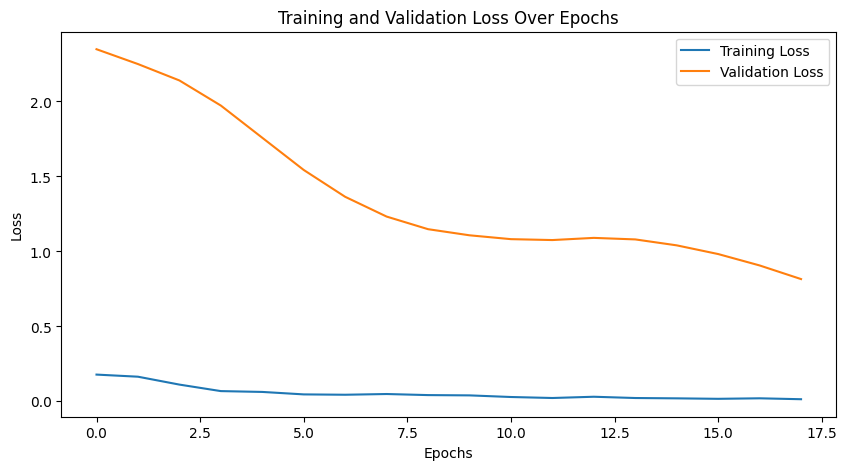

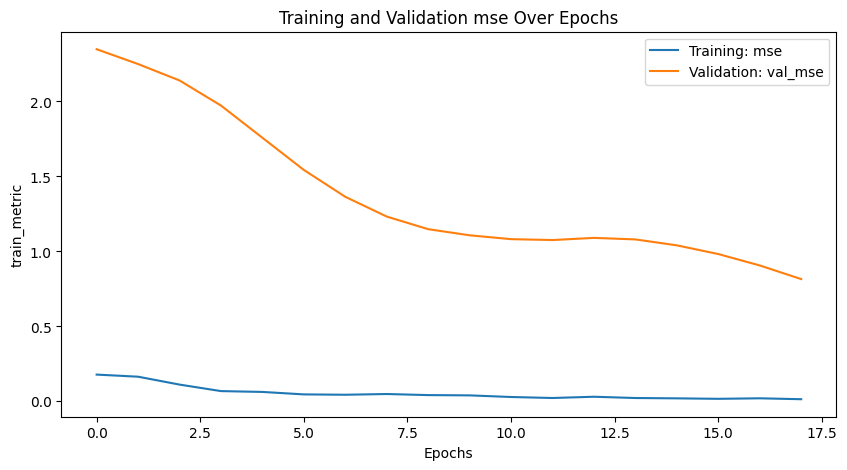

In [167]:
plot_training_history(history)

In [168]:
def evaluate_predictions(model, X_train, y_train, X_val, y_val, X_test, y_test):

    y_train_pred_ = model.predict(X_train, verbose=0)
    y_val_pred = model.predict(X_val, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)

    true_y_train_pred = scaler_y.inverse_transform(y_train_pred_.reshape(-1,1))
    true_y_val_pred = scaler_y.inverse_transform(y_val_pred.reshape(-1,1))
    true_y_test_pred = scaler_y.inverse_transform(y_test_pred.reshape(-1,1))

    true_y_train = scaler_y.inverse_transform(y_train.reshape(-1,1))
    true_y_val = scaler_y.inverse_transform(y_val.reshape(-1,1))
    true_y_test = scaler_y.inverse_transform(y_test.reshape(-1,1))


    train_rmse = np.sqrt(mean_squared_error(true_y_train, true_y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(true_y_val, true_y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(true_y_test, true_y_test_pred))
    print("Train RMSE:", train_rmse, "Validation RMSE:", val_rmse, "Test RMSE:", test_rmse)
    return true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_rmse, val_rmse, test_rmse

In [169]:
true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse = \
evaluate_predictions(model, x_train_arima, y_train_arima, x_val_arima, y_val_arima, x_test_arima, y_test_arima)

Train RMSE: 13080611.23558003 Validation RMSE: 139588076.41143432 Test RMSE: 393229724.18591505


In [71]:
test_predictions["LSTM_before"] = test_mse

In [72]:
pd.DataFrame(np.column_stack((true_y_train, true_y_train_pred)), columns=["True Target Values", "Predicted Target Values"]).describe()

True Target Values  Predicted Target Values
count        3.800000e+01             3.800000e+01
mean         6.568946e+07             8.211505e+07
std          4.471141e+07             3.867763e+07
min          1.361942e+07             2.886751e+07
25%          2.656546e+07             4.745899e+07
50%          6.011932e+07             7.779497e+07
75%          8.891165e+07             1.119853e+08
max          1.640649e+08             1.593974e+08

In [170]:
def plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps):
    plt.figure(dpi=200)
    plt.figure(figsize=(30, 10))
    # Train
    train_time = train_lstm.index[time_steps:]
    plt.plot(train_time, true_y_train, label='True Values (Train)', color='blue')
    plt.plot(train_time, true_y_train_pred, '--', label='Predicted Values (Train)', color='red')

    # Validation
    val_time = val_lstm.index[time_steps:]
    plt.plot(val_time, true_y_val, label='True Values (Validation)', color='green')
    plt.plot(val_time, true_y_val_pred, '--', label='Predicted Values (Validation)', color='orange')

    # Test
    test_time = test_lstm.index[time_steps:]
    plt.plot(test_time, true_y_test, label='True Values (Test)', color='purple')
    plt.plot(test_time, true_y_test_pred, '--', label='Predicted Values (Test)', color='pink')

    # Metrics
    plt.text(train_time.min(), true_y_train.max()*1.03, f"Train RMSE: {np.sqrt(train_mse):.4f}", fontsize=12)
    plt.text(train_time.min(), true_y_train.max()*0.98, f"Validation RMSE: {np.sqrt(val_mse):.4f}", fontsize=12)
    plt.text(train_time.min(), true_y_train.max()*0.93, f"Test RMSE: {np.sqrt(test_mse):.4f}", fontsize=12)

    plt.title('Actual and Predicted Values for All Data Sets')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

<Figure size 1280x960 with 0 Axes>

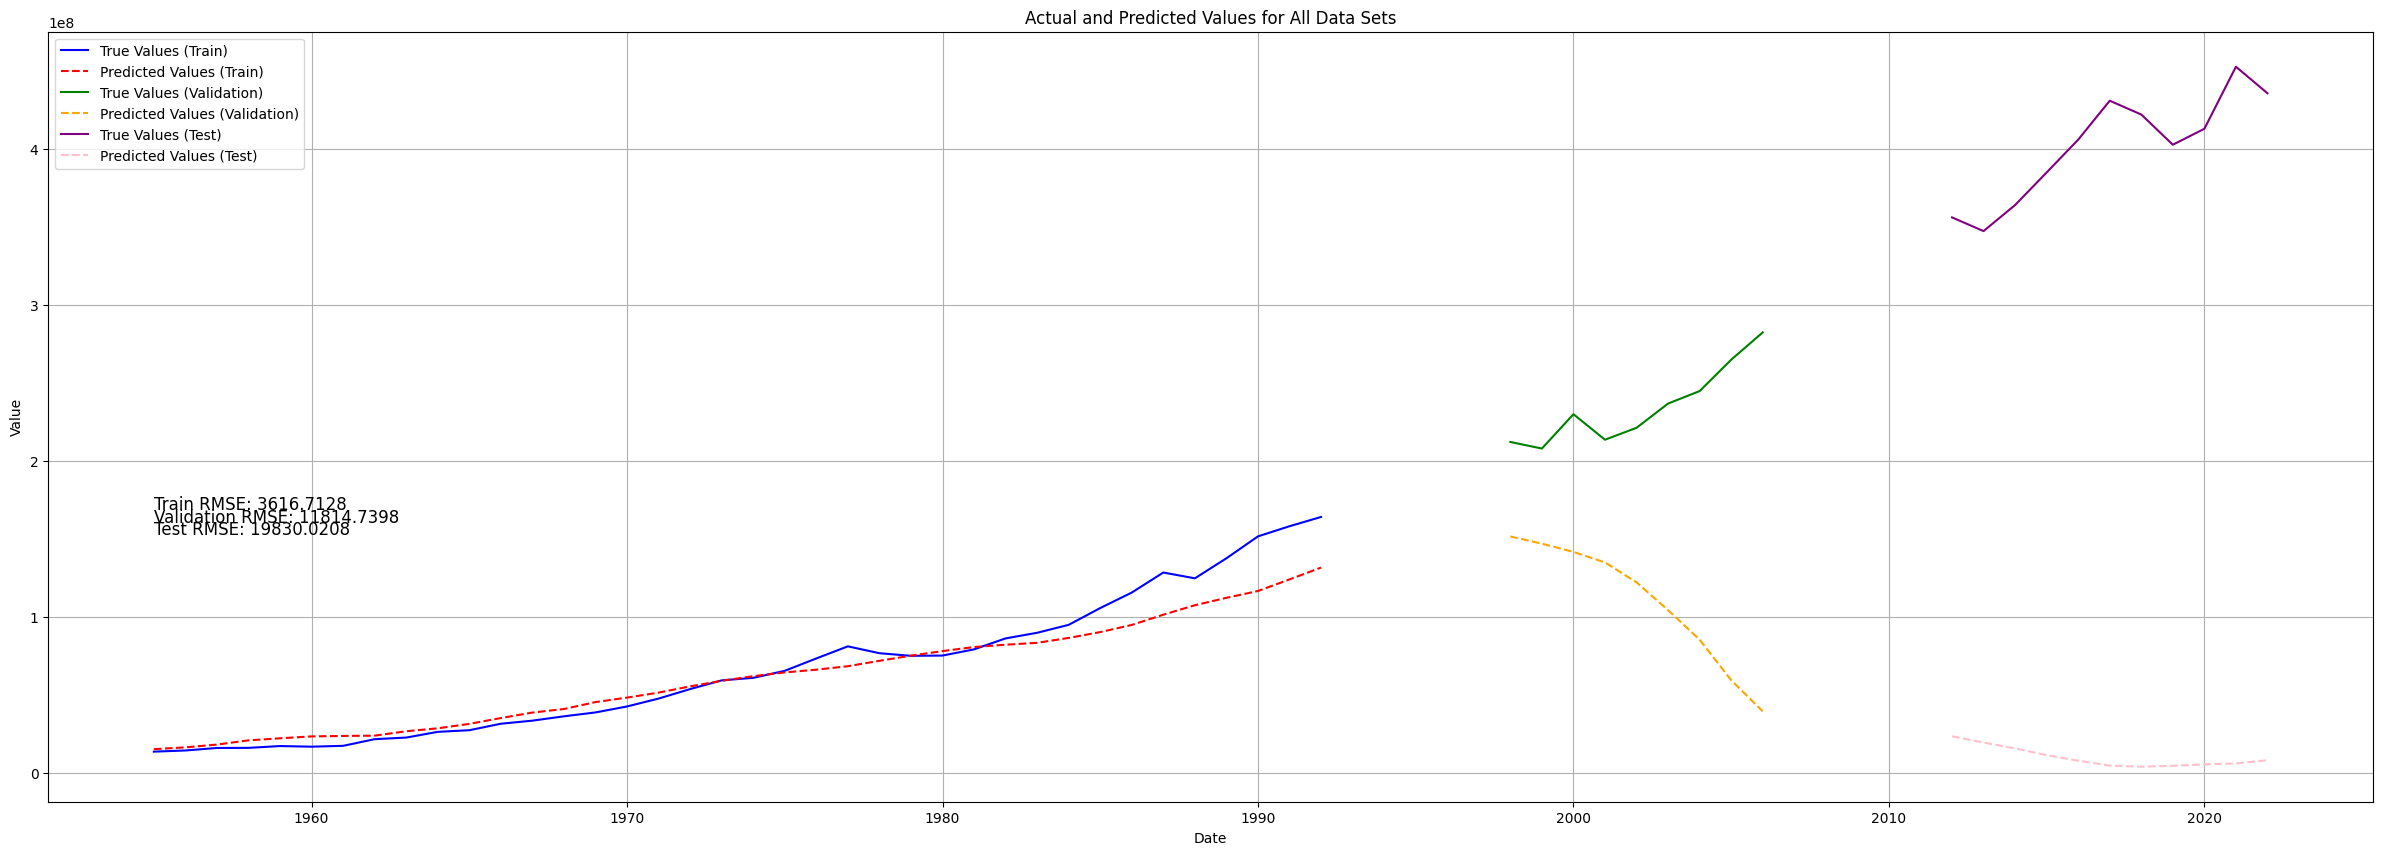

In [171]:
plot_predictions_with_metrics(train_x_arima, val_x_arima, test_x_arima,
                              true_y_train, true_y_train_pred,
                              true_y_val, true_y_val_pred, true_y_test,
                              true_y_test_pred, train_mse, val_mse, test_mse,
                              5)

## GRU (Gated Recurrent Unit)

In [75]:
gru_model = keras.models.Sequential([
    keras.layers.GRU(units = 32, return_sequences = False,
                      input_shape = (x_train_arima.shape[1], x_train_arima.shape[2])), # units => memory size , input_shape => (window size, number of features)
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units = 10, activation = "relu"),
    keras.layers.Dense(units = 1)
])



optimizer = keras.optimizers.Adam(learning_rate=0.001)


gru_model.compile(optimizer = optimizer,
                  loss = "mean_squared_error",
                  metrics = ["mse"])

gru_model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 32)                  │           4,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,853 (18.96 KB)

 Trainable params: 4,853 (18.96 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
gru_history = gru_model.fit(x_train_arima,
                            y_train_arima,
                            validation_data = (x_val_arima, y_val_arima),
                            callbacks = [early_stopping],
                            epochs = 50)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 522ms/step - loss: 0.0697 - mse: 0.0697 - val_loss: 1.0745 - val_mse: 1.0745
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0479 - mse: 0.0479 - val_loss: 0.8510 - val_mse: 0.8510
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0247 - mse: 0.0247 - val_loss: 0.7446 - val_mse: 0.7446
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.6893 - val_mse: 0.6893
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.6215 - val_mse: 0.6215
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.5500 - val_mse: 0.5500
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.4715 - val_mse: 0.4715
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.3915 - val_mse: 0.3915
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0112 - mse: 0.0112 -

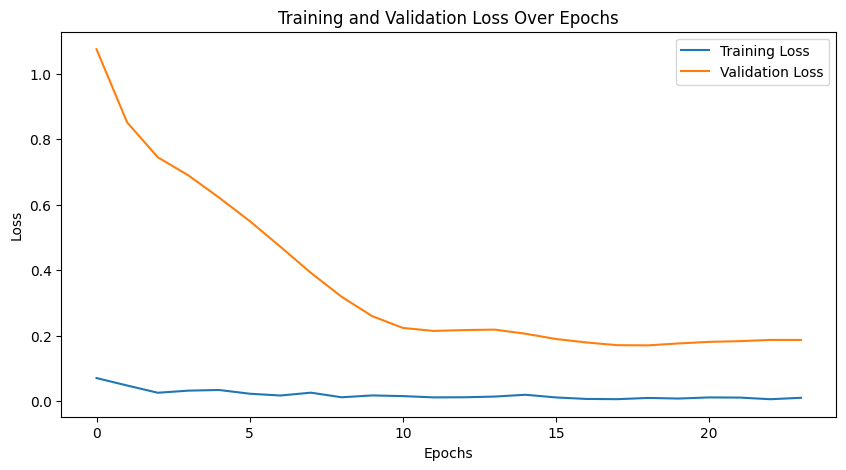

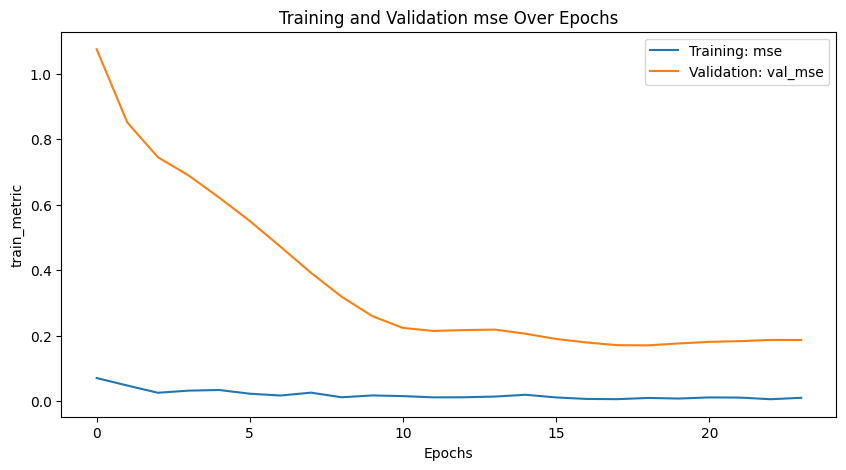

In [77]:
plot_training_history(gru_history)

In [78]:
true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse = \
 evaluate_predictions(gru_model, x_train_arima, y_train_arima, x_val_arima, y_val_arima, x_test_arima, y_test_arima)

Train RMSE: 5234460.939996935 Validation RMSE: 63765907.71972766 Test RMSE: 335861428.9812333


In [79]:
test_predictions["GRU_before"] = test_mse

In [80]:
# Train MSE: 150343487528.69067 Validation MSE: 198964808874.80408 Test MSE: 338606004871.2522
pd.DataFrame(np.column_stack((true_y_train, true_y_train_pred)), columns=["True Target Values", "Predicted Target Values"]).describe()

True Target Values  Predicted Target Values
count        3.800000e+01             3.800000e+01
mean         6.568946e+07             6.735428e+07
std          4.471141e+07             4.476647e+07
min          1.361942e+07             1.308331e+07
25%          2.656546e+07             2.800168e+07
50%          6.011932e+07             5.742419e+07
75%          8.891165e+07             9.925445e+07
max          1.640649e+08             1.724237e+08

<Figure size 1280x960 with 0 Axes>

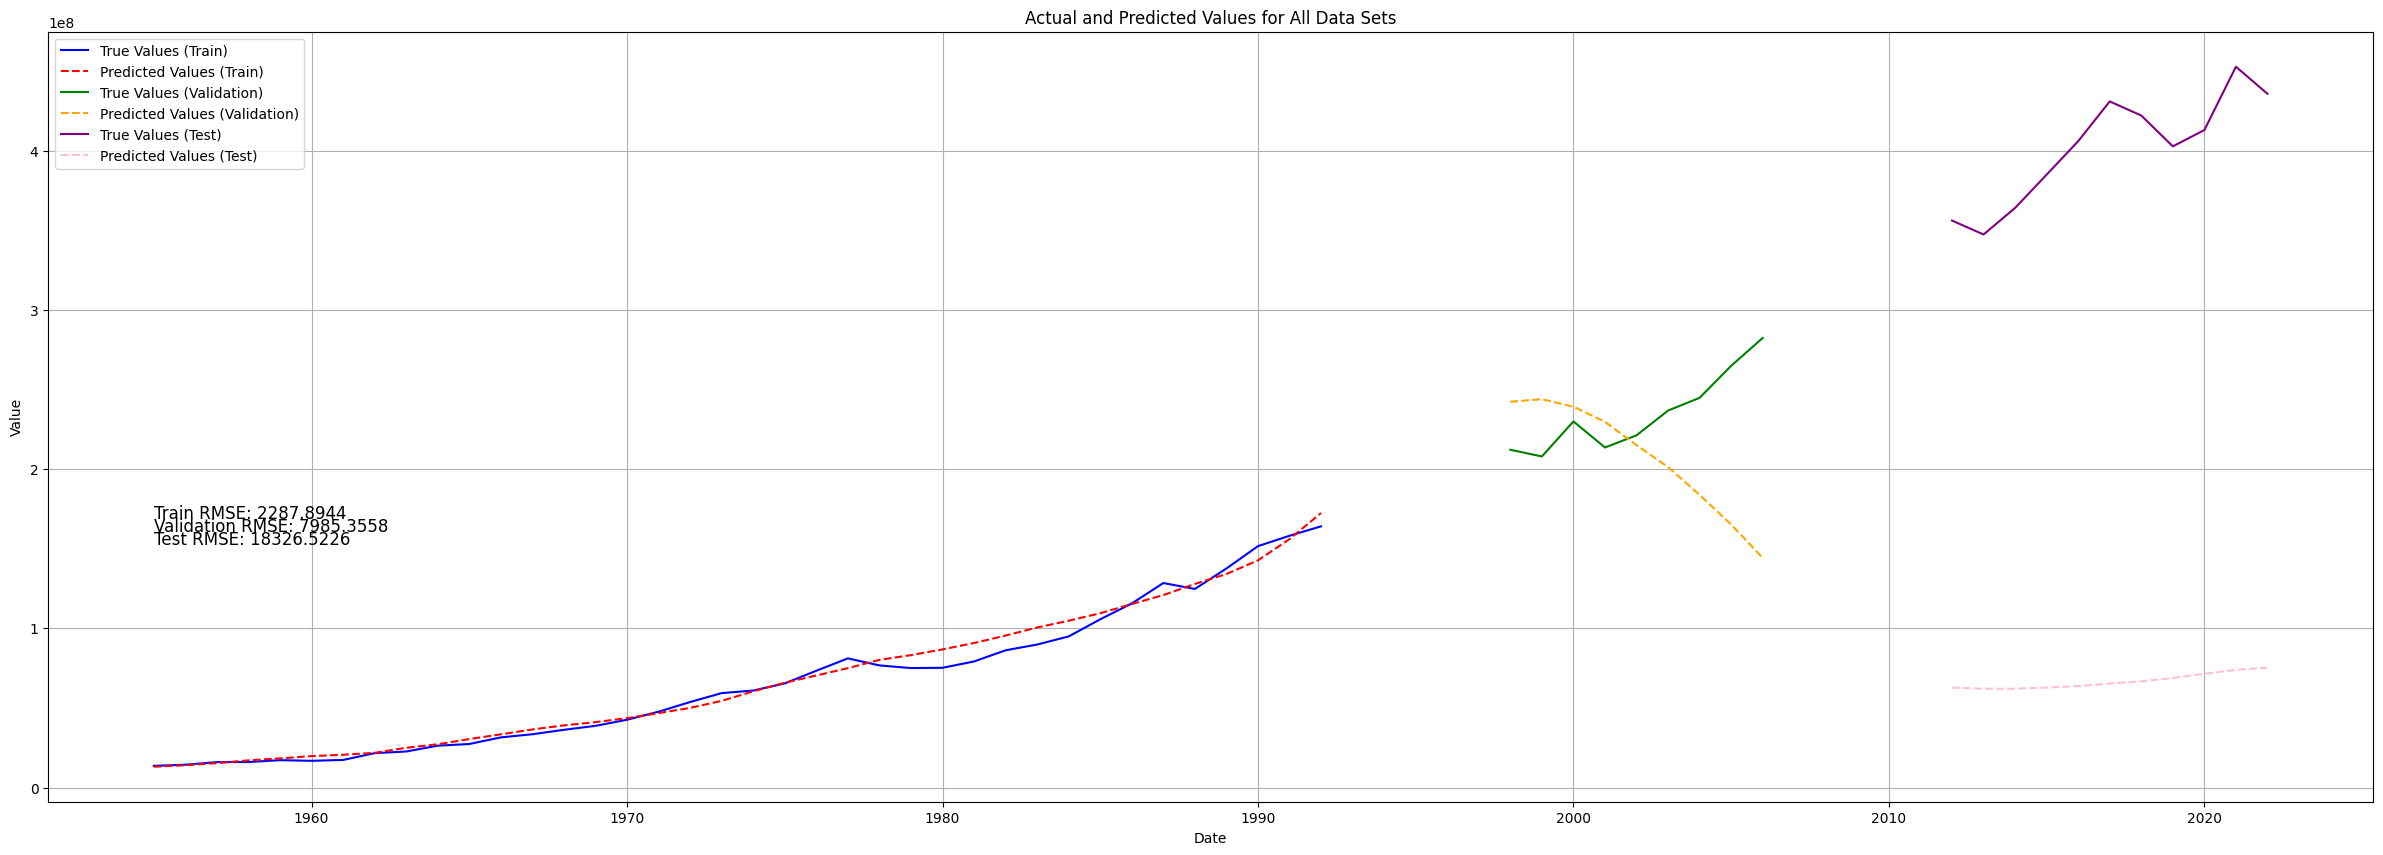

In [81]:
plot_predictions_with_metrics(train_x_arima, val_x_arima, test_x_arima,
                              true_y_train, true_y_train_pred, true_y_val,
                              true_y_val_pred, true_y_test, true_y_test_pred,
                              train_mse, val_mse, test_mse, time_steps=5)

In [82]:
gru_model.evaluate(x_test_arima, y_test_arima)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.7210 - mse: 4.7210


[4.720978736877441, 4.720978736877441]

### Information criteria - bayesian akaike

In [83]:
def calculate_aic_bic(model, X, y):
    n = len(X)  # Örnek sayısı
    loss = model.evaluate(X, y, verbose=0)[0] # loss metric, MSE
    log_likelihood = -n * loss  # Negatif log-olasılık yaklaşık olarak
    k = model.count_params()    # Parametre sayısı

    aic = 2 * k - 2 * log_likelihood
    bic = k * np.log(n) - 2 * log_likelihood
    return aic, bic

aic_gru, bic_gru = calculate_aic_bic(gru_model, x_test_arima, y_test_arima)
aic_lstm, bic_lstm = calculate_aic_bic(model, x_test_arima, y_test_arima)
print("LSTM AIC:", aic_lstm)
print("LSTM BIC:", bic_lstm)
print("GRU AIC:", aic_gru)
print("GRU BIC:", bic_gru)

LSTM AIC: 12591.466203689575
LSTM BIC: 15069.955857950627
GRU AIC: 9809.861532211304
GRU BIC: 11740.847291101796


In [84]:
true_y_test_pred.reshape(1,-1)[0]

array([62737796., 62084464., 62076268., 62794480., 63783976., 65290564.,
       66696548., 68826264., 71409688., 73943824., 75317424.],
      dtype=float32)

In [85]:
true_y_test

array([[3.5610720e+08],
       [3.4733174e+08],
       [3.6402830e+08],
       [3.8492966e+08],
       [4.0595020e+08],
       [4.3090086e+08],
       [4.2205862e+08],
       [4.0269226e+08],
       [4.1292688e+08],
       [4.5270280e+08],
       [4.3568460e+08]])

## VAR (Vector AutoRegression)

In [86]:
def make_stationary(dataframe):
  for column in dataframe.columns:
    result = adfuller(dataframe[column]) # adfuller test to check stationary
    while result[1] >= 0.05:
      dataframe[column] = dataframe[column].diff().dropna()
      result = adfuller(dataframe[column].dropna())
      print(f'{column}: p-value = {result[1]}')
  dataframe.dropna(inplace=True)


def split_var_data(data_frame, country, train_frac=0.6, val_frac=0.2):
    dataframe = data_frame.copy()
    dataframe = dataframe[dataframe["Entity"] == country]
    dataframe.set_index('Year', inplace=True)
    dataframe.drop(["Entity", "Code"], axis=1, inplace=True)
    n = len(dataframe)
    train_size = int(n * train_frac)
    val_size = int(n * val_frac)
    test_size = n - train_size - val_size
    train_df = dataframe[:train_size]
    val_df = dataframe[train_size:train_size+val_size]
    test_df = dataframe[train_size+val_size:]

    return train_df, val_df, test_df


def load_var_data(data_frame, target_countries, country):
  dataframe = data_frame.copy()
  train_var_df, val_var_df, test_var_df = split_var_data(dataframe, country)


  make_stationary(train_var_df)
  make_stationary(val_var_df)
  make_stationary(test_var_df)


  return train_var_df, val_var_df, test_var_df


train_var_df, val_var_df, test_var_df = load_var_data(arima_filled_df, countries, "Turkey")

target: p-value = 0.00027408386890363795
Annual greenhouse gas emissions in CO₂ equivalents: p-value = 3.4135150938709574e-07
Change in global mean surface temperature caused by greenhouse gas emissions: p-value = 0.5751376681419746
Change in global mean surface temperature caused by greenhouse gas emissions: p-value = 6.766154281245095e-10
Annual CO₂ emissions per GDP (kg per international-$): p-value = 2.6296818797985733e-12
population: p-value = 0.7866317502524109
population: p-value = 0.48414142164976115
population: p-value = 0.0061484159080388455
gdp: p-value = 0.4515580723779349
gdp: p-value = 0.006812957290134531
cumulative_cement_co2: p-value = 0.9990773287970959
cumulative_cement_co2: p-value = 0.0006662449610223653
cumulative_co2: p-value = 1.0
cumulative_co2: p-value = 0.0002667235095559502
cumulative_co2_including_luc: p-value = 0.004193091956564897
cumulative_coal_co2: p-value = 1.0
cumulative_coal_co2: p-value = 0.0005297978704364812
cumulative_flaring_co2: p-value = 0.97

In [87]:
train_var_df

target  Annual greenhouse gas emissions in CO₂ equivalents  \
Year                                                                   
1956    739535.0                                          5526640.0    
1957   1610971.0                                          6146740.0    
1958     64939.0                                          4844856.0    
1959   1156936.0                                          4238004.0    
1960   -393268.0                                        -12459080.0    
1961    542302.0                                          5416920.0    
1962   4263708.0                                         25189220.0    
1963   1035396.0                                        -11234760.0    
1964   3663020.0                                          1630990.0    
1965   1049994.0                                          7411540.0    
1966   4152804.0                                         -2163390.0    
1967   1973354.0                                         16950480.0    
1968   2786376.0                                         29555360.0    
1969   2487206.0                                        -21072430.0    
1970   3826532.0                                          4908160.0    
1971   5058928.0                                         13762870.0    
1972   6083684.0                                        -13064610.0    
1973   5588160.0                                         -4687280.0    
1974   1618644.0                                         -9175330.0    
1975   4490686.0                                          2302500.0    
1976   7940070.0                                         11621080.0    
1977   7761320.0                                          9519200.0    
1978  -4406850.0                                         17869040.0    
1979  -1676030.0                                        -17540520.0    
1980    174430.0                                         -5944580.0    
1981   3973720.0                                         -9025380.0    
1982   7024040.0                                          3481000.0    
1983   3602154.0                                         27162200.0    
1984   5093846.0                                         -1248000.0    
1985  10756320.0                                          3440150.0    
1986   9955520.0                                         29836190.0    
1987  12824314.0                                          2867330.0    
1988  -3714674.0                                          8376210.0    
1989  12842440.0                                          3769930.0    
1990  14045030.0                                         13980270.0    
1991   6511340.0                                         -2933070.0    
1992   5938560.0                                          3141790.0    

      Change in global mean surface temperature caused by greenhouse gas emissions  \
Year                                                                                 
1956                                       3.335300e-06                              
1957                                       3.957300e-06                              
1958                                       2.965200e-06                              
1959                                       2.616000e-06                              
1960                                      -4.874800e-06                              
1961                                       1.591000e-06                              
1962                                       1.108410e-05                              
1963                                      -5.649500e-06                              
1964                                       6.697000e-07                              
1965                                       4.070800e-06                              
1966                                      -2.601000e-07                              
1967                                       8.466500e-06                            

In [88]:
from statsmodels.tsa.api import VAR

var_model = VAR(train_var_df)
var_results = var_model.fit(maxlags=5)

train_forecast = var_results.forecast(train_var_df.values[-5:], steps=len(train_var_df))
train_forecast_df = pd.DataFrame(train_forecast, columns=train_var_df.columns)



val_forecast = var_results.forecast(train_var_df.values[-5:], steps=len(val_var_df))
val_forecast_df = pd.DataFrame(val_forecast, columns=val_var_df.columns)
print("Validation Forecast:\n", val_forecast_df)

test_forecast = var_results.forecast(pd.concat([train_var_df, val_var_df]).values[-5:], steps=len(test_var_df))
test_forecast_df = pd.DataFrame(test_forecast, columns=test_var_df.columns)
print("Test Forecast:\n", test_forecast_df)

val_forecast_final = scaler_y.inverse_transform(val_forecast_df.target.values.reshape(-1, 1))
test_forecast_final = scaler_y.inverse_transform(test_forecast_df.target.values.reshape(-1, 1))
train_forecast_final = scaler_y.inverse_transform(train_forecast_df.target.values.reshape(-1, 1))

train_final = scaler_y.inverse_transform(train_var_df.target.values.reshape(-1, 1))
val_final = scaler_y.inverse_transform(val_var_df.target.values.reshape(-1, 1))
test_final = scaler_y.inverse_transform(test_var_df.target.values.reshape(-1, 1))

train_mse = mean_squared_error(train_final, train_forecast_final)
val_mse = mean_squared_error(val_final, val_forecast_final)
test_mse = mean_squared_error(test_final, test_forecast_final)
print(f"Train RMSE (VAR): {np.sqrt(train_mse)}")
print(f"Validation RMSE (VAR): {np.sqrt(val_mse)}")
print(f"Test RMSE (VAR): {np.sqrt(test_mse)}")


Validation Forecast:
          target  Annual greenhouse gas emissions in CO₂ equivalents  \
0 -5.877836e+06                                      -1.453815e+08    
1  3.702756e+07                                       1.333284e+08    
2  3.905659e+06                                       7.124653e+07    
3  8.307520e+06                                      -1.969822e+08    
4 -1.861516e+07                                       3.049770e+08    
5  2.977042e+07                                      -3.332550e+08    
6  8.702305e+07                                       3.847463e+08    
7 -9.098935e+07                                       1.083197e+08    
8  6.943251e+06                                      -8.310190e+08    

   Change in global mean surface temperature caused by greenhouse gas emissions  \
0                                          -0.000068                              
1                                           0.000063                              
2                 

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [89]:
test_predictions["VAR_before"] = np.sqrt(test_mse)

In [90]:
def plot_var_val():
    plt.figure(dpi=200)
    plt.figure(figsize=(30, 10))
    # Validation

    x_var = val_var_df.index
    x_test = test_var_df.index
    plt.plot(x_var, val_final.reshape(1, -1)[0], label='True Values (Validation)', color='green')
    plt.plot(x_var, val_forecast_final.reshape(1, -1)[0], '--', label='Predicted Values (Validation)', color='orange')
    plt.plot(x_test, test_final.reshape(1, -1)[0], label='True Values (Test)', color='purple')
    plt.plot(x_test, test_forecast_final.reshape(1, -1)[0], '--', label='Predicted Values (Test)', color='pink')
    plt.title('Actual and Predicted Values for Validation and Test')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


<Figure size 1280x960 with 0 Axes>

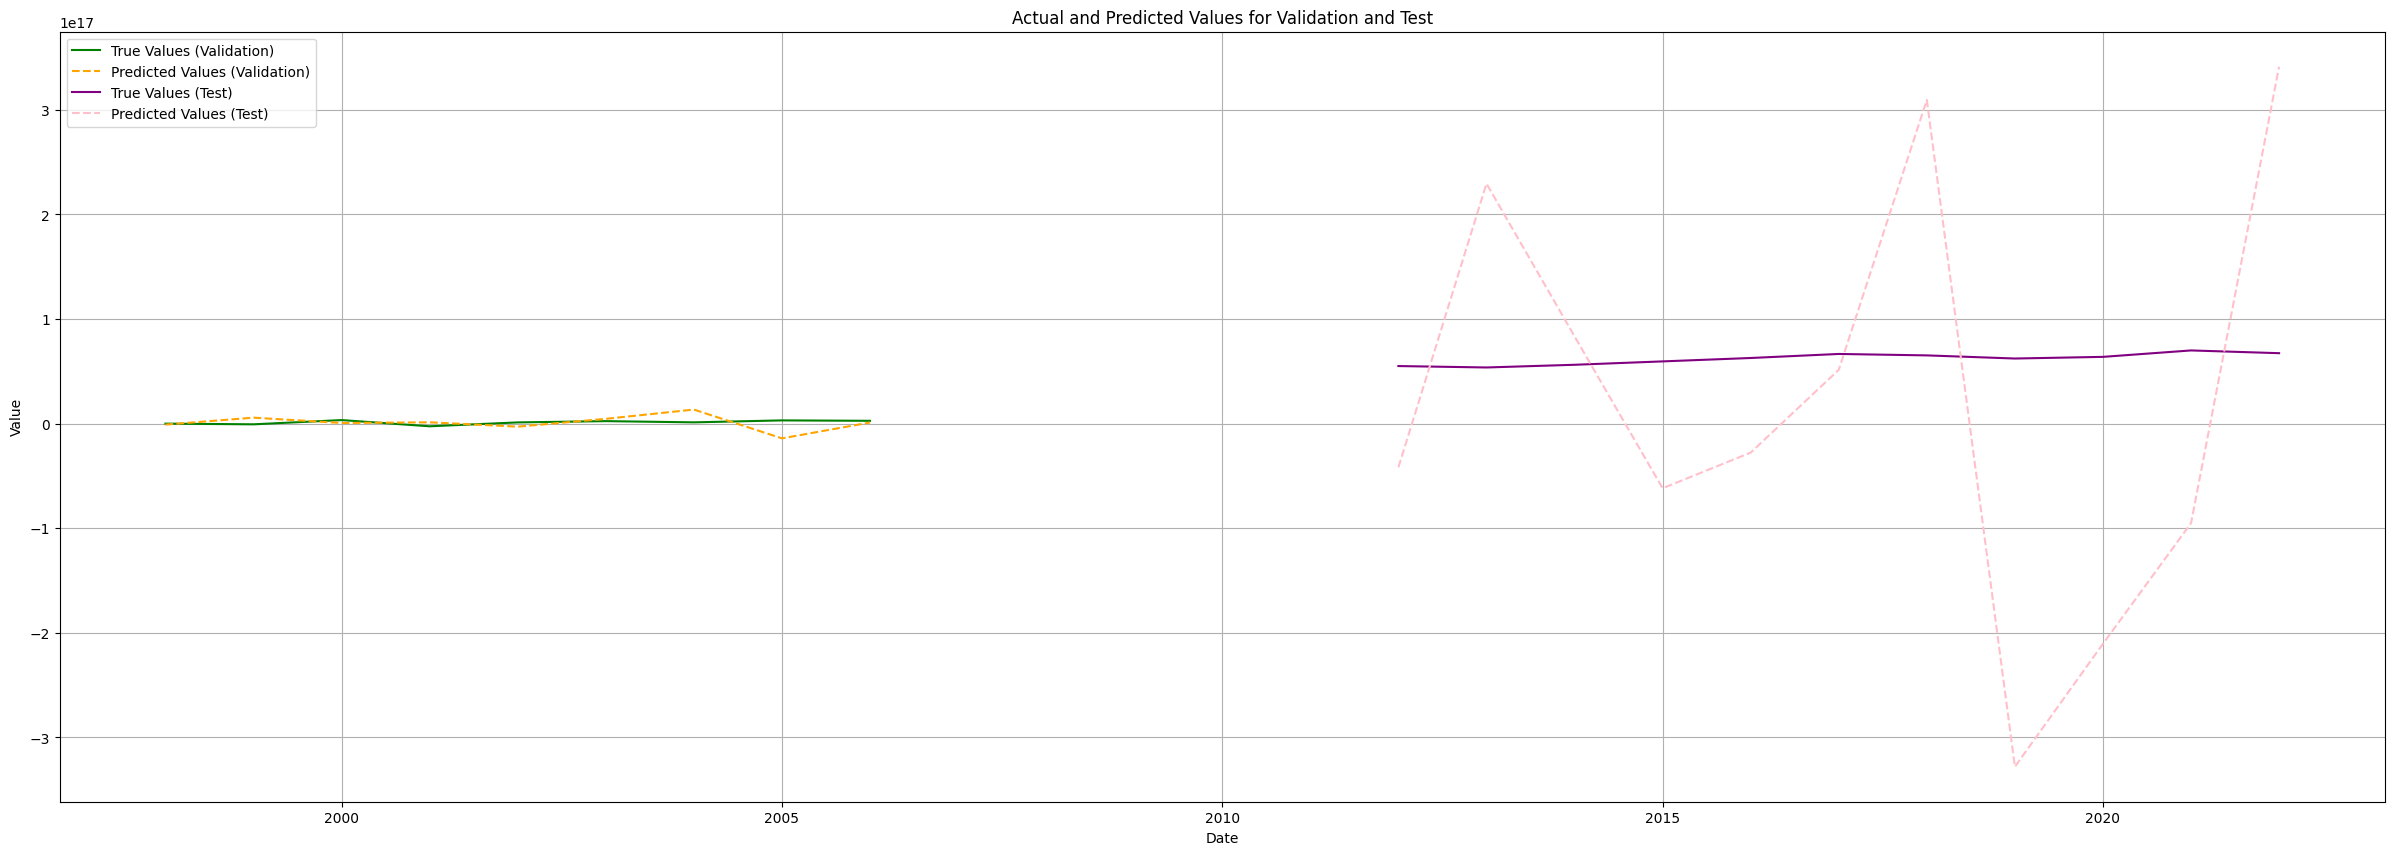

In [91]:
plot_var_val()


In [92]:
x_train_arima[:3]

array([[[0.        , 0.        , 0.2241644 , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.03369756, 0.01297985, 0.13512062, 0.01534098, 0.01202433,
         0.00105026, 0.00400432, 0.02285442, 0.00749558, 0.        ,
         0.        , 0.03782915, 0.00153809],
        [0.05327575, 0.02663139, 0.        , 0.03161576, 0.02477075,
         0.00226128, 0.00812227, 0.04679434, 0.0148152 , 0.        ,
         0.        , 0.07751494, 0.00344344],
        [0.09702979, 0.04162754, 0.1538063 , 0.04849025, 0.03819068,
         0.00365984, 0.01322007, 0.07286422, 0.02408789, 0.        ,
         0.        , 0.12024555, 0.00562911],
        [0.11280064, 0.05720389, 0.24986576, 0.0648354 , 0.03523307,
         0.00552995, 0.01850188, 0.09916665, 0.03357822, 0.        ,
         0.        , 0.16324634, 0.0079334 ]],

       [[0.03369756, 0.01297985, 0.13512062, 0.01534098, 0.01202433,
         

#Hyperparameter Tuning

##LightGBM

In [93]:
def objective(trial):

  lgbtrain = lgb.Dataset(data=train_x_lgb_arima, label=train_y_lgb_arima, feature_name=cols)
  lgbval = lgb.Dataset(data=val_x_lgb_arima, label=val_y_lgb_arima, reference=lgbtrain, feature_name=cols)

  lgb_params = {'num_leaves': trial.suggest_int("num_leaves", 2, 10, step = 1),
                'learning_rate': trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True),
                'feature_fraction': trial.suggest_float("feature_fraction", 0.8, 1, step = 0.1),
                'max_depth': trial.suggest_int("max_depth", 2, 15, step = 1),
                'verbose': 0,
                'nthread': -1,
                "metric": "rmse"}

  model_lgbm = lgb.train(lgb_params, lgbtrain,
                    valid_sets=[lgbval],
                    )

  val_y_lgb_arima_pred = model_lgbm.predict( val_x_lgb_arima)
  rmse = np.sqrt(mean_squared_error(val_y_lgb_arima.reshape(1,-1),
                                    val_y_lgb_arima_pred.reshape(1,-1)))

  return rmse

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 150)

[I 2025-01-20 13:35:39,360] A new study created in memory with name: no-name-0e387305-498e-4210-a44a-bdaba8a1ed80
[I 2025-01-20 13:35:39,457] Trial 0 finished with value: 0.8022253053499142 and parameters: {'num_leaves': 4, 'learning_rate': 0.022473251126801222, 'feature_fraction': 0.8, 'max_depth': 3}. Best is trial 0 with value: 0.8022253053499142.
[I 2025-01-20 13:35:39,525] Trial 1 finished with value: 0.8151884894064372 and parameters: {'num_leaves': 6, 'learning_rate': 0.019528031489181554, 'feature_fraction': 0.8, 'max_depth': 8}. Best is trial 0 with value: 0.8022253053499142.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:39,577] Trial 2 finished with value: 1.029983637511519 and parameters: {'num_leaves': 3, 'learning_rate': 0.0005442632842111587, 'feature_fraction': 0.8, 'max_depth': 10}. Best is trial 0 with value: 0.8022253053499142.
[I 2025-01-20 13:35:39,660] Trial 3 finished with value: 0.8409171951528461 and parameters: {'num_leaves': 4, 'learning_rate': 0.015119520778385064, 'feature_fraction': 1.0, 'max_depth': 4}. Best is trial 0 with value: 0.8022253053499142.
[I 2025-01-20 13:35:39,719] Trial 4 finished with value: 1.0410577357475166 and parameters: {'num_leaves': 10, 'learning_rate': 0.00010212693214247033, 'feature_fraction': 0.8, 'max_depth': 2}. Best is trial 0 with value: 0.8022253053499142.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 13:35:39,779] Trial 5 finished with value: 1.0139043888773367 and parameters: {'num_leaves': 6, 'learning_rate': 0.0012231867164252956, 'feature_fraction': 0.9, 'max_depth': 4}. Best is trial 0 with value: 0.8022253053499142.
[I 2025-01-20 13:35:39,824] Trial 6 finished with value: 0.7470733305877001 and parameters: {'num_leaves': 2, 'learning_rate': 0.08802117680094586, 'feature_fraction': 0.8, 'max_depth': 7}. Best is trial 6 with value: 0.7470733305877001.
[I 2025-01-20 13:35:39,886] Trial 7 finished with value: 1.0356161426500583 and parameters: {'num_leaves': 9, 'learning_rate': 0.0003169413417571086, 'feature_fraction': 1.0, 'max_depth': 8}. Best is trial 6 with value: 0.7470733305877001.
[I 2025-01-20 13:35:39,969] Trial 8 finished with value: 0.9783589133376378 and parameters: {'num_leaves': 3, 'learning_rate': 0.002927129219996212, 'feature_fraction': 1.0, 'max_depth': 4}. Best is trial 6 with value: 0.7470733305877001.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-01-20 13:35:40,044] Trial 9 finished with value: 0.9913563410147435 and parameters: {'num_leaves': 7, 'learning_rate': 0.0022613946320677683, 'feature_fraction': 1.0, 'max_depth': 11}. Best is trial 6 with value: 0.7470733305877001.
[I 2025-01-20 13:35:40,088] Trial 10 finished with value: 1.0433386003949108 and parameters: {'num_leaves': 2, 'learning_rate': 1.3441458973084725e-05, 'feature_fraction': 0.9, 'max_depth': 15}. Best is trial 6 with value: 0.7470733305877001.
[I 2025-01-20 13:35:40,172] Trial 11 finished with value: 0.7477439446386851 and parameters: {'num_leaves': 4, 'learning_rate': 0.08550950119536764, 'feature_fraction': 0.8, 'max_depth': 6}. Best is trial 6 with value: 0.7470733305877001.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-01-20 13:35:40,224] Trial 12 finished with value: 0.7466339117401973 and parameters: {'num_leaves': 2, 'learning_rate': 0.0990825049192505, 'feature_fraction': 0.9, 'max_depth': 6}. Best is trial 12 with value: 0.7466339117401973.
[I 2025-01-20 13:35:40,270] Trial 13 finished with value: 0.7487689352819582 and parameters: {'num_leaves': 2, 'learning_rate': 0.06329300629568214, 'feature_fraction': 0.9, 'max_depth': 7}. Best is trial 12 with value: 0.7466339117401973.
[I 2025-01-20 13:35:40,333] Trial 14 finished with value: 0.9166274574945622 and parameters: {'num_leaves': 2, 'learning_rate': 0.007002434583953224, 'feature_fraction': 0.9, 'max_depth': 11}. Best is trial 12 with value: 0.7466339117401973.
[I 2025-01-20 13:35:40,430] Trial 15 finished with value: 0.7486166989099579 and parameters: {'num_leaves': 5, 'learning_rate': 0.08197044729752499, 'feature_fraction': 0.9, 'max_depth': 6}. Best is trial 12 with value: 0.7466339117401973.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-01-20 13:35:40,518] Trial 16 finished with value: 0.9290015326126305 and parameters: {'num_leaves': 8, 'learning_rate': 0.006016828161747271, 'feature_fraction': 0.8, 'max_depth': 13}. Best is trial 12 with value: 0.7466339117401973.
[I 2025-01-20 13:35:40,602] Trial 17 finished with value: 0.773577207092749 and parameters: {'num_leaves': 3, 'learning_rate': 0.03299430935528841, 'feature_fraction': 0.9, 'max_depth': 6}. Best is trial 12 with value: 0.7466339117401973.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:40,683] Trial 18 finished with value: 1.0426845235538538 and parameters: {'num_leaves': 5, 'learning_rate': 3.8793194028689694e-05, 'feature_fraction': 0.9, 'max_depth': 9}. Best is trial 12 with value: 0.7466339117401973.
[I 2025-01-20 13:35:40,726] Trial 19 finished with value: 0.911313010239096 and parameters: {'num_leaves': 2, 'learning_rate': 0.00741907810309233, 'feature_fraction': 0.8, 'max_depth': 5}. Best is trial 12 with value: 0.7466339117401973.
[I 2025-01-20 13:35:40,808] Trial 20 finished with value: 0.7607786190926809 and parameters: {'num_leaves': 5, 'learning_rate': 0.03976199948573002, 'feature_fraction': 1.0, 'max_depth': 7}. Best is trial 12 with value: 0.7466339117401973.
[I 2025-01-20 13:35:40,891] Trial 21 finished with value: 0.7465333906516914 and parameters: {'num_leaves': 4, 'learning_rate': 0.09944528765099192, 'feature_fraction': 0.8, 'max_depth': 6}. Best is trial 21 with value: 0.7465333906516914.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-01-20 13:35:41,010] Trial 22 finished with value: 0.7464635016775788 and parameters: {'num_leaves': 3, 'learning_rate': 0.09964309548268999, 'feature_fraction': 0.8, 'max_depth': 9}. Best is trial 22 with value: 0.7464635016775788.
[I 2025-01-20 13:35:41,095] Trial 23 finished with value: 0.852979471413658 and parameters: {'num_leaves': 3, 'learning_rate': 0.013413835375600048, 'feature_fraction': 0.8, 'max_depth': 9}. Best is trial 22 with value: 0.7464635016775788.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:41,196] Trial 24 finished with value: 0.7603278862830362 and parameters: {'num_leaves': 4, 'learning_rate': 0.0397182002031488, 'feature_fraction': 0.8, 'max_depth': 10}. Best is trial 22 with value: 0.7464635016775788.
[I 2025-01-20 13:35:41,280] Trial 25 finished with value: 0.7424636121122273 and parameters: {'num_leaves': 3, 'learning_rate': 0.09865427230608824, 'feature_fraction': 0.8, 'max_depth': 5}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:41,407] Trial 26 finished with value: 0.7531315004006958 and parameters: {'num_leaves': 5, 'learning_rate': 0.04713729379267762, 'feature_fraction': 0.8, 'max_depth': 5}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:41,486] Trial 27 finished with value: 0.8604212624819653 and parameters: {'num_leaves': 3, 'learning_rate': 0.012404063111767663, 'feature_fraction': 0.8, 'max_depth': 2}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-01-20 13:35:41,560] Trial 28 finished with value: 0.7868640094790079 and parameters: {'num_leaves': 4, 'learning_rate': 0.027510088795285673, 'feature_fraction': 0.8, 'max_depth': 13}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:41,658] Trial 29 finished with value: 0.9740809376347263 and parameters: {'num_leaves': 4, 'learning_rate': 0.00315648095611367, 'feature_fraction': 0.8, 'max_depth': 3}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:41,742] Trial 30 finished with value: 0.7973001241905839 and parameters: {'num_leaves': 7, 'learning_rate': 0.023918807652001616, 'feature_fraction': 0.8, 'max_depth': 5}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 13:35:41,835] Trial 31 finished with value: 0.7468543995776931 and parameters: {'num_leaves': 3, 'learning_rate': 0.09558817374806948, 'feature_fraction': 0.9, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:41,912] Trial 32 finished with value: 0.7508476418801939 and parameters: {'num_leaves': 3, 'learning_rate': 0.051111471006446224, 'feature_fraction': 0.8, 'max_depth': 8}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:41,957] Trial 33 finished with value: 0.8034379634087552 and parameters: {'num_leaves': 2, 'learning_rate': 0.022179790200817697, 'feature_fraction': 0.8, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:42,074] Trial 34 finished with value: 0.752036674368028 and parameters: {'num_leaves': 3, 'learning_rate': 0.049280940996760024, 'feature_fraction': 0.9, 'max_depth': 3}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:42,156] Trial 35 finished with value: 0.8593254933650704 and parameters: {'num_leaves': 4, 'learning_rate': 0.012542584583220218, 'feature_fraction': 0.8, 'max_depth': 10}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:42,252] Trial 36 finished with value: 1.0343653999434124 and parameters: {'num_leaves': 6, 'learning_rate': 0.0003669753873484279, 'feature_fraction': 0.8, 'max_depth': 5}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:42,315] Trial 37 finished with value: 0.7470342133399978 and parameters: {'num_leaves': 2, 'learning_rate': 0.09310132308792175, 'feature_fraction': 0.8, 'max_depth': 8}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:42,406] Trial 38 finished with value: 0.8224407630432431 and parameters: {'num_leaves': 3, 'learning_rate': 0.01809717969439161, 'feature_fraction': 0.9, 'max_depth': 4}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 13:35:42,478] Trial 39 finished with value: 1.0241958461826919 and parameters: {'num_leaves': 4, 'learning_rate': 0.0007833658779543465, 'feature_fraction': 0.8, 'max_depth': 9}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:42,575] Trial 40 finished with value: 1.0402972347024828 and parameters: {'num_leaves': 5, 'learning_rate': 0.00013187275467233873, 'feature_fraction': 1.0, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:42,657] Trial 41 finished with value: 0.7459300882025741 and parameters: {'num_leaves': 3, 'learning_rate': 0.06577706740609436, 'feature_fraction': 0.9, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:42,749] Trial 42 finished with value: 0.7480059768765748 and parameters: {'num_leaves': 3, 'learning_rate': 0.060723970493291236, 'feature_fraction': 0.9, 'max_depth': 8}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:42,796] Trial 43 finished with value: 0.7710264583118159 and parameters: {'num_leaves': 2, 'learning_rate': 0.03430289349013355, 'feature_fraction': 0.9, 'max_depth': 4}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:42,879] Trial 44 finished with value: 0.7466850154167999 and parameters: {'num_leaves': 10, 'learning_rate': 0.09953836610646577, 'feature_fraction': 0.9, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:42,941] Trial 45 finished with value: 0.7457094577891551 and parameters: {'num_leaves': 2, 'learning_rate': 0.06504759529077267, 'feature_fraction': 1.0, 'max_depth': 5}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:43,054] Trial 46 finished with value: 0.7487364898239838 and parameters: {'num_leaves': 3, 'learning_rate': 0.06244731835900769, 'feature_fraction': 1.0, 'max_depth': 5}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-01-20 13:35:43,151] Trial 47 finished with value: 0.7864397531619038 and parameters: {'num_leaves': 4, 'learning_rate': 0.027712204908201525, 'feature_fraction': 1.0, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:43,200] Trial 48 finished with value: 0.7488921987095344 and parameters: {'num_leaves': 2, 'learning_rate': 0.06090275461648592, 'feature_fraction': 1.0, 'max_depth': 3}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:43,283] Trial 49 finished with value: 0.8151259031203539 and parameters: {'num_leaves': 3, 'learning_rate': 0.019541788608001605, 'feature_fraction': 1.0, 'max_depth': 4}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-01-20 13:35:43,402] Trial 50 finished with value: 0.8936482286106473 and parameters: {'num_leaves': 7, 'learning_rate': 0.00898161393678281, 'feature_fraction': 0.8, 'max_depth': 11}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:43,453] Trial 51 finished with value: 0.748760579975574 and parameters: {'num_leaves': 2, 'learning_rate': 0.06268356301026001, 'feature_fraction': 0.9, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:43,503] Trial 52 finished with value: 0.7485003306206234 and parameters: {'num_leaves': 2, 'learning_rate': 0.06880653149058572, 'feature_fraction': 0.9, 'max_depth': 5}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:43,554] Trial 53 finished with value: 0.7721782531204455 and parameters: {'num_leaves': 2, 'learning_rate': 0.033527093605130016, 'feature_fraction': 0.9, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:43,636] Trial 54 fi

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-01-20 13:35:43,728] Trial 55 finished with value: 0.9543295241121481 and parameters: {'num_leaves': 4, 'learning_rate': 0.004287350198921596, 'feature_fraction': 0.9, 'max_depth': 9}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:43,808] Trial 56 finished with value: 0.7580853124119827 and parameters: {'num_leaves': 3, 'learning_rate': 0.04272129931482859, 'feature_fraction': 0.8, 'max_depth': 4}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:43,861] Trial 57 finished with value: 1.0092835427539089 and parameters: {'num_leaves': 2, 'learning_rate': 0.0014271440841374266, 'feature_fraction': 1.0, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:43,918] Trial 58 finished with value: 0.7501544286102773 and parameters: {'num_leaves': 2, 'learning_rate': 0.069177270264832, 'feature_fraction': 0.8, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:43,996] Trial 59 finished with value: 1.04335391748003 and parameters: {'num_leaves': 9, 'learning_rate': 1.2848544906985107e-05, 'feature_fraction': 0.9, 'max_depth': 8}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-01-20 13:35:44,124] Trial 60 finished with value: 0.7595782794693975 and parameters: {'num_leaves': 3, 'learning_rate': 0.04016747438482585, 'feature_fraction': 0.8, 'max_depth': 5}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:44,228] Trial 61 finished with value: 0.7462143701792849 and parameters: {'num_leaves': 8, 'learning_rate': 0.09523582263909701, 'feature_fraction': 0.9, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Foun

[I 2025-01-20 13:35:44,342] Trial 62 finished with value: 0.7462471416722155 and parameters: {'num_leaves': 9, 'learning_rate': 0.09485618677838033, 'feature_fraction': 0.9, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:44,425] Trial 63 finished with value: 0.7473118482852372 and parameters: {'num_leaves': 9, 'learning_rate': 0.07359441063440732, 'feature_fraction': 0.9, 'max_depth': 5}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:44,520] Trial 64 finished with value: 0.7483665220670266 and parameters: {'num_leaves': 8, 'learning_rate': 0.05018714396276283, 'feature_fraction': 0.9, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:44,608] Trial 65 finished with value: 0.7864937372902169 and parameters: {'num_leaves': 10, 'learning_rate': 0.02763681936460143, 'feature_fraction': 0.9, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:44,711] Trial 66 finished with value: 0.7528058288210057 and parameters: {'num_leaves': 8, 'learning_rate': 0.04816589476383623, 'feature_fraction': 0.8, 'max_depth': 10}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:44,919] Trial 67 finished with value: 0.7472770047175109 and parameters: {'num_leaves': 6, 'learning_rate': 0.07383624281880377, 'feature_fraction': 0.9, 'max_depth': 8}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:46,026] Trial 68 finished with value: 1.0428913816413952 and parameters: {'num_leaves': 9, 'learning_rate': 3.0768512747756906e-05, 'feature_fraction': 0.8, 'max_depth': 5}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 13:35:47,398] Trial 69 finished with value: 0.7463927392589483 and parameters: {'num_leaves': 8, 'learning_rate': 0.09611833199422966, 'feature_fraction': 0.9, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 13:35:48,919] Trial 70 finished with value: 0.7739723121863166 and parameters: {'num_leaves': 8, 'learning_rate': 0.032905217353961805, 'feature_fraction': 0.9, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 13:35:49,185] Trial 71 finished with value: 0.7465842504910081 and parameters: {'num_leaves': 9, 'learning_rate': 0.09916129656068158, 'feature_fraction': 0.9, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 13:35:49,402] Trial 72 finished with value: 0.7434407314056364 and parameters: {'num_leaves': 7, 'learning_rate': 0.077111831988817, 'feature_fraction': 0.9, 'max_depth': 4}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:49,490] Trial 73 finished with value: 0.7475334409412968 and parameters: {'num_leaves': 7, 'learning_rate': 0.07582323655134643, 'feature_fraction': 0.9, 'max_depth': 3}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-01-20 13:35:49,585] Trial 74 finished with value: 0.7500492687208101 and parameters: {'num_leaves': 8, 'learning_rate': 0.05383132144668169, 'feature_fraction': 0.9, 'max_depth': 4}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:49,672] Trial 75 finished with value: 0.7589780834240114 and parameters: {'num_leaves': 7, 'learning_rate': 0.04034308525656255, 'feature_fraction': 0.9, 'max_depth': 9}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:49,750] Trial 76 finished with value: 0.8354581026122815 and parameters: {'num_leaves': 7, 'learning_rate': 0.016017282162073796, 'feature_fraction': 0.9, 'max_depth': 15}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 13:35:49,854] Trial 77 finished with value: 0.7474364232188783 and parameters: {'num_leaves': 8, 'learning_rate': 0.07521876243729278, 'feature_fraction': 0.9, 'max_depth': 2}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:49,935] Trial 78 finished with value: 0.8023249560959341 and parameters: {'num_leaves': 9, 'learning_rate': 0.022600773575623106, 'feature_fraction': 0.9, 'max_depth': 8}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:50,038] Trial 79 finished with value: 0.7495063188806727 and parameters: {'num_leaves': 8, 'learning_rate': 0.05454768033685956, 'feature_fraction': 0.9, 'max_depth': 5}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:50,126] Trial 80 finished with value: 1.0388768833375783 and parameters: {'num_leaves': 6, 'learning_rate': 0.00018766569533697563, 'feature_fraction': 0.9, 'max_depth': 4}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:50,211] Trial 81 finished with value: 0.7477296517065432 and parameters: {'num_leaves': 7, 'learning_rate': 0.08192313622217737, 'feature_fraction': 0.8, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 13:35:50,323] Trial 82 finished with value: 0.7463452499814274 and parameters: {'num_leaves': 10, 'learning_rate': 0.09989540802027938, 'feature_fraction': 0.8, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:50,440] Trial 83 finished with value: 0.7433740526361652 and parameters: {'num_leaves': 10, 'learning_rate': 0.0790112006078793, 'feature_fraction': 0.9, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:50,528] Trial 84 finished with value: 0.7500720564948475 and parameters: {'num_leaves': 10, 'learning_rate': 0.054910833672206304, 'feature_fraction': 0.9, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:50,626] Trial 85 finished with value: 0.7759754364239807 and parameters: {'num_leaves': 10, 'learning_rate': 0.03198450563916344, 'feature_fraction': 0.9, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:50,722] Trial 86 finished with value: 0.7473150768103922 and parameters: {'num_leaves': 10, 'learning_rate': 0.08085136544770638, 'feature_fraction': 0.9, 'max_depth': 8}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:50,807] Trial 87 finished with value: 0.7569871828823979 and parameters: {'num_leaves': 9, 'learning_rate': 0.04289180806710269, 'feature_fraction': 0.9, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:50,884] Trial 88 finished with value: 0.7488647506094442 and parameters: {'num_leaves': 10, 'learning_rate': 0.06248302862719019, 'feature_fraction': 1.0, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 13:35:50,988] Trial 89 finished with value: 0.7481843119583319 and parameters: {'num_leaves': 9, 'learning_rate': 0.08242559399351888, 'feature_fraction': 0.9, 'max_depth': 5}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:51,080] Trial 90 finished with value: 0.7656692842783283 and parameters: {'num_leaves': 10, 'learning_rate': 0.03694287942983157, 'feature_fraction': 0.9, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:51,191] Trial 91 finished with value: 0.7463469709921172 and parameters: {'num_leaves': 8, 'learning_rate': 0.09988761535697442, 'feature_fraction': 0.8, 'max_depth': 8}. Best is trial 25 with value: 0.7424636121122273.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-01-20 13:35:51,814] Trial 92 finished with value: 0.7430618484374127 and parameters: {'num_leaves': 8, 'learning_rate': 0.09776932399548216, 'feature_fraction': 0.9, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-01-20 13:35:51,940] Trial 93 finished with value: 0.7459578748434613 and parameters: {'num_leaves': 8, 'learning_rate': 0.06504894539408122, 'feature_fraction': 0.8, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:52,018] Trial 94 finished with value: 0.7487587620743346 and parameters: {'num_leaves': 9, 'learning_rate': 0.06235922829675743, 'feature_fraction': 0.9, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:52,123] Trial 95 finished with value: 0.7533070095162403 and parameters: {'num_leaves': 9, 'learning_rate': 0.044465614805033894, 'feature_fraction': 0.8, 'max_depth': 5}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:52,218] Trial 96 finished with value: 0.7907979560244479 and parameters: {'num_leaves': 8, 'learning_rate': 0.02561007893753027, 'feature_fraction': 0.9, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:52,967] Trial 97 finished with value: 0.7489807337045491 and parameters: {'num_leaves': 7, 'learning_rate': 0.06876894965299525, 'feature_fraction': 0.8, 'max_depth': 4}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:53,058] Trial 98 finished with value: 0.7494484489826587 and parameters: {'num_leaves': 10, 'learning_rate': 0.053415730136794716, 'feature_fraction': 1.0, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:53,162] Trial 99 finished with value: 0.7482128926387481 and parameters: {'num_leaves': 9, 'learning_rate': 0.08145774074530016, 'feature_fraction': 0.9, 'max_depth': 5}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:53,265] Trial 100 finished with value: 0.7536167746649274 and parameters: {'num_leaves': 7, 'learning_rate': 0.04684132455832858, 'feature_fraction': 0.9, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:53,376] Trial 101 finished with value: 0.7465394438458997 and parameters: {'num_leaves': 8, 'learning_rate': 0.0994159876004557, 'feature_fraction': 0.8, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 13:35:54,110] Trial 102 finished with value: 0.7461473063919682 and parameters: {'num_leaves': 8, 'learning_rate': 0.06567534275690147, 'feature_fraction': 0.8, 'max_depth': 8}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:54,198] Trial 103 finished with value: 0.7484798395588083 and parameters: {'num_leaves': 8, 'learning_rate': 0.06373610102439393, 'feature_fraction': 0.8, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 13:35:54,316] Trial 104 finished with value: 0.7424929909929987 and parameters: {'num_leaves': 8, 'learning_rate': 0.07850211472152778, 'feature_fraction': 0.8, 'max_depth': 8}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:54,403] Trial 105 finished with value: 0.7746455251330384 and parameters: {'num_leaves': 8, 'learning_rate': 0.032419108729069994, 'feature_fraction': 0.8, 'max_depth': 8}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:54,508] Trial 106 finished with value: 0.746107948351666 and parameters: {'num_leaves': 8, 'learning_rate': 0.07449425270478877, 'feature_fraction': 0.8, 'max_depth': 9}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:54,615] Trial 107 finished with value: 0.7489164132867627 and parameters: {'num_leaves': 8, 'learning_rate': 0.05705705213834158, 'feature_fraction': 0.8, 'max_depth': 9}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:54,709] Trial 108 finished with value: 0.7469203937062764 and parameters: {'num_leaves': 7, 'learning_rate': 0.07345707449823816, 'feature_fraction': 0.8, 'max_depth': 9}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:54,816] Trial 109 finished with value: 0.9976750027150897 and parameters: {'num_leaves': 5, 'learning_rate': 0.001958690351390476, 'feature_fraction': 0.8, 'max_depth': 10}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:54,906] Trial 110 finished with value: 1.02769612356251 and parameters: {'num_leaves': 8, 'learning_rate': 0.000638081576088875, 'feature_fraction': 0.8, 'max_depth': 8}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:55,011] Trial 111 finished with value: 0.7483441670283135 and parameters: {'num_leaves': 8, 'learning_rate': 0.0817144568603265, 'feature_fraction': 0.8, 'max_depth': 9}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:55,108] Trial 112 finished with value: 0.7531493628895513 and parameters: {'num_leaves': 8, 'learning_rate': 0.04711988218505078, 'feature_fraction': 0.8, 'max_depth': 8}. Best is trial 25 with value: 0.7424636121122273.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-01-20 13:35:55,214] Trial 113 finished with value: 0.7494714643893104 and parameters: {'num_leaves': 9, 'learning_rate': 0.06788991128963605, 'feature_fraction': 0.9, 'max_depth': 14}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:55,317] Trial 114 finished with value: 0.7640555811330437 and parameters: {'num_leaves': 7, 'learning_rate': 0.03789574908753814, 'feature_fraction': 0.8, 'max_depth': 11}. Best is trial 25 with value: 0.7424636121122273.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-01-20 13:35:55,437] Trial 115 finished with value: 0.7481928300443782 and parameters: {'num_leaves': 8, 'learning_rate': 0.05541383572421353, 'feature_fraction': 0.8, 'max_depth': 5}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:55,523] Trial 116 finished with value: 0.7482278290886635 and parameters: {'num_leaves': 9, 'learning_rate': 0.08181869028921676, 'feature_fraction': 0.9, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-01-20 13:35:55,658] Trial 117 finished with value: 0.7450303268080658 and parameters: {'num_leaves': 8, 'learning_rate': 0.06689847417194819, 'feature_fraction': 0.9, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:55,752] Trial 118 finished with value: 0.782022174420471 and parameters: {'num_leaves': 8, 'learning_rate': 0.029371492876234417, 'feature_fraction': 1.0, 'max_depth': 8}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:55,852] Trial 119 finished with value: 0.8133423981890069 and parameters: {'num_leaves': 7, 'learning_rate': 0.01995970040479128, 'feature_fraction': 0.9, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:55,949] Trial 120 finished with value: 0.7596878483815737 and parameters: {'num_leaves': 6, 'learning_rate': 0.04117547918156494, 'feature_fraction': 0.8, 'max_depth': 8}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 13:35:56,065] Trial 121 finished with value: 0.7495987194587047 and parameters: {'num_leaves': 8, 'learning_rate': 0.069725366154661, 'feature_fraction': 0.9, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:56,159] Trial 122 finished with value: 0.7480812364301396 and parameters: {'num_leaves': 8, 'learning_rate': 0.08639691578695007, 'feature_fraction': 0.9, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 13:35:56,268] Trial 123 finished with value: 0.7494148899035242 and parameters: {'num_leaves': 8, 'learning_rate': 0.0590416589600503, 'feature_fraction': 0.9, 'max_depth': 4}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:56,380] Trial 124 finished with value: 0.7520181771867747 and parameters: {'num_leaves': 8, 'learning_rate': 0.04896687746751145, 'feature_fraction': 0.9, 'max_depth': 5}. Best is trial 25 with value: 0.7424636121122273.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-01-20 13:35:56,492] Trial 125 finished with value: 0.7479532171503791 and parameters: {'num_leaves': 7, 'learning_rate': 0.07112989267625396, 'feature_fraction': 0.9, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:56,573] Trial 126 finished with value: 1.0420686515955973 and parameters: {'num_leaves': 9, 'learning_rate': 6.272302064681281e-05, 'feature_fraction': 0.9, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:56,701] Trial 127 finished with value: 0.7478351772231541 and parameters: {'num_leaves': 8, 'learning_rate': 0.08296756880443161, 'feature_fraction': 0.9, 'max_depth': 3}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:56,784] Trial 128 finished with value: 0.7481433675592893 and parameters: {'num_leaves': 9, 'learning_rate': 0.059558108005435394, 'feature_fraction': 0.9, 'max_depth': 8}. Best is trial 25 with value: 0.7424636121122273.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-01-20 13:35:56,892] Trial 129 finished with value: 0.7656609857802326 and parameters: {'num_leaves': 8, 'learning_rate': 0.03694771776480984, 'feature_fraction': 0.8, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:56,986] Trial 130 finished with value: 0.753595941016553 and parameters: {'num_leaves': 7, 'learning_rate': 0.0467759055416236, 'feature_fraction': 0.9, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 13:35:57,077] Trial 131 finished with value: 0.746211510534244 and parameters: {'num_leaves': 10, 'learning_rate': 0.09981053940621216, 'feature_fraction': 0.8, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:57,176] Trial 132 finished with value: 0.7477598021746001 and parameters: {'num_leaves': 10, 'learning_rate': 0.0851344929196649, 'feature_fraction': 0.8, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:57,266] Trial 133 finished with value: 0.7464706242874884 and parameters: {'num_leaves': 10, 'learning_rate': 0.09960595931379253, 'feature_fraction': 0.8, 'max_depth': 8}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:57,393] Trial 134 finished with value: 0.7494625399372074 and parameters: {'num_leaves': 9, 'learning_rate': 0.06816501798479095, 'feature_fraction': 0.8, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:57,497] Trial 135 finished with value: 0.7489698976135737 and parameters: {'num_leaves': 8, 'learning_rate': 0.05476907978890158, 'feature_fraction': 0.8, 'max_depth': 6}. Best is trial 25 with value: 0.7424636121122273.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-01-20 13:35:57,605] Trial 136 finished with value: 0.7476417433820491 and parameters: {'num_leaves': 8, 'learning_rate': 0.07409657269789209, 'feature_fraction': 0.8, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:57,684] Trial 137 finished with value: 0.748421212878289 and parameters: {'num_leaves': 2, 'learning_rate': 0.08399763034688706, 'feature_fraction': 0.9, 'max_depth': 5}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:57,796] Trial 138 finished with value: 0.7481226758032877 and parameters: {'num_leaves': 4, 'learning_rate': 0.06323927676907101, 'feature_fraction': 0.8, 'max_depth': 4}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:57,885] Trial 139 finished with value: 0.746583811546954 and parameters: {'num_leaves': 9, 'learning_rate': 0.09916344689780444, 'feature_fraction': 0.9, 'max_depth': 9}. Best is trial 25 with value: 0.7424636121122273.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-01-20 13:35:58,004] Trial 140 finished with value: 0.7504502947685081 and parameters: {'num_leaves': 3, 'learning_rate': 0.051381386262134156, 'feature_fraction': 0.8, 'max_depth': 8}. Best is trial 25 with value: 0.7424636121122273.
[I 2025-01-20 13:35:58,099] Trial 141 finished with value: 0.747953192053338 and parameters: {'num_leaves': 10, 'learning_rate': 0.0849097732085491, 'feature_fraction': 0.8, 'max_depth': 7}. Best is trial 25 with value: 0.7424636121122273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 13:35:58,226] Trial 142 finished with value: 0.7416257128827577 and parameters: {'num_leaves': 10, 'learning_rate': 0.09897074926683899, 'feature_fraction': 0.8, 'max_depth': 7}. Best is trial 142 with value: 0.7416257128827577.
[I 2025-01-20 13:35:58,370] Trial 143 finished with value: 0.7477796606488986 and parameters: {'num_leaves': 10, 'learning_rate': 0.06989973253966648, 'feature_fraction': 0.8, 'max_depth': 7}. Best is trial 142 with value: 0.7416257128827577.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 13:35:58,485] Trial 144 finished with value: 0.7485859413353263 and parameters: {'num_leaves': 10, 'learning_rate': 0.05875808107637658, 'feature_fraction': 0.8, 'max_depth': 7}. Best is trial 142 with value: 0.7416257128827577.
[I 2025-01-20 13:35:58,581] Trial 145 finished with value: 0.7435899684576004 and parameters: {'num_leaves': 10, 'learning_rate': 0.0794878165720155, 'feature_fraction': 0.8, 'max_depth': 10}. Best is trial 142 with value: 0.7416257128827577.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-20 13:35:58,708] Trial 146 finished with value: 0.7434353554818273 and parameters: {'num_leaves': 10, 'learning_rate': 0.07875071359705339, 'feature_fraction': 0.8, 'max_depth': 10}. Best is trial 142 with value: 0.7416257128827577.
[I 2025-01-20 13:35:58,804] Trial 147 finished with value: 0.9432864136939958 and parameters: {'num_leaves': 10, 'learning_rate': 0.005004357676563851, 'feature_fraction': 0.8, 'max_depth': 10}. Best is trial 142 with value: 0.7416257128827577.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-01-20 13:35:58,911] Trial 148 finished with value: 1.0354311648824865 and parameters: {'num_leaves': 10, 'learning_rate': 0.0003243253339513545, 'feature_fraction': 0.8, 'max_depth': 9}. Best is trial 142 with value: 0.7416257128827577.
[I 2025-01-20 13:35:59,001] Trial 149 finished with value: 0.7534222704205331 and parameters: {'num_leaves': 10, 'learning_rate': 0.044535107338630864, 'feature_fraction': 0.8, 'max_depth': 10}. Best is trial 142 with value: 0.7416257128827577.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

In [94]:
train_pred_arima, val_pred_arima, test_pred_arima, train_rmse_arima, val_rmse_arima, test_rmse_arima = tune_lgbm_model(train_x_lgb_arima,
                                                                                                            train_y_lgb_arima,
                                                                                                            val_x_lgb_arima,
                                                                                                            val_y_lgb_arima,
                                                                                                            test_x_lgb_arima,
                                                                                                            test_y_lgb_arima,
                                                                                                            params=study.best_params, cols=cols)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

In [95]:
test_predictions["LGBM_after"] = test_rmse_arima

In [96]:
def plot_predictions_with_metrics2(train_df, val_df,
                                  test_df, true_y_train,
                                  true_y_train_pred, true_y_val,
                                  true_y_val_pred, true_y_test, true_y_test_pred,
                                  train_rmse, val_rmse, test_rmse, time_steps):
    plt.figure(dpi=200)
    plt.figure(figsize=(30, 10))
    # Train
    train_time = train_lstm.index
    plt.plot(train_time, true_y_train, label='True Values (Train)', color='blue')
    plt.plot(train_time, true_y_train_pred, '--', label='Predicted Values (Train)', color='red')

    # Validation
    val_time = val_lstm.index
    plt.plot(val_time, true_y_val, label='True Values (Validation)', color='green')
    plt.plot(val_time, true_y_val_pred, '--', label='Predicted Values (Validation)', color='orange')

    # Test
    test_time = test_lstm.index
    plt.plot(test_time, true_y_test, label='True Values (Test)', color='purple')
    plt.plot(test_time, true_y_test_pred, '--', label='Predicted Values (Test)', color='pink')

    # Metrics
    plt.text(train_time.min(), true_y_train.max()*1.2, f"Train RMSE: {train_rmse:.4f}", fontsize=12)
    plt.text(train_time.min(), true_y_train.max()*1.1, f"Validation RMSE: {val_rmse:.4f}", fontsize=12)
    plt.text(train_time.min(), true_y_train.max()*1, f"Test RMSE: {test_rmse:.4f}", fontsize=12)

    plt.title('Actual and Predicted Values for All Data Sets')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()



<Figure size 1280x960 with 0 Axes>

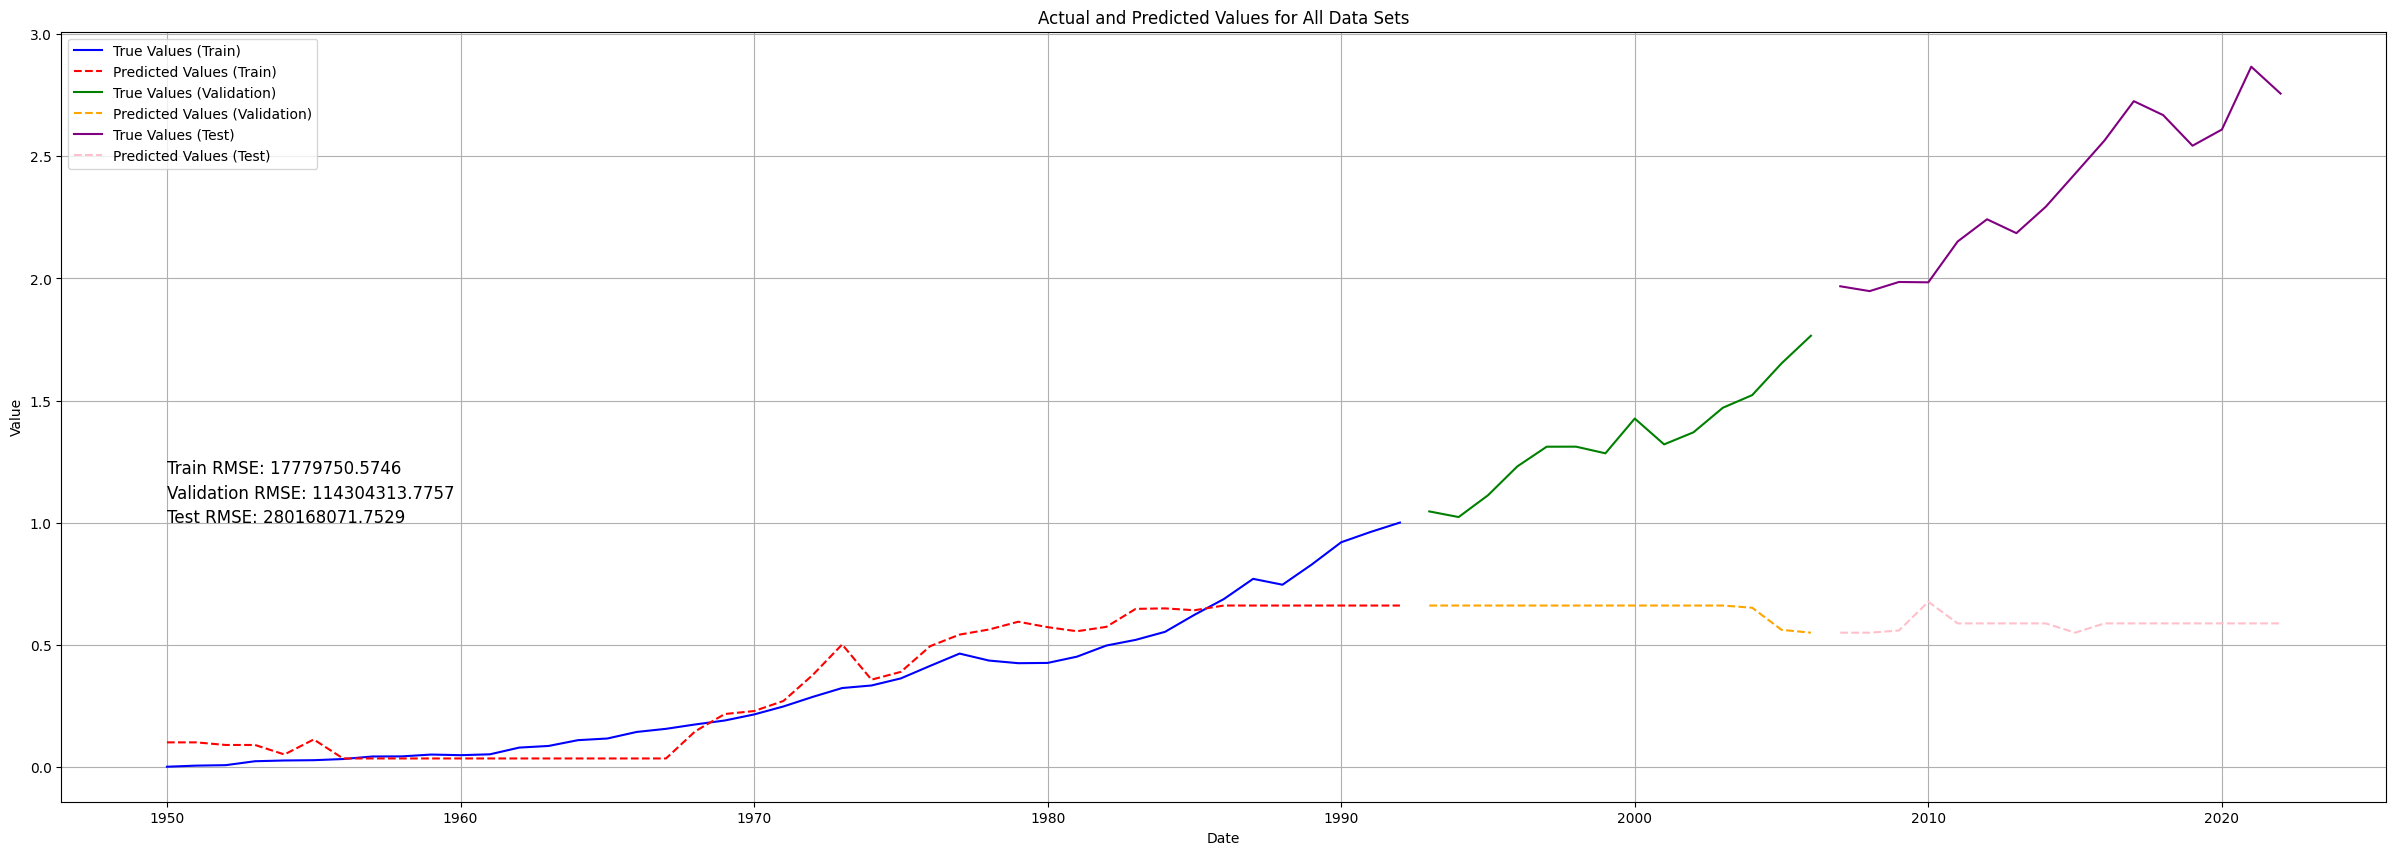

In [97]:
plot_predictions_with_metrics2(train_x_lgb_arima, val_x_lgb_arima, test_x_lgb_arima,
                              train_y_lgb_arima, train_pred_arima,
                              val_y_lgb_arima, val_pred_arima,
                              test_y_lgb_arima, test_pred_arima,
                              train_rmse_arima, val_rmse_arima, test_rmse_arima, 5)


##LSTM(Long Short Term Memory)

In [98]:
scaler_x, scaler_y, train_x_lstm, train_y_lstm, val_x_lstm, val_y_lstm, test_x_lstm, test_y_lstm, train_lstm, val_lstm, test_lstm = \
 scale_and_split_data(arima_filled_df, "Turkey",scaler_x, scaler_y)

X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm, X_test_lstm, y_test_lstm = prepare_data(train_x_lstm,
                                                                                                  train_y_lstm,
                                                                                                  val_x_lstm,
                                                                                                  val_y_lstm,
                                                                                                  test_x_lstm,
                                                                                                  test_y_lstm)


In [147]:
def create_model(input_shape, hidden_size, num_layers, dropout, learning_rate, activation):
  model = keras.models.Sequential()
  for i in range(num_layers):
    return_sequences = i < num_layers - 1
    input_shape = input_shape if i == 0 else None

    model.add(keras.layers.LSTM(units = hidden_size, input_shape = input_shape , return_sequences = return_sequences))
    model.add(keras.layers.Dropout(dropout))


  model.add(keras.layers.Dense(units = hidden_size, activation = activation))
  model.add(keras.layers.Dropout(dropout))

  model.add(keras.layers.Dense(units = 1))

  optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
  model.compile(optimizer = optimizer,
                loss = "mean_squared_error",
                metrics = ["mse"])

  return model


def objective(trial):
  hidden_size = trial.suggest_int("hidden_size", 32, 256, step = 16)
  num_layers = trial.suggest_int("num_layers", 1, 3)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout = trial.suggest_float("dropout", 0.1, 0.4, step = 0.1)
  activation = trial.suggest_categorical("activation", ["relu", "leaky_relu"])
  batch_size = trial.suggest_int("batch_size", 16, 32, step = 8)
  epochs = trial.suggest_int("epochs", 5, 50)


  input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])

  model = create_model(input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2]),
                       hidden_size = hidden_size,
                       num_layers = num_layers,
                       dropout = dropout,
                       learning_rate = learning_rate,
                       activation = activation)

  history = model.fit(X_train_lstm,
                      y_train_lstm,
                      validation_data = (X_val_lstm, y_val_lstm),
                      batch_size = batch_size,
                      epochs = epochs,
                      verbose = 0
                      )
  val_loss = min(history.history["val_loss"])

  return val_loss

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 50)






[I 2025-01-20 13:59:36,880] A new study created in memory with name: no-name-bcad8142-f56a-4a46-a5d0-9ded1e4f6989
[I 2025-01-20 13:59:48,483] Trial 0 finished with value: 0.20729096233844757 and parameters: {'hidden_size': 160, 'num_layers': 3, 'learning_rate': 7.194813371737452e-05, 'dropout': 0.1, 'activation': 'leaky_relu', 'batch_size': 24, 'epochs': 31}. Best is trial 0 with value: 0.20729096233844757.
[I 2025-01-20 13:59:55,973] Trial 1 finished with value: 1.9417601823806763 and parameters: {'hidden_size': 32, 'num_layers': 3, 'learning_rate': 0.00018522723126104858, 'dropout': 0.2, 'activation': 'leaky_relu', 'batch_size': 32, 'epochs': 5}. Best is trial 0 with value: 0.20729096233844757.
[I 2025-01-20 14:00:01,622] Trial 2 finished with value: 0.15097615122795105 and parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.014302906546766315, 'dropout': 0.4, 'activation': 'leaky_relu', 'batch_size': 24, 'epochs': 15}. Best is trial 2 with value: 0.15097615122795105

In [148]:
print(study.best_trial.value, study.best_trial.params) #n_trials = 50

0.003955025691539049 {'hidden_size': 128, 'num_layers': 1, 'learning_rate': 0.015069762380089058, 'dropout': 0.4, 'activation': 'relu', 'batch_size': 24, 'epochs': 48}


In [195]:
best_params_lstm = study.best_trial.params

#  {'hidden_size': 208,
#  'num_layers': 2,
#  'learning_rate': 0.0005359757466947834,
#  'dropout': 0.2,
#  'activation': 'leaky_relu',
#  'batch_size': 32,
#  'epochs': 34}

def build_best_lstm(units_, input_shape, num_layers, dropout, activation, learning_rate, epochs, batch_size):

  model = create_model(input_shape, units_, num_layers, dropout, learning_rate, activation)

  history_lstm = model.fit(X_train_lstm,
                    y_train_lstm,
                    batch_size = batch_size,
                    epochs=epochs,
                    validation_data = (X_val_lstm, y_val_lstm),
                    )
  return model, history_lstm


best_lstm, history_lstm = build_best_lstm(best_params_lstm["hidden_size"],
                                          (X_train_lstm.shape[1], X_train_lstm.shape[2]),
                                          best_params_lstm["num_layers"],
                                          best_params_lstm["dropout"],
                                          best_params_lstm["activation"],
                                          best_params_lstm["learning_rate"],
                                          best_params_lstm["epochs"],
                                          best_params_lstm["batch_size"],

                                          )




Epoch 1/48
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.8565 - mse: 0.8565 - val_loss: 2.2263 - val_mse: 2.2263
Epoch 2/48
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3320 - mse: 0.3320 - val_loss: 1.8800 - val_mse: 1.8800
Epoch 3/48
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1180 - mse: 0.1180 - val_loss: 0.4966 - val_mse: 0.4966
Epoch 4/48
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0766 - mse: 0.0766 - val_loss: 0.4157 - val_mse: 0.4157
Epoch 5/48
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0225 - mse: 0.0225 - val_loss: 0.9790 - val_mse: 0.9790
Epoch 6/48
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0617 - mse: 0.0617 - val_loss: 0.9816 - val_mse: 0.9816
Epoch 7/48
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0759 - mse: 0.0759 - val_loss: 0.7335 - val_mse: 0.7335
Epoch 8/48
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0458 - mse: 0.0458 - val_loss: 0.3169 - val_mse: 0.3169
Epoch 9/48
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0236 - mse: 0.0236 -

In [182]:
joblib.dump(best_lstm, "best_lstm_saved.joblib")


['best_lstm_saved.joblib']

In [196]:
true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_rmse, val_rmse, test_rmse = \
 evaluate_predictions(best_lstm, X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm, X_test_lstm, y_test_lstm)

Train RMSE: 6603726.571036519 Validation RMSE: 21198451.3345742 Test RMSE: 85452338.18169825


<Figure size 1280x960 with 0 Axes>

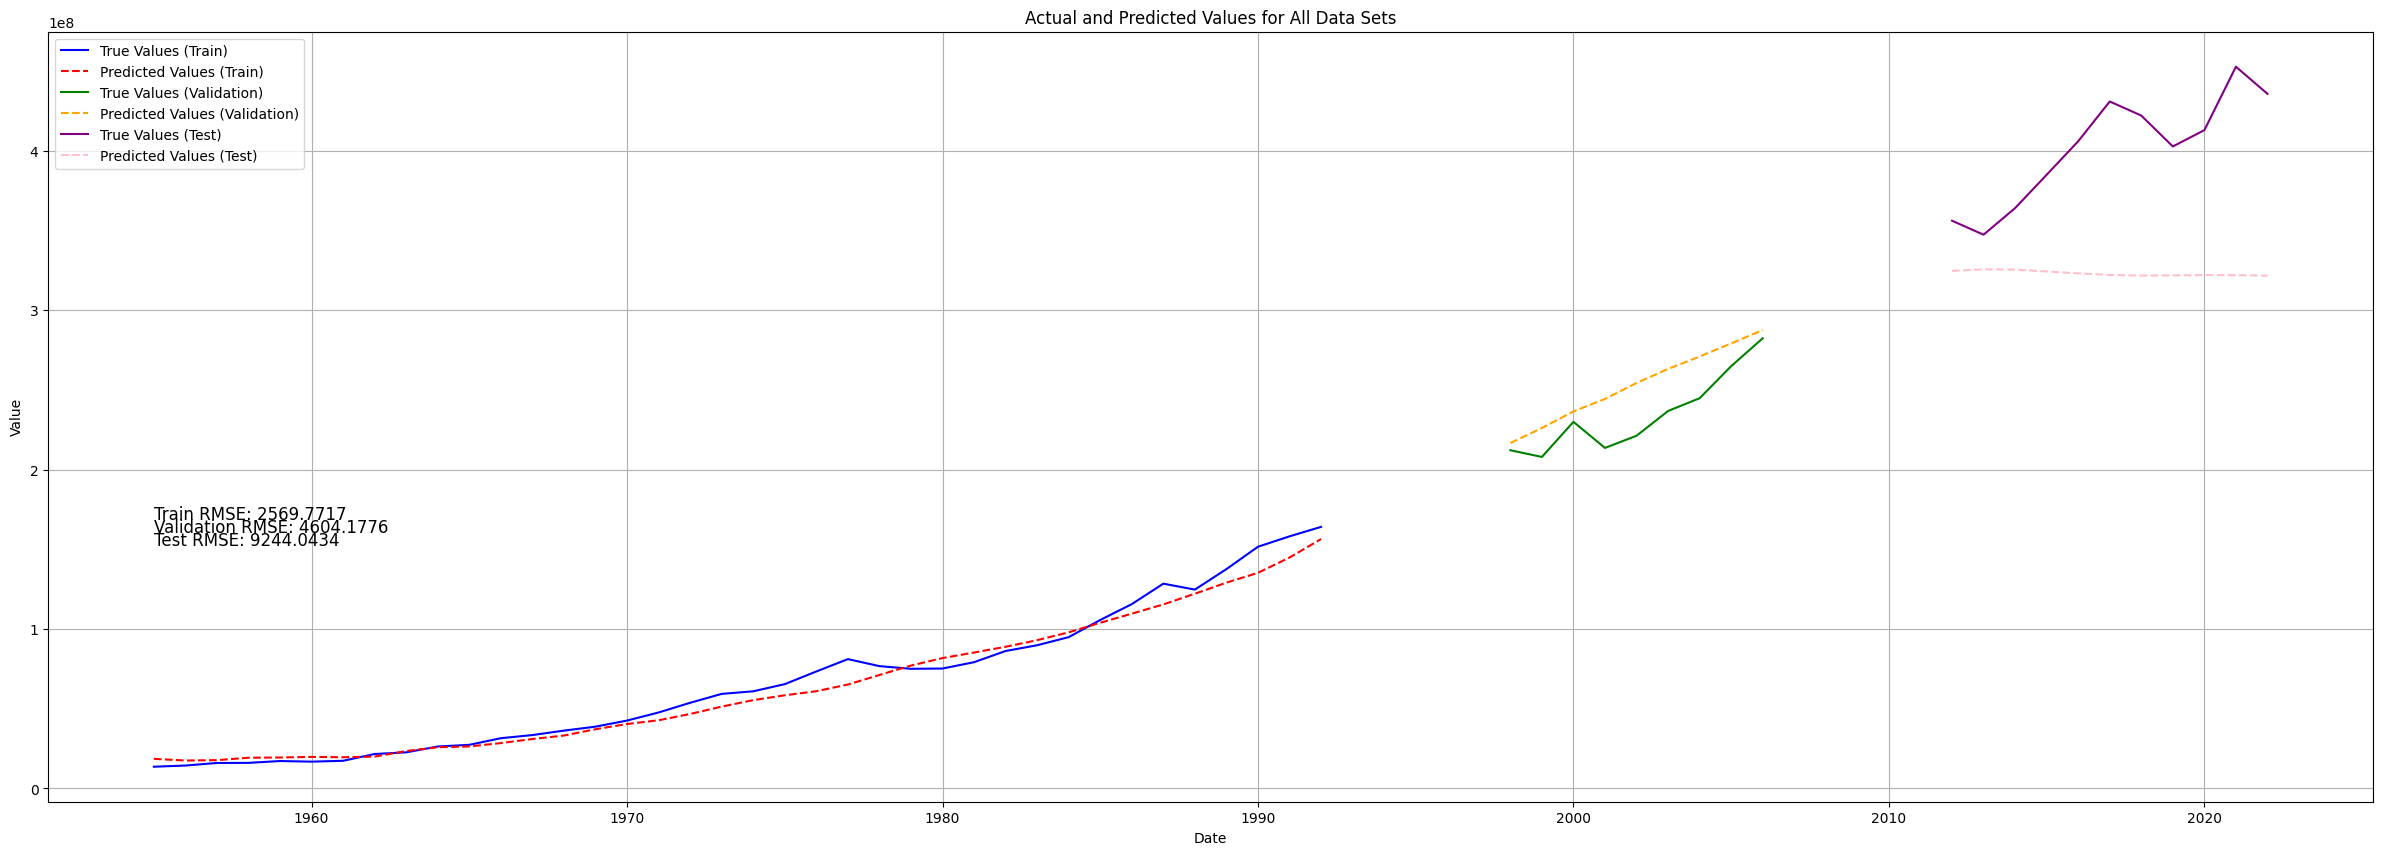

In [197]:
plot_predictions_with_metrics(train_x_lstm, val_x_lstm,
                              test_x_lstm, true_y_train, true_y_train_pred,
                              true_y_val, true_y_val_pred, true_y_test, true_y_test_pred,
                              train_rmse, val_rmse, test_rmse, time_steps=5)

In [105]:
test_predictions["LSTM_after"] = test_rmse

In [106]:
pd.DataFrame(np.column_stack((true_y_train, true_y_train_pred)), columns=["True Target Values", "Predicted Target Values"]).describe()

True Target Values  Predicted Target Values
count        3.800000e+01             3.800000e+01
mean         6.568946e+07             6.464766e+07
std          4.471141e+07             4.111531e+07
min          1.361942e+07             1.482387e+07
25%          2.656546e+07             2.834715e+07
50%          6.011932e+07             5.574485e+07
75%          8.891165e+07             9.437365e+07
max          1.640649e+08             1.554546e+08

## GRU(Gated Recurrent Unit)

In [107]:
def create_gru_model(trial, input_shape, hidden_size, num_layers, dropout, learning_rate, activation):
  model = keras.models.Sequential()
  for i in range(num_layers):
    return_sequences = i < num_layers - 1
    input_shape = input_shape if i == 0 else None

    kernel_regulizer = trial.suggest_categorical("regulizer", ["l1", "l2", "l1_l2"])
    if kernel_regulizer == "l1":
      kr_lr = l1(trial.suggest_float("l1_lambda", 1e-5, 1e-1, log=True))
    elif kernel_regulizer == "l2":
      kr_lr = l2(trial.suggest_float("l2_lambda", 1e-5, 1e-1, log=True))
    else:
      kr_lr = l1_l2(l1=trial.suggest_float("l1_lambda", 1e-5, 1e-1, log=True))

    model.add(keras.layers.GRU(units = hidden_size,
                               input_shape = input_shape ,
                               return_sequences = return_sequences,
                               kernel_regularizer = kr_lr,
                               activation = activation))
    model.add(keras.layers.Dropout(dropout))


  model.add(keras.layers.Dense(units = hidden_size, activation = activation))
  model.add(keras.layers.Dropout(dropout))

  model.add(keras.layers.Dense(units = 1))

  optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
  model.compile(optimizer = optimizer,
                loss = "mean_squared_error",
                metrics = ["mse"])

  return model

def objective(trial):
  hidden_size = trial.suggest_int("hidden_size", 32, 256, step = 16)
  num_layers = trial.suggest_int("num_layers", 1, 3)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout = trial.suggest_float("dropout", 0.1, 0.4, step = 0.1)
  activation = trial.suggest_categorical("activation", ["relu", "leaky_relu"])
  batch_size = trial.suggest_int("batch_size", 16, 32, step = 8)
  epochs = trial.suggest_int("epochs", 5, 50)
  input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])




  model = create_gru_model(trial=trial,
                           input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2]),
                           hidden_size = hidden_size,
                           num_layers = num_layers,
                           dropout = dropout,
                           learning_rate = learning_rate,
                           activation = activation)

  history = model.fit(X_train_lstm,
                      y_train_lstm,
                      validation_data = (X_val_lstm, y_val_lstm),
                      batch_size = batch_size,
                      epochs = epochs,
                      verbose = 0
                      )
  val_loss = min(history.history["val_loss"])

  return val_loss


study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 50)

[I 2025-01-20 13:41:03,825] A new study created in memory with name: no-name-b6f27b65-b570-4e20-ada7-888029cad783
[I 2025-01-20 13:41:09,608] Trial 0 finished with value: 0.1186961829662323 and parameters: {'hidden_size': 64, 'num_layers': 2, 'learning_rate': 0.004660657609003911, 'dropout': 0.2, 'activation': 'leaky_relu', 'batch_size': 16, 'epochs': 14, 'regulizer': 'l2', 'l2_lambda': 8.635822785231697e-05}. Best is trial 0 with value: 0.1186961829662323.
[I 2025-01-20 13:41:18,324] Trial 1 finished with value: 1.1161308288574219 and parameters: {'hidden_size': 256, 'num_layers': 1, 'learning_rate': 1.8265994848619827e-05, 'dropout': 0.4, 'activation': 'leaky_relu', 'batch_size': 32, 'epochs': 50, 'regulizer': 'l1_l2', 'l1_lambda': 0.0006216658821128876}. Best is trial 0 with value: 0.1186961829662323.
[I 2025-01-20 13:41:22,061] Trial 2 finished with value: 0.12233277410268784 and parameters: {'hidden_size': 176, 'num_layers': 1, 'learning_rate': 0.014516213360901677, 'dropout': 0.3

In [108]:
best_params_gru = study.best_trial.params
best_params_gru

{'hidden_size': 128,
 'num_layers': 1,
 'learning_rate': 0.003394098189343361,
 'dropout': 0.30000000000000004,
 'activation': 'relu',
 'batch_size': 32,
 'epochs': 35,
 'regulizer': 'l2',
 'l2_lambda': 9.039675015325179e-05}

In [110]:
def build_best_gru(units_, input_shape, num_layers, dropout, activation, learning_rate, epochs, batch_size, kr_lr):
  model = keras.models.Sequential()
  for i in range(num_layers):
    return_sequences = i < num_layers - 1
    input_shape = input_shape if i == 0 else None
    model.add(keras.layers.GRU(units = units_,
                               input_shape = input_shape ,
                               return_sequences = return_sequences,
                               kernel_regularizer = l2(kr_lr),
                               activation = activation))

    model.add(keras.layers.Dropout(dropout))


  model.add(keras.layers.Dense(units = units_, activation = activation))
  model.add(keras.layers.Dropout(dropout))

  model.add(keras.layers.Dense(units = 1))

  optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
  model.compile(optimizer = optimizer,
                loss = "mean_squared_error",
                metrics = ["mse"])



  history_gru = model.fit(X_train_lstm,
                    y_train_lstm,
                    batch_size = batch_size,
                    epochs=epochs,
                    validation_data = (X_val_lstm, y_val_lstm),
                    )
  return model, history_gru


best_gru, history_gru = build_best_gru(best_params_gru["hidden_size"],
                                          (X_train_lstm.shape[1], X_train_lstm.shape[2]),
                                          best_params_gru["num_layers"],
                                          best_params_gru["dropout"],
                                          best_params_gru["activation"],
                                          best_params_gru["learning_rate"],
                                          best_params_gru["epochs"],
                                          best_params_gru["batch_size"],
                                          best_params_gru["l2_lambda"]
                                          )

Epoch 1/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - loss: 0.2553 - mse: 0.2531 - val_loss: 0.0563 - val_mse: 0.0542
Epoch 2/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0191 - mse: 0.0170 - val_loss: 1.5990 - val_mse: 1.5970
Epoch 3/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0743 - mse: 0.0723 - val_loss: 0.5176 - val_mse: 0.5157
Epoch 4/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0289 - mse: 0.0270 - val_loss: 0.1382 - val_mse: 0.1364
Epoch 5/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0228 - mse: 0.0210 - val_loss: 0.1369 - val_mse: 0.1353
Epoch 6/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0281 - mse: 0.0264 - val_loss: 0.4312 - val_mse: 0.4296
Epoch 7/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0141 - mse: 0.0125 - val_loss: 1.2942 - val_mse: 1.2927
Epoch 8/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0140 - mse: 0.0124 - val_loss: 1.8343 - val_mse: 1.8328
Epoch 9/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0377 - mse: 0.0362 -

In [111]:
true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse = \
 evaluate_predictions(best_gru, X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm, X_test_lstm, y_test_lstm)

Train RMSE: 8941503.40201642 Validation RMSE: 65502903.17570192 Test RMSE: 462650419.904663


In [112]:
test_predictions["GRU_after"] = test_mse

<Figure size 1280x960 with 0 Axes>

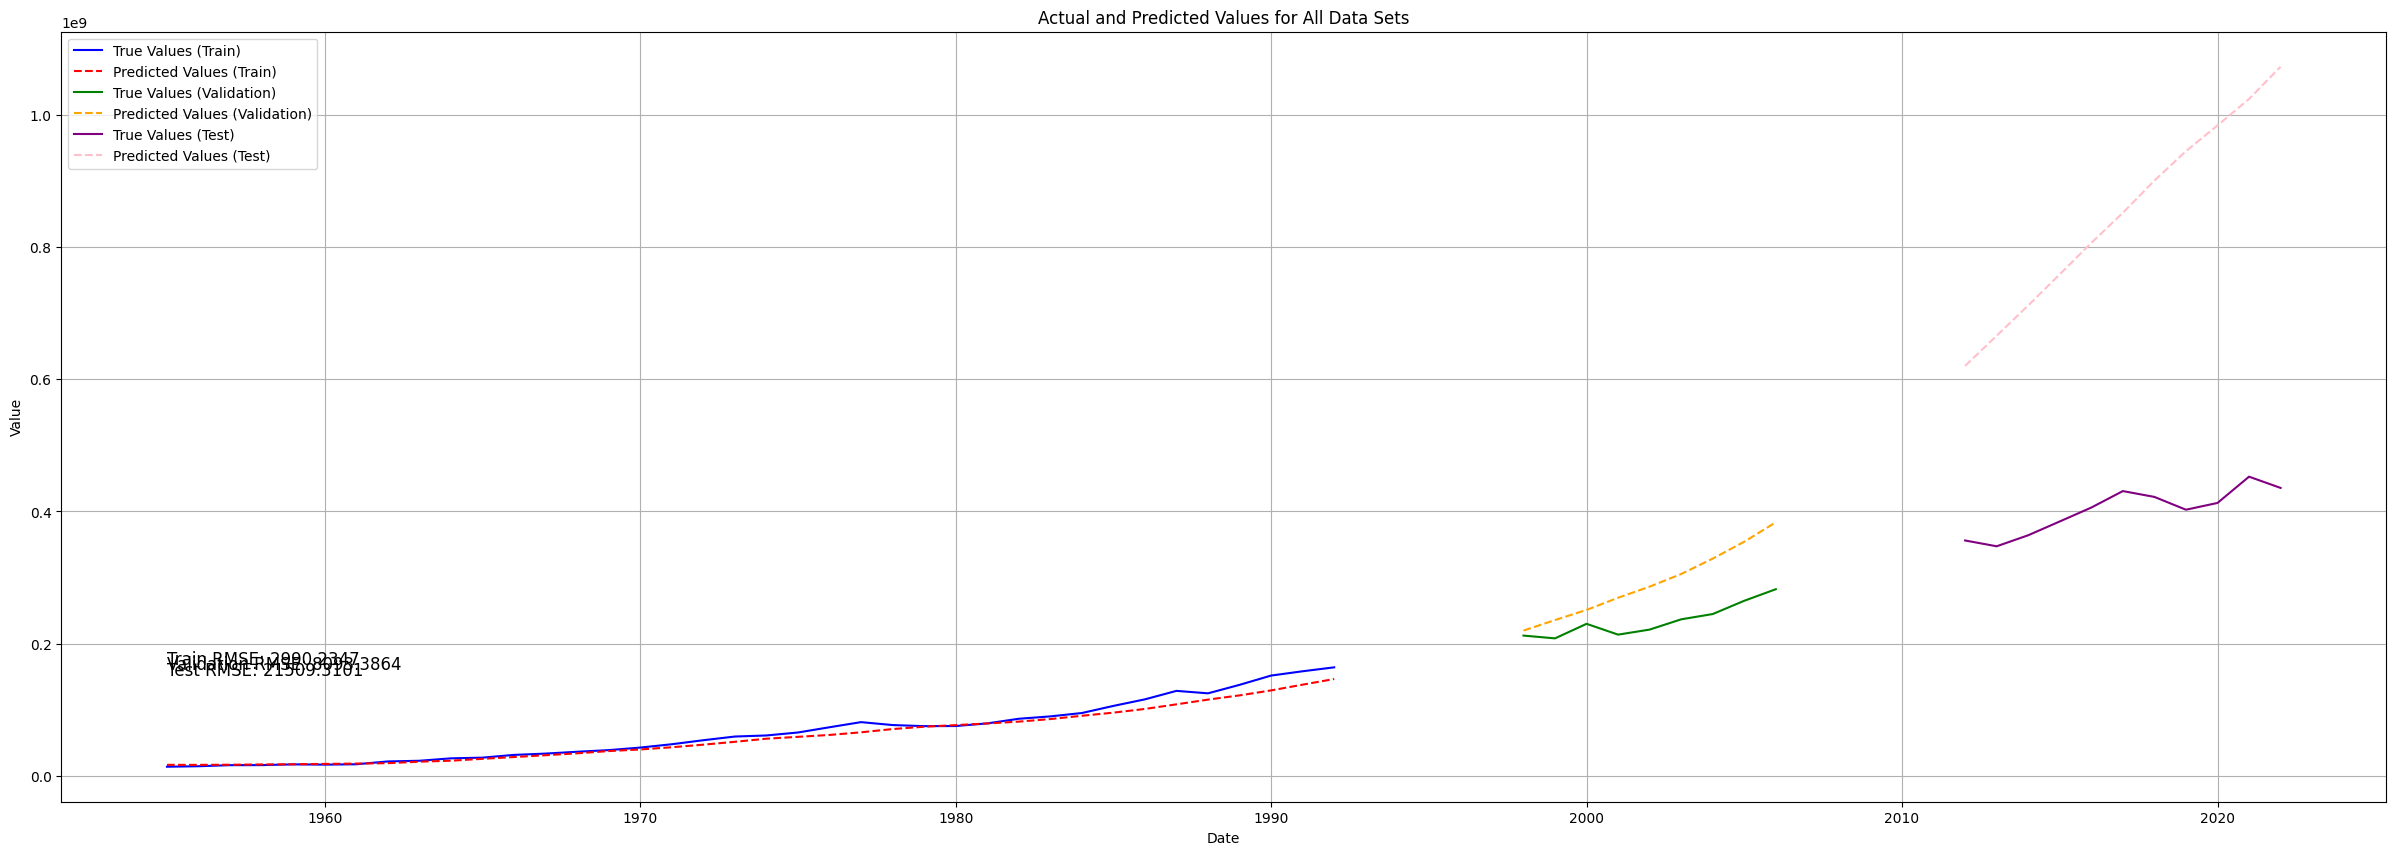

In [113]:
plot_predictions_with_metrics(train_x_lstm, val_x_lstm,
                              test_x_lstm,
                              true_y_train,
                              true_y_train_pred,
                              true_y_val,
                              true_y_val_pred,
                              true_y_test,
                              true_y_test_pred,
                              train_mse,
                              val_mse,
                              test_mse,
                              time_steps=5)

In [114]:
pd.DataFrame(np.column_stack((true_y_train, true_y_train_pred)), columns=["True Target Values", "Predicted Target Values"]).describe()

True Target Values  Predicted Target Values
count        3.800000e+01             3.800000e+01
mean         6.568946e+07             5.990403e+07
std          4.471141e+07             3.893772e+07
min          1.361942e+07             1.643148e+07
25%          2.656546e+07             2.343984e+07
50%          6.011932e+07             5.368618e+07
75%          8.891165e+07             8.478758e+07
max          1.640649e+08             1.464063e+08

## VAR(Vector AutoRegression)

In [115]:
train_var_df, val_var_df, test_var_df = load_var_data(arima_filled_df, countries, "Turkey")



target: p-value = 0.00027408386890363795
Annual greenhouse gas emissions in CO₂ equivalents: p-value = 3.4135150938709574e-07
Change in global mean surface temperature caused by greenhouse gas emissions: p-value = 0.5751376681419746
Change in global mean surface temperature caused by greenhouse gas emissions: p-value = 6.766154281245095e-10
Annual CO₂ emissions per GDP (kg per international-$): p-value = 2.6296818797985733e-12
population: p-value = 0.7866317502524109
population: p-value = 0.48414142164976115
population: p-value = 0.0061484159080388455
gdp: p-value = 0.4515580723779349
gdp: p-value = 0.006812957290134531
cumulative_cement_co2: p-value = 0.9990773287970959
cumulative_cement_co2: p-value = 0.0006662449610223653
cumulative_co2: p-value = 1.0
cumulative_co2: p-value = 0.0002667235095559502
cumulative_co2_including_luc: p-value = 0.004193091956564897
cumulative_coal_co2: p-value = 1.0
cumulative_coal_co2: p-value = 0.0005297978704364812
cumulative_flaring_co2: p-value = 0.97

In [116]:
def objective(trial):
  lag_order = trial.suggest_int("lag_order", 1, 6)
  var_model = VAR(train_var_df)
  var_results = var_model.fit(maxlags=lag_order)

  val_forecast = var_results.forecast(val_var_df.values[-lag_order:], steps=len(val_var_df))
  val_forecast_df = pd.DataFrame(val_forecast, columns=val_var_df.columns)

  mse = mean_squared_error(val_var_df.target.values, val_forecast_df.target.values)
  return mse

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 50)



[I 2025-01-20 13:48:11,577] A new study created in memory with name: no-name-2a69d7a6-61da-4699-8c9b-fad27347063f
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
[I 2025-01-20 13:48:11,593] Trial 0 finished with value: 4.750236799519115e+18 and parameters: {'lag_order': 6}. Best is trial 0 with value: 4.750236799519115e+18.
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
[I 2025-01-20 13:48:11,599] Trial 1 finished with value: 1.0368653544521623e+24 and parameters: {'lag_order': 3}. Best is trial 0 with value: 4.750236799519115e

In [117]:

best_var_params = study.best_trial.params
best_var_model = VAR(train_var_df).fit(maxlags=best_var_params["lag_order"])


forecast_val = best_var_model.forecast(train_var_df.values[-best_var_params["lag_order"]:], steps=len(val_var_df))
forecast_test = best_var_model.forecast(pd.concat([train_var_df, val_var_df]).values[-best_var_params["lag_order"]:], steps=len(test_var_df))

val_forecast_df = pd.DataFrame(forecast_val, index=val_var_df.index, columns=val_var_df.columns)
test_forecast_df = pd.DataFrame(forecast_test, index=test_var_df.index, columns=test_var_df.columns)

val_forecast_final = scaler_y.inverse_transform(val_forecast_df.target.values.reshape(-1, 1))
test_forecast_final = scaler_y.inverse_transform(test_forecast_df.target.values.reshape(-1, 1))

val_final = scaler_y.inverse_transform(val_var_df.target.values.reshape(-1, 1))
test_final = scaler_y.inverse_transform(test_var_df.target.values.reshape(-1, 1))

val_mse = mean_squared_error(val_final, val_forecast_final)
test_mse = mean_squared_error(test_final, test_forecast_final)
print(f"Train RMSE (VAR): {np.sqrt(train_mse)}")
print(f"Validation RMSE (VAR): {np.sqrt(val_mse)}")
print(f"Test RMSE (VAR): {np.sqrt(test_mse)}")







Train RMSE (VAR): 2990.234673402143
Validation RMSE (VAR): 1911791780847475.5
Test RMSE (VAR): 6.372099609832514e+16


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [118]:
test_predictions["GRU_after"] = np.sqrt(test_mse)

<Figure size 1280x960 with 0 Axes>

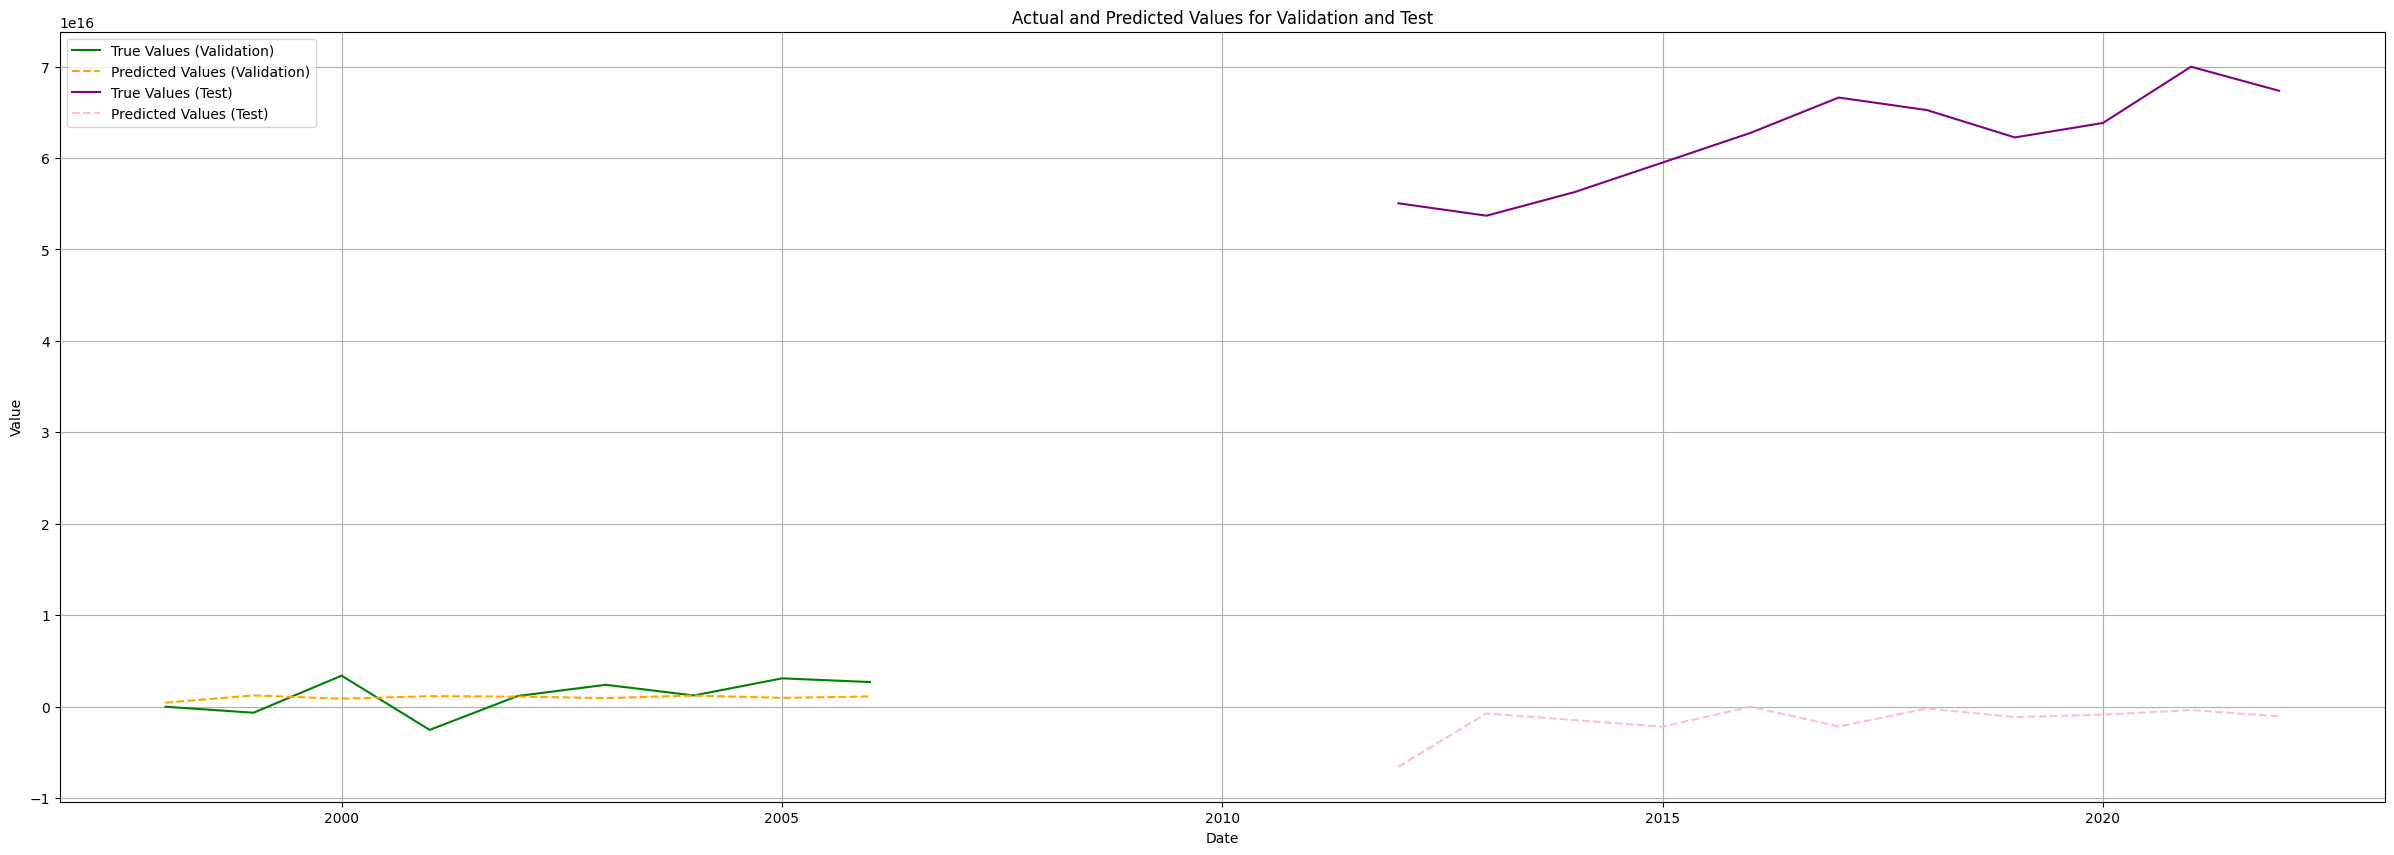

In [119]:
def plot_var_val():
    plt.figure(dpi=200)
    plt.figure(figsize=(30, 10))
    # Validation
    x_var = val_var_df.index
    x_test = test_var_df.index
    plt.plot(x_var, val_final.reshape(1, -1)[0], label='True Values (Validation)', color='green')
    plt.plot(x_var, val_forecast_final.reshape(1, -1)[0], '--', label='Predicted Values (Validation)', color='orange')
    plt.plot(x_test, test_final.reshape(1, -1)[0], label='True Values (Test)', color='purple')
    plt.plot(x_test, test_forecast_final.reshape(1, -1)[0], '--', label='Predicted Values (Test)', color='pink')
    plt.title('Actual and Predicted Values for Validation and Test')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_var_val()

In [120]:
for key, value in test_predictions.items():
  print(key, value)

LSTM_before 380731146.1230709
GRU_before 335861428.9812333
VAR_before 2.030370261357257e+17
LGBM_after 280168071.7528944
LSTM_after 318817973.9862041
GRU_after 6.372099609832514e+16


In [121]:
true_y_test

array([[3.5610720e+08],
       [3.4733174e+08],
       [3.6402830e+08],
       [3.8492966e+08],
       [4.0595020e+08],
       [4.3090086e+08],
       [4.2205862e+08],
       [4.0269226e+08],
       [4.1292688e+08],
       [4.5270280e+08],
       [4.3568460e+08]])

In [122]:
lstm_predicts = scaler_y.inverse_transform(best_lstm.predict(X_test_lstm).reshape(-1, 1))
lstm_predicts

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[1.1045467e+08],
       [1.0340205e+08],
       [9.7972216e+07],
       [9.2863392e+07],
       [8.8041960e+07],
       [8.4026624e+07],
       [7.9675256e+07],
       [7.6490144e+07],
       [7.4180336e+07],
       [7.1035664e+07],
       [6.5930756e+07]], dtype=float32)

In [123]:
scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1))

array([[3.5610720e+08],
       [3.4733174e+08],
       [3.6402830e+08],
       [3.8492966e+08],
       [4.0595020e+08],
       [4.3090086e+08],
       [4.2205862e+08],
       [4.0269226e+08],
       [4.1292688e+08],
       [4.5270280e+08],
       [4.3568460e+08]])

In [124]:
pd.DataFrame({"Real Test Values": scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1)).flatten(),
              "Best Test Predictions": lstm_predicts.flatten()
              }).applymap(lambda x: f"{x / 1e7:5f}e+07")

Real Test Values Best Test Predictions
0     35.610720e+07         11.045467e+07
1     34.733174e+07         10.340205e+07
2     36.402830e+07          9.797222e+07
3     38.492966e+07          9.286339e+07
4     40.595020e+07          8.804196e+07
5     43.090086e+07          8.402662e+07
6     42.205862e+07          7.967526e+07
7     40.269226e+07          7.649014e+07
8     41.292688e+07          7.418034e+07
9     45.270280e+07          7.103566e+07
10    43.568460e+07          6.593076e+07

#Forecasting

In [126]:

train_x_final, train_y_final, val_x_final, val_y_final, test_x_final, test_y_final, train_final, val_final, test_final = split_data(arima_filled_df, "Turkey")
test_y_final

Year
2007    313693340.0
2008    310622140.0
2009    316412300.0
2010    316193060.0
2011    342057300.0
2012    356107200.0
2013    347331740.0
2014    364028300.0
2015    384929660.0
2016    405950200.0
2017    430900860.0
2018    422058620.0
2019    402692260.0
2020    412926880.0
2021    452702800.0
2022    435684600.0
Name: target, dtype: float64

In [248]:
test_y_final.describe()

count    1.600000e+01
mean     3.758932e+08
std      4.860088e+07
min      3.106221e+08
25%      3.356460e+08
50%      3.744790e+08
75%      4.152098e+08
max      4.527028e+08
Name: target, dtype: float64

In [127]:
y_test_pred = best_lstm.predict(X_test_lstm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [128]:
pd.DataFrame(scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1)), columns=["True Target Values"]).describe()

True Target Values
count        1.100000e+01
mean         4.013921e+08
std          3.449995e+07
min          3.473317e+08
25%          3.744790e+08
50%          4.059502e+08
75%          4.264797e+08
max          4.527028e+08

In [129]:
np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1)),
                           scaler_y.inverse_transform(y_test_pred.reshape(-1, 1))))

318817973.9862041

In [221]:
X_test = X_test_lstm[-1:]  # timewindow = 5.

predictions = []
for _ in range(10):  # 10 yıl * 12 ay
  prediction = best_lstm.predict(X_test.reshape(1, X_test.shape[1], X_test.shape[2]))
  predictions.append(prediction[0,0])

  # Reshape prediction to match X_test's feature dimension
  prediction_reshaped = np.repeat(prediction, 13).reshape(1, 1, 13)

  # Shift X_test and append prediction
  X_test = np.concatenate((X_test[:, 1:], prediction_reshaped), axis=1)

# Sonuçlar
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[2.0192928, 0.86220044, 1.0107642, 1.0586841, 1.0741245, 1.0841857, 1.0690798, 1.0808532, 1.081215, 1.0812069]


In [199]:
scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))

array([[3.2162384e+08],
       [1.4276427e+08],
       [1.6572878e+08],
       [1.7313608e+08],
       [1.7552280e+08],
       [1.7707805e+08],
       [1.7474301e+08],
       [1.7656291e+08],
       [1.7661885e+08],
       [1.7661758e+08]], dtype=float32)

In [200]:
years = np.arange(2023, 2033)
forecast_df = pd.DataFrame({"Years": years, "Predicted CO2 Emission": scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()})
forecast_df.set_index("Years", inplace=True)
forecast_df

Predicted CO2 Emission
Years                        
2023              321623840.0
2024              142764272.0
2025              165728784.0
2026              173136080.0
2027              175522800.0
2028              177078048.0
2029              174743008.0
2030              176562912.0
2031              176618848.0
2032              176617584.0

In [201]:
predictions

[2.0192928,
 0.86220044,
 1.0107642,
 1.0586841,
 1.0741245,
 1.0841857,
 1.0690798,
 1.0808532,
 1.081215,
 1.0812069]

In [202]:
data_best_lstm = forecast_df.values.flatten()
data_best_lstm

array([3.2162384e+08, 1.4276427e+08, 1.6572878e+08, 1.7313608e+08,
       1.7552280e+08, 1.7707805e+08, 1.7474301e+08, 1.7656291e+08,
       1.7661885e+08, 1.7661758e+08], dtype=float32)

In [242]:
def calculate_confidence_interval(data, confidence=0.95, n_iterations=1000):
  """This function is to calculate confidence intervals for denpended values like time series.
  Bootstrapping is represented in this funtion"""


  n_steps = len(data)

  #bootstrap_samples = np.zeros((n_iterations, n_steps))
  # for step in range(n_steps):
  #     for i in range(n_iterations):
  #         bootstrap_samples[i, step] = np.random.normal(
  #             loc=data[step],
  #             scale=data[step] * 0.05
  #         )

  bootstrap_samples = np.random.normal(loc=data, scale=data_best_lstm * (1-confidence), size=(n_iterations, n_steps))
  percentiles = np.percentile(bootstrap_samples, [2.5, 97.5], axis=0)
  lower_bound = percentiles[0]
  upper_bound = percentiles[1]
  return lower_bound, upper_bound

ci_lower, ci_upper = calculate_confidence_interval(data_best_lstm)
print(ci_lower)
print(ci_upper)

[2.91684747e+08 1.28566341e+08 1.49084995e+08 1.56758624e+08
 1.59090516e+08 1.59789928e+08 1.57888720e+08 1.59811473e+08
 1.58920063e+08 1.58686758e+08]
[3.50067635e+08 1.56700704e+08 1.80813129e+08 1.88704592e+08
 1.92169347e+08 1.93812534e+08 1.92422650e+08 1.93075769e+08
 1.94280964e+08 1.94035245e+08]


<Figure size 1280x960 with 0 Axes>

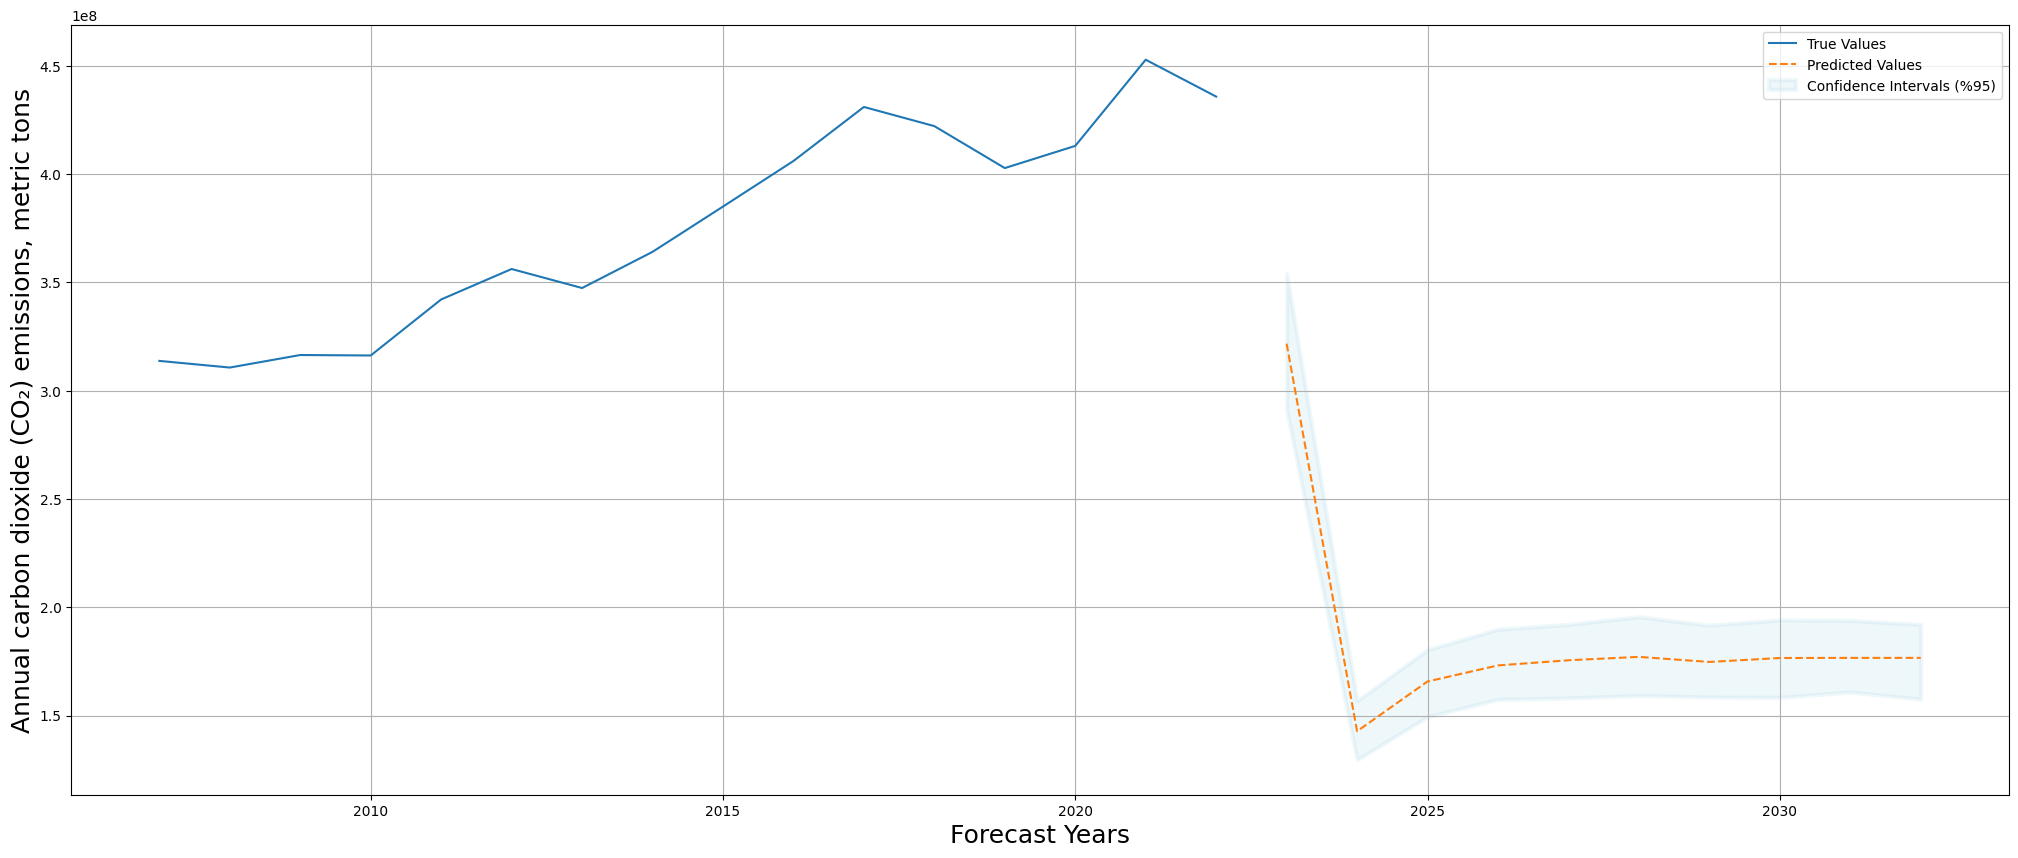

In [223]:
plt.figure(dpi=200)
plt.figure(figsize=(25,10))
plt.plot(test_y_final.index, test_y_final, label="True Values")
plt.plot(years, scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)), "--", label="Predicted Values")
plt.fill_between(years, ci_lower, ci_upper, color="lightblue", alpha=0.2, label="Confidence Intervals (%95)", linewidth=3)
plt.legend()
plt.xlabel("Forecast Years", fontsize=18)
plt.ylabel("Annual carbon dioxide (CO₂) emissions, metric tons", fontsize=18)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# def final_results(model_, forecas_years = 10):
#   X_test = X_test_lstm[-1:]  # timewindow = 5.

#   predictions = []

#   for _ in range(forecas_years):
#     prediction = model_.predict(X_test.reshape(1, X_test.shape[1], X_test.shape[2]))
#     predictions.append(prediction[0,0])

#     # Reshape prediction to match X_test's feature dimension
#     prediction_reshaped = np.repeat(prediction, 13).reshape(1, 1, 13)

#     # Shift X_test and append prediction
#     X_test = np.concatenate((X_test[:, 1:], prediction_reshaped), axis=1)

#   print(predictions)

#   years = np.arange(2023, 2033)
#   forecast_df = pd.DataFrame({"Years": years,
#                               "Predicted CO2 Emission": scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()})
#   forecast_df.set_index("Years", inplace=True)
#   return forecast_df, predictions

# forecas_df_saved, preds = final_results(best_lstm_saved)

In [246]:
X_test = X_test_lstm[-1:]  # timewindow = 5.

predictions_gru = []
for _ in range(10):  # 10 yıl * 12 ay
  prediction = best_gru.predict(X_test.reshape(1, X_test.shape[1], X_test.shape[2]))
  predictions_gru.append(prediction[0,0])

  # Reshape prediction to match X_test's feature dimension
  prediction_reshaped = np.repeat(prediction, 13).reshape(1, 1, 13)

  # Shift X_test and append prediction
  X_test = np.concatenate((X_test[:, 1:], prediction_reshaped), axis=1)

# Sonuçlar
print(predictions_gru)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[6.882158, 6.174067, 5.8668942, 5.640603, 5.4290285, 5.057225, 4.80808, 4.5949073, 4.406949, 4.240046]


In [245]:
predictions_gru = scaler_y.inverse_transform(np.array(predictions_gru).reshape(-1, 1))
predictions_gru

array([[1.0733096e+09],
       [9.6385517e+08],
       [9.1637344e+08],
       [8.8139405e+08],
       [8.4868960e+08],
       [7.9121741e+08],
       [7.5270541e+08],
       [7.1975386e+08],
       [6.9069990e+08],
       [6.6490054e+08]], dtype=float32)

In [239]:
ci_lower, ci_upper = calculate_confidence_interval(predictions_gru)
print(ci_lower)
print(ci_upper)

[-33160545.6390683  -13225821.20935575 -16173713.10225015
 -16833489.95052534 -19100843.75235664 -16728083.79640975
 -17374505.5495624  -17466259.76631757 -16369647.75508134
 -17035659.48100758]
[31765220.00464398 13794487.50452928 15812689.03554694 17887131.83163024
 16376724.86820134 17464004.97738922 18020770.96997107 16792665.43829193
 16802187.58686924 17655923.32427596]


In [238]:
np.array(ci_lower)

array([-30437265.38326503, -13107072.55677568, -14824801.009609  ,
       -16172076.8885031 , -15702835.4098352 , -17315514.5480343 ,
       -15501194.50352452, -16648355.52044714, -17210528.71358906,
       -16459652.652694  ])

<Figure size 1280x960 with 0 Axes>

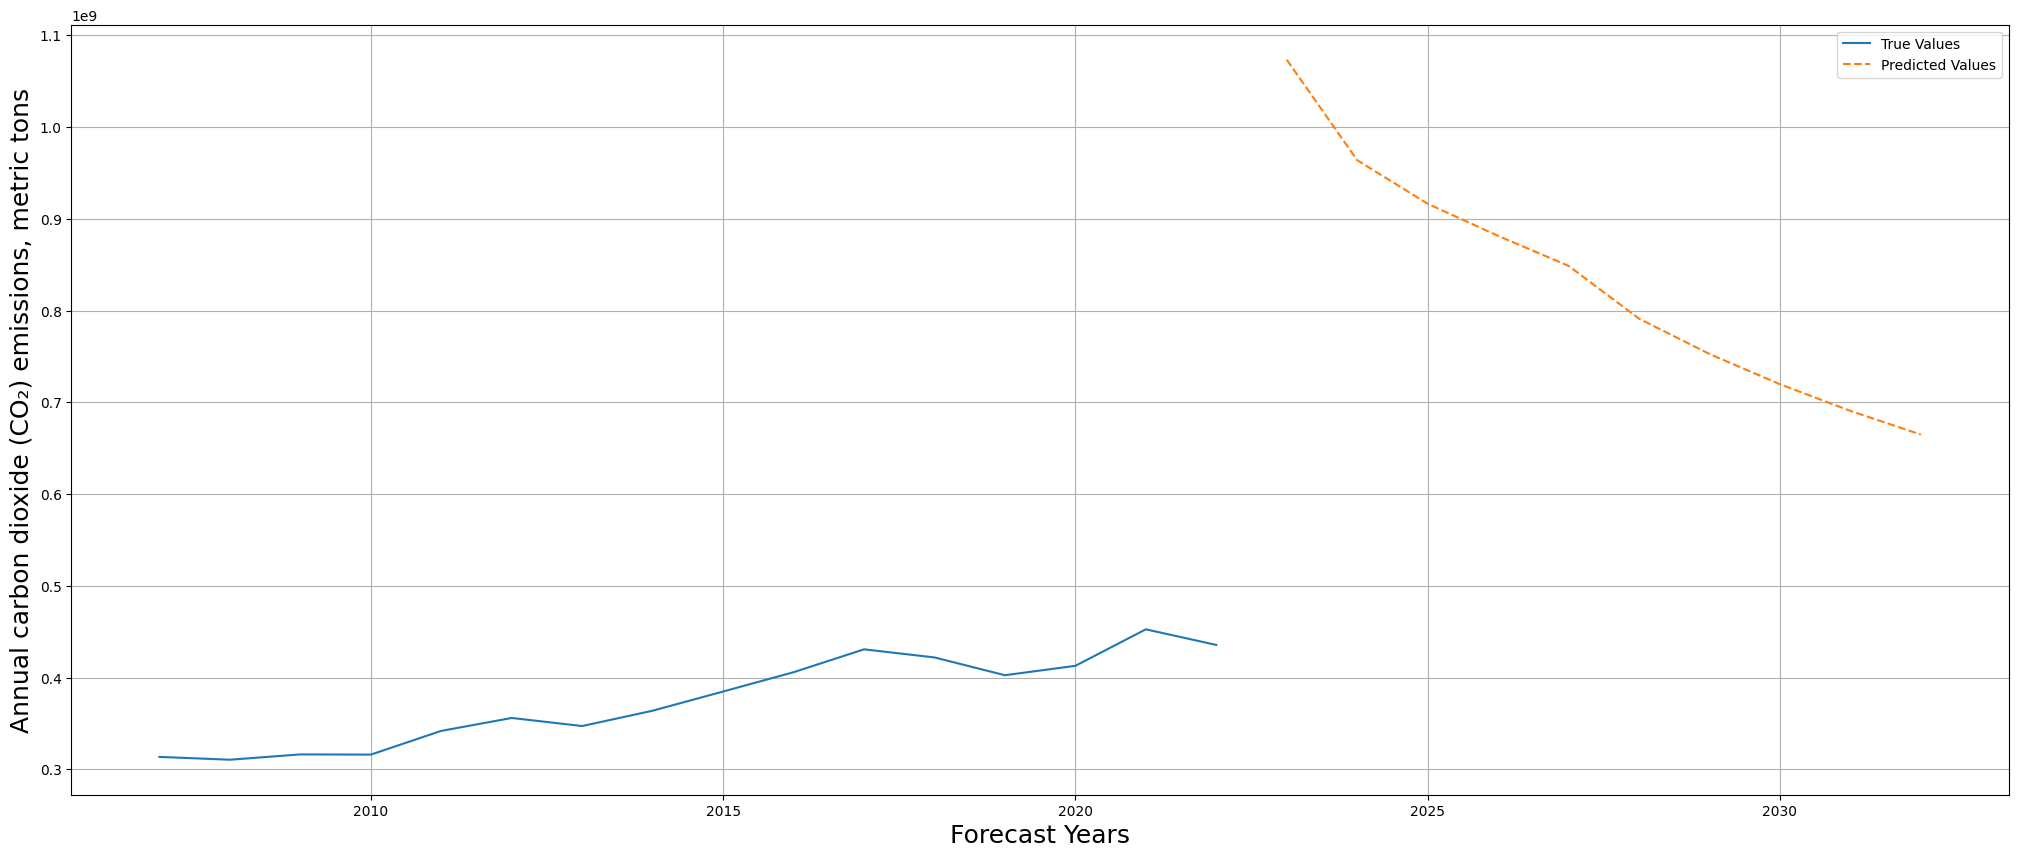

In [247]:
plt.figure(dpi=200)
plt.figure(figsize=(25,10))
plt.plot(test_y_final.index, test_y_final, label="True Values")
plt.plot(years, scaler_y.inverse_transform(np.array(predictions_gru).reshape(-1,1)), "--", label="Predicted Values")
plt.legend()
plt.xlabel("Forecast Years", fontsize=18)
plt.ylabel("Annual carbon dioxide (CO₂) emissions, metric tons", fontsize=18)
plt.grid(True)
plt.legend()
plt.show()